Suggested improvement: Training the mega detector on The cod10k training dataset in hopes to improve the predictions for the test cod10k,

Deliverable 6:
We generated annotations and bounding boxes in COCO JSON format and also created YOLO TXT format label files. The bounding boxes were combined into the YOLO TXT format files, and classes were assigned: "1" for humans and "0" for animals, with empty images having no labels. These files were then used alongside the image data to train our model, "MDv6", which runs on "YOLOv9-e". Training was carried out using the main.py file from the Ultralytics GitHub repository, and the model was trained for 40 epochs. The details of the hyperparameters used during training are included in one of the code cells of this notebook.

After training, we evaluated the model to calculate the Intersection over Union (IoU) scores. Although the increase in IoU score was modest, even this slight improvement is significant when working with a state-of-the-art model. In the context of improving a complex and well-established model like YOLOv9-e, these incremental gains demonstrate the effectiveness of our approach. We also generated images representing the predictions made by the trained model to visualize its performance.

Procedure:

removed aquatic images from training data

split data into train, test, val to put it into a trainable format

made yolo txt files for all images ( empty files for empty images)

acquired mdv6 weights from thte following git repo
https://github.com/microsoft/CameraTraps/blob/main/PW_FT_detection/utils.py

and followed the steps in
https://github.com/microsoft/CameraTraps/tree/main/PW_FT_detection

to train the mdv6 model


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
from pathlib import Path

# Define base path
base_path = Path("/content/drive/MyDrive/DL_data/labels/labels_yolo")
splits = ["train", "val", "test"]

# Go through each split folder
for split in splits:
    split_path = base_path / split
    for txt_file in split_path.glob("*.txt"):
        if "human" in txt_file.name.lower():
            # Read the original lines
            with open(txt_file, "r") as f:
                lines = f.readlines()

            # Modify each line to change the category ID to 1
            updated_lines = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:  # ensure it's a valid YOLO label
                    parts[0] = "1"  # change class ID to 1
                    updated_lines.append(" ".join(parts))
                else:
                    updated_lines.append(line.strip())  # keep malformed line unchanged

            # Write the updated lines back to the file
            with open(txt_file, "w") as f:
                f.write("\n".join(updated_lines))

print("✅ Category ID updated to 1 for all files containing 'human' in their name.")


Run -Kaggle

In [ ]:
!git clone https://github.com/microsoft/CameraTraps.git


run kaggle


In [ ]:
%cd /kaggle/working/CameraTraps/PW_FT_detection
!pip install wget
import sys
sys.path.insert(0, '/kaggle/working/CameraTraps/PW_FT_detection')
from utils import get_model_path



run-KAGGLE

In [ ]:
model_path = get_model_path("MDV6-yolov9-e")
print(model_path)

run kaggl

In [ ]:
pip install -r requirements.txt


FOR KAGGLE

In [ ]:
# Define the configuration text
config_text = """batch_size_train: 16
batch_size_val: 8
data: /kaggle/working/your_data.yaml
device_train: 0
device_val: 0
epochs: 40
exp_name: MDV6-yolov9-e
imgsz: 512
lr0: 0.001
model: YOLO
model_name: MDV6-yolov9-e
optimizer: auto
patience: 10
plot: true
resume: false
save_json: true
save_period: 1
task: train
test_data: /kaggle/input/cod-10k-data/COD10K/images/test
val: true
weights: /root/.cache/torch/hub/checkpoints/MDV6-yolov9e.pt
workers: 8
"""

# Specify the path to the config file
config_file_path = "/kaggle/working/CameraTraps/PW_FT_detection/config.yaml"

# Open the file and write the new configuration text
with open(config_file_path, "w") as f:
    f.write(config_text)

# Confirm the update
print(f"Updated the configuration file at {config_file_path}")


YAML for kaggle


In [ ]:
import yaml

# Define the YAML data
yaml_data = {
    "path": "/kaggle/input/cod-10k-data/COD10K/images",  # Specify the path in Kaggle working directory
    "train": "train",  # Subdirectory for training images
    "val": "val",      # Subdirectory for validation images
    "test": "test",
    "names": {
        0: "animal",
        1: "person",
        2: "vehicle"
    }
}

# Specify the path for the YAML file in Kaggle directory
yaml_file_path = "/kaggle/working/your_data.yaml"

# Write the YAML data to the file
with open(yaml_file_path, "w") as f:
    yaml.dump(yaml_data, f, sort_keys=False)

print(f"YAML file created at {yaml_file_path}")


In [ ]:
!python main.py

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

# Load your trained model from Drive
#model = YOLO("/content/drive/MyDrive/DL_data/exp3_unzipped/weights/last.pt")


Succesfully trained the mdv6 but inference results as of yet show that the model is failing in detecting objects, will work on this

---




In [7]:
import os
import json
from PIL import Image
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm  # Import tqdm for the progress bar

# Directories for test images and ground truth (mask) images
image_dir = "/kaggle/input/cod10ktest/Image"
mask_dir = "/kaggle/input/cod10ktest-mask/GT_Object"

# Load the pre-trained YOLO model (replace with your model path)
model = YOLO('/kaggle/working/CameraTraps/PW_FT_detection/runs/train_MDV6-yolov9-e/exp/weights/last.pt')  # Adjust to your model path

# Initialize list for storing IoU scores
ious = []

# Function to calculate IoU
def calculate_iou(box1, box2):
    """
    box format: [x1, y1, x2, y2]
    """
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = interArea / float(box1Area + box2Area - interArea + 1e-6)
    return iou

# List of all image files
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Initialize tqdm progress bar
with tqdm(total=len(image_files), desc="Processing Images", unit="image", ncols=100, position=0) as pbar:
    # Loop through all the images in the test directory
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, image_file.replace('.jpg', '.png'))  # Assumed .png masks

        # Perform inference with YOLOv9e
        results = model(image_path, conf=0.1, save=True)
        result = results[0]

        # Load the ground truth mask for the image
        try:
            obj_img = Image.open(mask_path).convert("L")
        except Exception as e:
            continue

        # Convert GT mask to binary (0 for background, 1 for object)
        gt_mask = np.array(obj_img) > 0
        h, w = gt_mask.shape  # Get dimensions of the mask

        # Get bounding boxes and confidence scores from the detection results
        bboxes = result.boxes.xyxy.cpu().numpy()  # Get bounding boxes as numpy arrays
        confidences = result.boxes.conf.cpu().numpy()  # Get confidence scores

        # If there are no detections, skip this image
        if len(bboxes) == 0:
            continue

        # Assuming only one detection, select the highest confidence
        best_confidence = -1
        best_bbox = None
        for bbox, confidence in zip(bboxes, confidences):
            if confidence > best_confidence:
                best_confidence = confidence
                best_bbox = bbox

        # If we have a valid detection, calculate IoU
        if best_bbox is not None:
            x1, y1, x2, y2 = map(int, best_bbox)

            # Create detection mask
            det_mask = np.zeros((h, w), dtype=bool)
            det_mask[y1:y2, x1:x2] = True

            # Calculate IoU with GT mask
            intersection = np.logical_and(det_mask, gt_mask).sum()
            union = np.logical_or(det_mask, gt_mask).sum()
            iou = intersection / (union + 1e-6)

            ious.append(iou)

        # Update progress bar without printing unnecessary logs
        pbar.update(1)

# Calculate and print final IoU statistics
if ious:
    print(f"📊 Mean IoU: {np.mean(ious):.4f}")
    print(f"📉 Min IoU: {np.min(ious):.4f}")
    print(f"📈 Max IoU: {np.max(ious):.4f}")
else:
    print("❌ No valid IoU values calculated.")


Processing Images:   0%|                                                | 0/1552 [00:00<?, ?image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-54-Bittern-3255.jpg: 320x512 1 animal, 49.5ms
Speed: 1.2ms preprocess, 49.5ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:   0%|                                        | 1/1552 [00:00<23:47,  1.09image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1543.jpg: 320x512 (no detections), 48.5ms
Speed: 1.3ms preprocess, 48.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2890.jpg: 352x512 1 animal, 53.2ms
Speed: 1.7ms preprocess, 53.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   0%|                                        | 2/1552 [00:01<12:08,  2.13image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3792.jpg: 416x512 5 animals, 40.5ms
Speed: 2.0ms preprocess, 40.5ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1459.jpg: 320x512 (no detections), 33.5ms
Speed: 1.6ms preprocess, 33.5ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3486.jpg: 352x512 2 animals, 36.7ms
Speed: 1.6ms preprocess, 36.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   0%|                                        | 4/1552 [00:01<06:03,  4.25image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3112.jpg: 352x512 3 animals, 28.2ms
Speed: 1.8ms preprocess, 28.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1527.jpg: 352x512 (no detections), 29.2ms
Speed: 1.7ms preprocess, 29.2ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2235.jpg: 384x512 1 animal, 31.8ms
Speed: 1.5ms preprocess, 31.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   0%|▏                                       | 6/1552 [00:01<04:15,  6.05image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2702.jpg: 384x512 2 animals, 30.5ms
Speed: 1.5ms preprocess, 30.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4339.jpg: 384x512 2 animals, 30.5ms
Speed: 1.8ms preprocess, 30.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   1%|▏                                       | 8/1552 [00:01<03:09,  8.14image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1805.jpg: 512x352 2 animals, 31.3ms
Speed: 1.7ms preprocess, 31.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3359.jpg: 352x512 (no detections), 29.4ms
Speed: 1.2ms preprocess, 29.4ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2067.jpg: 352x512 1 animal, 29.4ms
Speed: 1.7ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   1%|▎                                      | 10/1552 [00:01<02:47,  9.20image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1622.jpg: 512x416 1 animal, 33.6ms
Speed: 1.8ms preprocess, 33.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2831.jpg: 352x512 3 animals, 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   1%|▎                                      | 12/1552 [00:01<02:23, 10.74image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1377.jpg: 512x384 (no detections), 30.7ms
Speed: 1.6ms preprocess, 30.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3694.jpg: 512x352 2 animals, 30.5ms
Speed: 1.6ms preprocess, 30.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3496.jpg: 288x512 1 animal, 28.5ms
Speed: 1.1ms preprocess, 28.5ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:   1%|▎                                      | 14/1552 [00:02<02:19, 11.02image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-1978.jpg: 352x512 1 animal, 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3221.jpg: 512x352 1 animal, 32.5ms
Speed: 1.6ms preprocess, 32.5ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:   1%|▍                                      | 16/1552 [00:02<02:06, 12.10image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3710.jpg: 512x512 2 animals, 34.2ms
Speed: 2.3ms preprocess, 34.2ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4346.jpg: 384x512 1 animal, 32.2ms
Speed: 1.7ms preprocess, 32.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   1%|▍                                      | 18/1552 [00:02<01:57, 13.06image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2185.jpg: 512x256 2 animals, 34.5ms
Speed: 1.1ms preprocess, 34.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 256)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4887.jpg: 416x512 1 animal, 30.4ms
Speed: 1.8ms preprocess, 30.4ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:   1%|▌                                      | 20/1552 [00:02<01:52, 13.63image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4604.jpg: 416x512 2 animals, 31.5ms
Speed: 1.6ms preprocess, 31.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4784.jpg: 384x512 3 animals, 46.1ms
Speed: 2.9ms preprocess, 46.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   1%|▌                                      | 22/1552 [00:02<01:55, 13.23image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2877.jpg: 352x512 (no detections), 29.7ms
Speed: 1.6ms preprocess, 29.7ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3374.jpg: 512x352 3 animals, 29.9ms
Speed: 1.7ms preprocess, 29.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4364.jpg: 512x352 1 animal, 28.8ms
Speed: 1.6ms preprocess, 28.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:   2%|▌                                      | 24/1552 [00:02<02:01, 12.58image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3440.jpg: 512x352 6 animals, 28.3ms
Speed: 1.6ms preprocess, 28.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3987.jpg: 288x512 2 animals, 28.2ms
Speed: 1.2ms preprocess, 28.2ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:   2%|▋                                      | 26/1552 [00:02<01:50, 13.83image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1415.jpg: 512x384 (no detections), 30.9ms
Speed: 1.4ms preprocess, 30.9ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-51-Bee-2995.jpg: 512x512 (no detections), 39.4ms
Speed: 1.9ms preprocess, 39.4ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2451.jpg: 352x512 2 animals, 31.8ms
Speed: 1.5ms preprocess, 31.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2344.jpg: 352x512 4 animals, 30.1ms
Speed: 1.6ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   2%|▋                                      | 28/1552 [00:03<02:09, 11.79image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4718.jpg: 352x512 5 animals, 28.7ms
Speed: 1.2ms preprocess, 28.7ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4219.jpg: 320x512 1 animal, 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:   2%|▊                                      | 30/1552 [00:03<01:56, 13.05image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2194.jpg: 352x512 1 animal, 30.3ms
Speed: 1.3ms preprocess, 30.3ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3051.jpg: 288x512 4 animals, 28.2ms
Speed: 1.4ms preprocess, 28.2ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:   2%|▊                                      | 32/1552 [00:03<01:49, 13.94image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4060.jpg: 384x512 3 animals, 30.7ms
Speed: 1.6ms preprocess, 30.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2772.jpg: 352x512 2 animals, 30.2ms
Speed: 1.6ms preprocess, 30.2ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   2%|▊                                      | 34/1552 [00:03<01:42, 14.86image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3170.jpg: 352x512 (no detections), 29.0ms
Speed: 1.8ms preprocess, 29.0ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4479.jpg: 352x512 2 animals, 29.1ms
Speed: 1.5ms preprocess, 29.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3729.jpg: 352x512 3 animals, 30.1ms
Speed: 1.8ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   2%|▉                                      | 36/1552 [00:03<01:49, 13.86image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3856.jpg: 352x512 4 animals, 29.2ms
Speed: 1.5ms preprocess, 29.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1433.jpg: 352x512 (no detections), 30.9ms
Speed: 1.6ms preprocess, 30.9ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3950.jpg: 384x512 4 animals, 29.8ms
Speed: 1.7ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   2%|▉                                      | 38/1552 [00:03<01:55, 13.07image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4517.jpg: 416x512 3 animals, 32.5ms
Speed: 1.9ms preprocess, 32.5ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4627.jpg: 352x512 2 animals, 29.4ms
Speed: 1.5ms preprocess, 29.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   3%|█                                      | 40/1552 [00:03<01:49, 13.76image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3218.jpg: 384x512 2 animals, 30.9ms
Speed: 1.4ms preprocess, 30.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1289.jpg: 352x512 1 animal, 29.8ms
Speed: 1.6ms preprocess, 29.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   3%|█                                      | 42/1552 [00:04<01:45, 14.29image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3814.jpg: 352x512 3 animals, 30.0ms
Speed: 2.1ms preprocess, 30.0ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4074.jpg: 352x512 4 animals, 28.6ms
Speed: 1.3ms preprocess, 28.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   3%|█                                      | 44/1552 [00:04<01:42, 14.72image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3784.jpg: 352x512 2 animals, 29.8ms
Speed: 1.6ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3547.jpg: 384x512 3 animals, 31.3ms
Speed: 1.3ms preprocess, 31.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   3%|█▏                                     | 46/1552 [00:04<01:37, 15.40image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1817.jpg: 512x384 (no detections), 30.6ms
Speed: 2.1ms preprocess, 30.6ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1645.jpg: 384x512 (no detections), 30.2ms
Speed: 1.8ms preprocess, 30.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-63-Mockingbird-4414.jpg: 320x512 1 animal, 27.7ms
Speed: 1.5ms preprocess, 27.7ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2887.jpg: 352x512 (no detections), 29.2ms
Speed: 1.6ms preprocess, 29.2ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect

Processing Images:   3%|█▏                                     | 48/1552 [00:04<03:05,  8.12image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2347.jpg: 512x384 2 animals, 30.9ms
Speed: 1.5ms preprocess, 30.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-5-Other-69-Other-5046.jpg: 384x512 2 animals, 31.2ms
Speed: 1.2ms preprocess, 31.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   3%|█▎                                     | 50/1552 [00:04<02:36,  9.60image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3032.jpg: 384x512 1 animal, 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3508.jpg: 384x512 (no detections), 30.8ms
Speed: 1.3ms preprocess, 30.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3470.jpg: 320x512 3 animals, 28.4ms
Speed: 1.2ms preprocess, 28.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:   3%|█▎                                     | 52/1552 [00:05<02:26, 10.22image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4020.jpg: 384x512 1 animal, 30.4ms
Speed: 1.5ms preprocess, 30.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2482.jpg: 512x384 1 animal, 30.9ms
Speed: 2.0ms preprocess, 30.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:   3%|█▎                                     | 54/1552 [00:05<02:09, 11.61image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2856.jpg: 352x512 3 animals, 30.2ms
Speed: 1.3ms preprocess, 30.2ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2395.jpg: 352x512 (no detections), 28.5ms
Speed: 1.5ms preprocess, 28.5ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3641.jpg: 384x512 3 animals, 33.4ms
Speed: 1.6ms preprocess, 33.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   4%|█▍                                     | 56/1552 [00:05<02:08, 11.66image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3537.jpg: 352x512 1 animal, 29.8ms
Speed: 1.5ms preprocess, 29.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4593.jpg: 352x512 2 animals, 28.5ms
Speed: 1.6ms preprocess, 28.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   4%|█▍                                     | 58/1552 [00:05<01:56, 12.82image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4245.jpg: 352x512 (no detections), 29.5ms
Speed: 1.8ms preprocess, 29.5ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3030.jpg: 352x512 (no detections), 28.9ms
Speed: 1.7ms preprocess, 28.9ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1784.jpg: 352x512 (no detections), 28.5ms
Speed: 1.6ms preprocess, 28.5ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4238.jpg: 384x512 2 animals, 30.3ms
Speed: 1.6ms preprocess, 30.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1

Processing Images:   4%|█▌                                     | 60/1552 [00:05<02:32,  9.79image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-2007.jpg: 352x512 (no detections), 29.7ms
Speed: 1.7ms preprocess, 29.7ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2703.jpg: 384x512 2 animals, 31.0ms
Speed: 1.8ms preprocess, 31.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3303.jpg: 512x384 3 animals, 32.9ms
Speed: 1.4ms preprocess, 32.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:   4%|█▌                                     | 62/1552 [00:05<02:25, 10.24image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2529.jpg: 352x512 2 animals, 30.1ms
Speed: 1.7ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1474.jpg: 512x416 (no detections), 33.3ms
Speed: 1.9ms preprocess, 33.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2811.jpg: 512x384 3 animals, 34.8ms
Speed: 1.5ms preprocess, 34.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:   4%|█▌                                     | 64/1552 [00:06<02:21, 10.51image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4828.jpg: 384x512 1 animal, 31.4ms
Speed: 1.6ms preprocess, 31.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2256.jpg: 352x512 2 animals, 29.7ms
Speed: 1.5ms preprocess, 29.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   4%|█▋                                     | 66/1552 [00:06<02:06, 11.79image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4881.jpg: 352x512 1 animal, 29.7ms
Speed: 1.6ms preprocess, 29.7ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4051.jpg: 384x512 3 animals, 32.1ms
Speed: 1.8ms preprocess, 32.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   4%|█▋                                     | 68/1552 [00:06<01:55, 12.86image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3956.jpg: 320x512 2 animals, 31.6ms
Speed: 1.3ms preprocess, 31.6ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3231.jpg: 384x512 2 animals, 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   5%|█▊                                     | 70/1552 [00:06<01:47, 13.79image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-27-Cheetah-1750.jpg: 384x512 2 animals, 29.7ms
Speed: 1.4ms preprocess, 29.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4117.jpg: 384x512 1 animal, 30.1ms
Speed: 1.4ms preprocess, 30.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   5%|█▊                                     | 72/1552 [00:06<01:42, 14.48image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-5-Other-69-Other-5043.jpg: 352x512 1 animal, 30.2ms
Speed: 1.7ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1790.jpg: 352x512 1 animal, 28.8ms
Speed: 1.6ms preprocess, 28.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   5%|█▊                                     | 74/1552 [00:06<01:37, 15.13image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1567.jpg: 352x512 1 animal, 29.0ms
Speed: 1.7ms preprocess, 29.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3504.jpg: 384x512 3 animals, 31.7ms
Speed: 1.3ms preprocess, 31.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   5%|█▉                                     | 76/1552 [00:06<01:33, 15.72image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4108.jpg: 352x512 2 animals, 29.5ms
Speed: 1.7ms preprocess, 29.5ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4941.jpg: 320x512 3 animals, 35.5ms
Speed: 1.1ms preprocess, 35.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:   5%|█▉                                     | 78/1552 [00:07<01:34, 15.55image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3423.jpg: 512x512 1 animal, 36.0ms
Speed: 1.7ms preprocess, 36.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3993.jpg: 352x512 4 animals, 32.0ms
Speed: 1.5ms preprocess, 32.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   5%|██                                     | 80/1552 [00:07<01:35, 15.43image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2319.jpg: 288x512 5 animals, 29.0ms
Speed: 1.5ms preprocess, 29.0ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2125.jpg: 288x512 (no detections), 26.3ms
Speed: 1.3ms preprocess, 26.3ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-63-Mockingbird-4389.jpg: 480x512 1 animal, 34.2ms
Speed: 1.9ms preprocess, 34.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7


Processing Images:   5%|██                                     | 82/1552 [00:07<01:48, 13.53image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-49-Worm-2948.jpg: 512x480 4 animals, 37.5ms
Speed: 1.7ms preprocess, 37.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 480)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-49-Worm-2953.jpg: 384x512 5 animals, 31.8ms
Speed: 1.6ms preprocess, 31.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   5%|██                                     | 84/1552 [00:07<01:43, 14.15image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4016.jpg: 384x512 1 animal, 31.2ms
Speed: 1.9ms preprocess, 31.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3740.jpg: 352x512 2 animals, 30.0ms
Speed: 1.6ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   6%|██▏                                    | 86/1552 [00:07<01:37, 14.98image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2595.jpg: 384x512 1 animal, 30.6ms
Speed: 1.6ms preprocess, 30.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2719.jpg: 320x512 2 animals, 28.0ms
Speed: 1.4ms preprocess, 28.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:   6%|██▏                                    | 88/1552 [00:07<01:31, 16.01image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2827.jpg: 512x352 3 animals, 29.8ms
Speed: 1.6ms preprocess, 29.8ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-50-Bat-2972.jpg: 352x512 1 animal, 29.6ms
Speed: 1.6ms preprocess, 29.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   6%|██▎                                    | 90/1552 [00:07<01:29, 16.28image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2735.jpg: 352x512 (no detections), 28.6ms
Speed: 1.4ms preprocess, 28.6ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2535.jpg: 512x512 (no detections), 38.7ms
Speed: 1.6ms preprocess, 38.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3237.jpg: 416x512 1 animal, 35.7ms
Speed: 1.8ms preprocess, 35.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1716.jpg: 512x352 (no detections), 31.7ms
Speed: 1.9ms preprocess, 31.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/pred

Processing Images:   6%|██▎                                    | 92/1552 [00:08<02:07, 11.48image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3041.jpg: 416x512 5 animals, 32.6ms
Speed: 1.7ms preprocess, 32.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4101.jpg: 512x480 2 animals, 36.6ms
Speed: 2.0ms preprocess, 36.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 480)
Results saved to runs/detect/predict7


Processing Images:   6%|██▎                                    | 94/1552 [00:08<01:57, 12.44image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4738.jpg: 352x512 3 animals, 30.8ms
Speed: 1.6ms preprocess, 30.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4162.jpg: 448x512 2 animals, 33.4ms
Speed: 2.0ms preprocess, 33.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7


Processing Images:   6%|██▍                                    | 96/1552 [00:08<01:49, 13.35image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4756.jpg: 512x352 1 animal, 30.2ms
Speed: 1.7ms preprocess, 30.2ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1530.jpg: 288x512 1 animal, 31.6ms
Speed: 1.5ms preprocess, 31.6ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:   6%|██▍                                    | 98/1552 [00:08<01:39, 14.55image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1671.jpg: 384x512 1 animal, 30.9ms
Speed: 1.7ms preprocess, 30.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1337.jpg: 352x512 1 animal, 30.7ms
Speed: 1.9ms preprocess, 30.7ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   6%|██▍                                   | 100/1552 [00:08<01:40, 14.39image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4144.jpg: 448x512 2 animals, 34.6ms
Speed: 1.8ms preprocess, 34.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3847.jpg: 352x512 2 animals, 31.7ms
Speed: 1.7ms preprocess, 31.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   7%|██▍                                   | 102/1552 [00:08<01:37, 14.87image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-5010.jpg: 352x512 1 animal, 29.1ms
Speed: 1.5ms preprocess, 29.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4950.jpg: 512x384 3 animals, 30.6ms
Speed: 1.4ms preprocess, 30.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:   7%|██▌                                   | 104/1552 [00:08<01:33, 15.44image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2641.jpg: 480x512 1 animal, 35.2ms
Speed: 2.1ms preprocess, 35.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2494.jpg: 352x512 1 animal, 31.1ms
Speed: 1.6ms preprocess, 31.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   7%|██▌                                   | 106/1552 [00:08<01:33, 15.40image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2810.jpg: 384x512 3 animals, 31.2ms
Speed: 1.3ms preprocess, 31.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1621.jpg: 352x512 2 animals, 31.2ms
Speed: 1.9ms preprocess, 31.2ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   7%|██▋                                   | 108/1552 [00:09<01:30, 15.89image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4481.jpg: 384x512 2 animals, 31.3ms
Speed: 1.5ms preprocess, 31.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-27-Cheetah-1743.jpg: 352x512 4 animals, 29.9ms
Speed: 1.6ms preprocess, 29.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   7%|██▋                                   | 110/1552 [00:09<01:31, 15.73image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3990.jpg: 352x512 1 animal, 28.0ms
Speed: 1.7ms preprocess, 28.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2510.jpg: 384x512 3 animals, 32.2ms
Speed: 1.8ms preprocess, 32.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   7%|██▋                                   | 112/1552 [00:09<01:28, 16.27image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-57-Dragonfly-3580.jpg: 448x512 3 animals, 35.1ms
Speed: 1.8ms preprocess, 35.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2340.jpg: 384x512 (no detections), 32.9ms
Speed: 1.5ms preprocess, 32.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4035.jpg: 352x512 2 animals, 31.6ms
Speed: 1.4ms preprocess, 31.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   7%|██▊                                   | 114/1552 [00:09<01:40, 14.24image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2630.jpg: 384x512 2 animals, 33.0ms
Speed: 1.7ms preprocess, 33.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3799.jpg: 320x512 1 animal, 32.1ms
Speed: 1.6ms preprocess, 32.1ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:   7%|██▊                                   | 116/1552 [00:09<01:37, 14.70image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4480.jpg: 352x512 4 animals, 31.6ms
Speed: 1.7ms preprocess, 31.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3157.jpg: 352x512 1 animal, 29.1ms
Speed: 1.5ms preprocess, 29.1ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   8%|██▉                                   | 118/1552 [00:09<01:35, 15.02image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1387.jpg: 352x512 1 animal, 28.9ms
Speed: 1.7ms preprocess, 28.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-51-Bee-2981.jpg: 384x512 3 animals, 32.5ms
Speed: 1.7ms preprocess, 32.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   8%|██▉                                   | 120/1552 [00:09<01:32, 15.45image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2444.jpg: 384x512 2 animals, 29.7ms
Speed: 1.4ms preprocess, 29.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2820.jpg: 352x512 3 animals, 31.4ms
Speed: 1.3ms preprocess, 31.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   8%|██▉                                   | 122/1552 [00:09<01:28, 16.16image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1795.jpg: 288x512 (no detections), 30.6ms
Speed: 1.6ms preprocess, 30.6ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4378.jpg: 320x512 1 animal, 28.0ms
Speed: 1.2ms preprocess, 28.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4003.jpg: 320x512 3 animals, 28.9ms
Speed: 1.7ms preprocess, 28.9ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:   8%|███                                   | 124/1552 [00:10<01:37, 14.57image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4809.jpg: 512x512 (no detections), 35.4ms
Speed: 2.4ms preprocess, 35.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3962.jpg: 320x512 2 animals, 28.3ms
Speed: 1.5ms preprocess, 28.3ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2876.jpg: 384x512 (no detections), 30.2ms
Speed: 1.5ms preprocess, 30.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2906.jpg: 352x512 1 animal, 31.3ms
Speed: 1.4ms preprocess, 31.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   8%|███                                   | 126/1552 [00:10<02:01, 11.72image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4027.jpg: 384x512 2 animals, 33.4ms
Speed: 2.3ms preprocess, 33.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2079.jpg: 320x512 2 animals, 28.4ms
Speed: 1.2ms preprocess, 28.4ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:   8%|███▏                                  | 128/1552 [00:10<01:50, 12.86image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4909.jpg: 288x512 2 animals, 28.6ms
Speed: 1.0ms preprocess, 28.6ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2366.jpg: 352x512 (no detections), 28.8ms
Speed: 1.6ms preprocess, 28.8ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1650.jpg: 352x512 4 animals, 31.3ms
Speed: 1.5ms preprocess, 31.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   8%|███▏                                  | 130/1552 [00:10<01:51, 12.75image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4960.jpg: 352x512 2 animals, 29.9ms
Speed: 1.2ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3697.jpg: 512x448 2 animals, 34.4ms
Speed: 1.9ms preprocess, 34.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 448)
Results saved to runs/detect/predict7


Processing Images:   9%|███▏                                  | 132/1552 [00:10<01:42, 13.87image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4314.jpg: 384x512 1 animal, 32.3ms
Speed: 1.4ms preprocess, 32.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4877.jpg: 352x512 4 animals, 31.7ms
Speed: 1.8ms preprocess, 31.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   9%|███▎                                  | 134/1552 [00:10<01:38, 14.44image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1380.jpg: 512x352 1 animal, 33.0ms
Speed: 1.9ms preprocess, 33.0ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3733.jpg: 384x512 2 animals, 31.2ms
Speed: 1.6ms preprocess, 31.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:   9%|███▎                                  | 136/1552 [00:11<01:36, 14.74image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4910.jpg: 320x512 2 animals, 29.0ms
Speed: 1.5ms preprocess, 29.0ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4004.jpg: 320x512 (no detections), 30.6ms
Speed: 1.7ms preprocess, 30.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2161.jpg: 384x512 (no detections), 30.5ms
Speed: 1.9ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2245.jpg: 352x512 1 animal, 29.9ms
Speed: 1.7ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   9%|███▍                                  | 138/1552 [00:11<02:02, 11.54image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3632.jpg: 416x512 1 animal, 33.2ms
Speed: 2.0ms preprocess, 33.2ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2368.jpg: 416x512 2 animals, 32.6ms
Speed: 1.8ms preprocess, 32.6ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:   9%|███▍                                  | 140/1552 [00:11<01:53, 12.45image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3075.jpg: 448x512 2 animals, 34.2ms
Speed: 1.5ms preprocess, 34.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3339.jpg: 352x512 1 animal, 30.5ms
Speed: 1.3ms preprocess, 30.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   9%|███▍                                  | 142/1552 [00:11<01:46, 13.22image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2796.jpg: 384x512 2 animals, 31.1ms
Speed: 1.4ms preprocess, 31.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3062.jpg: 352x512 2 animals, 29.5ms
Speed: 1.6ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:   9%|███▌                                  | 144/1552 [00:11<01:41, 13.92image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-41-Reccoon-2374.jpg: 384x512 (no detections), 32.2ms
Speed: 1.5ms preprocess, 32.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-32-Giraffe-1940.jpg: 352x512 4 animals, 31.4ms
Speed: 1.7ms preprocess, 31.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4362.jpg: 288x512 3 animals, 29.1ms
Speed: 1.4ms preprocess, 29.1ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:   9%|███▌                                  | 146/1552 [00:11<01:45, 13.30image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3522.jpg: 512x352 2 animals, 29.3ms
Speed: 1.4ms preprocess, 29.3ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2652.jpg: 352x512 3 animals, 31.5ms
Speed: 1.6ms preprocess, 31.5ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  10%|███▌                                  | 148/1552 [00:11<01:37, 14.43image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2819.jpg: 416x512 1 animal, 32.5ms
Speed: 1.6ms preprocess, 32.5ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4253.jpg: 352x512 2 animals, 40.3ms
Speed: 1.7ms preprocess, 40.3ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  10%|███▋                                  | 150/1552 [00:12<01:34, 14.77image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4803.jpg: 320x512 1 animal, 29.3ms
Speed: 2.1ms preprocess, 29.3ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3980.jpg: 320x512 1 animal, 31.7ms
Speed: 2.3ms preprocess, 31.7ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  10%|███▋                                  | 152/1552 [00:12<01:32, 15.14image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1851.jpg: 320x512 (no detections), 39.4ms
Speed: 2.1ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3727.jpg: 352x512 6 animals, 30.2ms
Speed: 1.8ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3850.jpg: 512x352 2 animals, 30.4ms
Speed: 1.7ms preprocess, 30.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  10%|███▊                                  | 154/1552 [00:12<01:43, 13.55image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2082.jpg: 352x512 1 animal, 30.3ms
Speed: 1.8ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4914.jpg: 352x512 1 animal, 40.7ms
Speed: 2.4ms preprocess, 40.7ms inference, 2.3ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  10%|███▊                                  | 156/1552 [00:12<01:44, 13.31image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4093.jpg: 352x512 2 animals, 37.3ms
Speed: 1.6ms preprocess, 37.3ms inference, 2.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2360.jpg: 352x512 3 animals, 28.2ms
Speed: 1.8ms preprocess, 28.2ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  10%|███▊                                  | 158/1552 [00:12<01:39, 14.02image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1816.jpg: 352x512 1 animal, 30.0ms
Speed: 1.9ms preprocess, 30.0ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3494.jpg: 352x512 5 animals, 30.1ms
Speed: 2.3ms preprocess, 30.1ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  10%|███▉                                  | 160/1552 [00:12<01:36, 14.42image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2903.jpg: 352x512 2 animals, 31.3ms
Speed: 1.6ms preprocess, 31.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2632.jpg: 512x512 2 animals, 35.7ms
Speed: 1.7ms preprocess, 35.7ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  10%|███▉                                  | 162/1552 [00:12<01:38, 14.09image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2066.jpg: 352x512 3 animals, 32.2ms
Speed: 2.6ms preprocess, 32.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3758.jpg: 384x512 1 animal, 29.8ms
Speed: 1.9ms preprocess, 29.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  11%|████                                  | 164/1552 [00:13<01:36, 14.38image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3312.jpg: 384x512 (no detections), 30.3ms
Speed: 1.4ms preprocess, 30.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3619.jpg: 512x512 1 animal, 37.4ms
Speed: 3.5ms preprocess, 37.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2864.jpg: 320x512 2 animals, 29.1ms
Speed: 1.2ms preprocess, 29.1ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  11%|████                                  | 166/1552 [00:13<01:51, 12.38image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-50-Bat-2967.jpg: 352x512 2 animals, 30.1ms
Speed: 1.5ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3535.jpg: 352x512 1 animal, 29.4ms
Speed: 1.7ms preprocess, 29.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  11%|████                                  | 168/1552 [00:13<01:41, 13.62image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1840.jpg: 512x512 (no detections), 37.3ms
Speed: 1.8ms preprocess, 37.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2544.jpg: 384x512 (no detections), 32.8ms
Speed: 1.9ms preprocess, 32.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-63-Mockingbird-4417.jpg: 352x512 (no detections), 31.3ms
Speed: 1.8ms preprocess, 31.3ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3056.jpg: 352x512 1 animal, 30.9ms
Speed: 1.2ms preprocess, 30.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7



Processing Images:  11%|████▏                                 | 170/1552 [00:13<02:16, 10.12image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2326.jpg: 384x512 2 animals, 31.1ms
Speed: 2.0ms preprocess, 31.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1461.jpg: 352x512 1 animal, 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  11%|████▏                                 | 172/1552 [00:13<02:04, 11.12image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4350.jpg: 384x512 1 animal, 31.7ms
Speed: 1.5ms preprocess, 31.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2670.jpg: 352x512 1 animal, 30.7ms
Speed: 1.5ms preprocess, 30.7ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  11%|████▎                                 | 174/1552 [00:14<01:50, 12.52image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-5-Other-69-Other-5049.jpg: 352x512 3 animals, 30.9ms
Speed: 1.7ms preprocess, 30.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4646.jpg: 352x512 2 animals, 28.5ms
Speed: 1.8ms preprocess, 28.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  11%|████▎                                 | 176/1552 [00:14<01:43, 13.26image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1837.jpg: 384x512 (no detections), 32.5ms
Speed: 1.3ms preprocess, 32.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2843.jpg: 512x416 3 animals, 35.1ms
Speed: 1.7ms preprocess, 35.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4733.jpg: 352x512 2 animals, 31.1ms
Speed: 1.4ms preprocess, 31.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  11%|████▎                                 | 178/1552 [00:14<01:47, 12.81image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2132.jpg: 512x352 1 animal, 30.7ms
Speed: 1.4ms preprocess, 30.7ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4955.jpg: 352x512 1 animal, 31.1ms
Speed: 1.4ms preprocess, 31.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  12%|████▍                                 | 180/1552 [00:14<01:38, 13.96image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2732.jpg: 384x512 2 animals, 31.1ms
Speed: 1.3ms preprocess, 31.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4876.jpg: 352x512 1 animal, 28.6ms
Speed: 1.6ms preprocess, 28.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  12%|████▍                                 | 182/1552 [00:14<01:35, 14.38image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-32-Giraffe-1950.jpg: 384x512 1 animal, 31.8ms
Speed: 1.3ms preprocess, 31.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3490.jpg: 384x512 2 animals, 30.9ms
Speed: 1.5ms preprocess, 30.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  12%|████▌                                 | 184/1552 [00:14<01:31, 14.99image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2807.jpg: 384x512 1 animal, 29.7ms
Speed: 1.9ms preprocess, 29.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4813.jpg: 352x512 1 animal, 29.1ms
Speed: 1.7ms preprocess, 29.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  12%|████▌                                 | 186/1552 [00:14<01:33, 14.59image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1623.jpg: 288x512 2 animals, 28.8ms
Speed: 1.1ms preprocess, 28.8ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4086.jpg: 320x512 1 animal, 27.8ms
Speed: 1.4ms preprocess, 27.8ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  12%|████▌                                 | 188/1552 [00:14<01:27, 15.51image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2723.jpg: 512x352 2 animals, 30.8ms
Speed: 1.4ms preprocess, 30.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2348.jpg: 512x512 2 animals, 38.6ms
Speed: 2.0ms preprocess, 38.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  12%|████▋                                 | 190/1552 [00:15<01:27, 15.66image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4111.jpg: 512x384 1 animal, 34.5ms
Speed: 1.6ms preprocess, 34.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4209.jpg: 512x448 4 animals, 38.7ms
Speed: 3.1ms preprocess, 38.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 448)
Results saved to runs/detect/predict7


Processing Images:  12%|████▋                                 | 192/1552 [00:15<01:27, 15.54image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2351.jpg: 384x512 (no detections), 30.9ms
Speed: 1.3ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4216.jpg: 384x512 3 animals, 32.0ms
Speed: 1.5ms preprocess, 32.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-63-Mockingbird-4427.jpg: 352x512 2 animals, 31.3ms
Speed: 1.4ms preprocess, 31.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  12%|████▊                                 | 194/1552 [00:15<01:35, 14.15image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2653.jpg: 384x512 (no detections), 31.5ms
Speed: 1.5ms preprocess, 31.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1594.jpg: 352x512 2 animals, 29.8ms
Speed: 1.5ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1293.jpg: 352x512 5 animals, 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  13%|████▊                                 | 196/1552 [00:15<01:45, 12.87image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2873.jpg: 416x512 3 animals, 33.1ms
Speed: 1.4ms preprocess, 33.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3068.jpg: 320x512 (no detections), 28.1ms
Speed: 1.6ms preprocess, 28.1ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4344.jpg: 384x512 1 animal, 30.5ms
Speed: 1.8ms preprocess, 30.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  13%|████▊                                 | 198/1552 [00:15<01:51, 12.18image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4131.jpg: 384x512 4 animals, 32.2ms
Speed: 1.5ms preprocess, 32.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-63-Mockingbird-4392.jpg: 352x512 1 animal, 32.1ms
Speed: 1.5ms preprocess, 32.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  13%|████▉                                 | 200/1552 [00:15<01:40, 13.39image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4588.jpg: 320x512 2 animals, 28.5ms
Speed: 1.4ms preprocess, 28.5ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3893.jpg: 416x512 2 animals, 32.8ms
Speed: 1.9ms preprocess, 32.8ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  13%|████▉                                 | 202/1552 [00:15<01:36, 13.98image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4719.jpg: 352x512 5 animals, 31.5ms
Speed: 1.7ms preprocess, 31.5ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-2000.jpg: 352x512 (no detections), 29.7ms
Speed: 1.8ms preprocess, 29.7ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-63-Mockingbird-4387.jpg: 512x384 (no detections), 32.8ms
Speed: 1.4ms preprocess, 32.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4073.jpg: 352x512 (no detections), 32.3ms
Speed: 1.6ms preprocess, 32.3ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

Processing Images:  13%|████▉                                 | 204/1552 [00:16<02:04, 10.85image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2677.jpg: 352x512 2 animals, 32.4ms
Speed: 1.4ms preprocess, 32.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1283.jpg: 352x512 1 animal, 29.5ms
Speed: 1.7ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  13%|█████                                 | 206/1552 [00:16<01:50, 12.14image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4460.jpg: 352x512 (no detections), 28.9ms
Speed: 1.9ms preprocess, 28.9ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2402.jpg: 384x512 (no detections), 31.0ms
Speed: 2.3ms preprocess, 31.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1546.jpg: 352x512 3 animals, 31.4ms
Speed: 1.6ms preprocess, 31.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4166.jpg: 384x512 1 animal, 31.8ms
Speed: 1.4ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  13%|█████                                 | 208/1552 [00:16<02:09, 10.40image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3128.jpg: 352x512 3 animals, 30.1ms
Speed: 1.7ms preprocess, 30.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4297.jpg: 384x512 1 animal, 32.3ms
Speed: 1.3ms preprocess, 32.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  14%|█████▏                                | 210/1552 [00:16<01:55, 11.67image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-32-Giraffe-1941.jpg: 512x352 1 animal, 29.4ms
Speed: 1.9ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2667.jpg: 480x512 5 animals, 35.5ms
Speed: 1.8ms preprocess, 35.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7


Processing Images:  14%|█████▏                                | 212/1552 [00:16<01:48, 12.33image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-30-Duck-1876.jpg: 352x512 1 animal, 31.1ms
Speed: 1.6ms preprocess, 31.1ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2304.jpg: 352x512 2 animals, 28.6ms
Speed: 1.5ms preprocess, 28.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  14%|█████▏                                | 214/1552 [00:17<01:39, 13.39image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1689.jpg: 512x352 2 animals, 30.9ms
Speed: 1.9ms preprocess, 30.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-5-Other-69-Other-5048.jpg: 512x416 (no detections), 34.1ms
Speed: 1.9ms preprocess, 34.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2673.jpg: 320x512 1 animal, 29.2ms
Speed: 1.6ms preprocess, 29.2ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  14%|█████▎                                | 216/1552 [00:17<01:44, 12.72image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2580.jpg: 352x512 2 animals, 31.9ms
Speed: 1.8ms preprocess, 31.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1428.jpg: 512x352 (no detections), 30.7ms
Speed: 1.7ms preprocess, 30.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2063.jpg: 320x512 3 animals, 31.5ms
Speed: 1.5ms preprocess, 31.5ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  14%|█████▎                                | 218/1552 [00:17<01:48, 12.31image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1652.jpg: 352x512 4 animals, 29.3ms
Speed: 1.5ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2138.jpg: 512x352 6 animals, 30.8ms
Speed: 1.7ms preprocess, 30.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  14%|█████▍                                | 220/1552 [00:17<01:42, 13.05image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-33-Grouse-1966.jpg: 288x512 2 animals, 28.3ms
Speed: 1.2ms preprocess, 28.3ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-33-Grouse-1958.jpg: 256x512 1 animal, 29.4ms
Speed: 1.3ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 512)
Results saved to runs/detect/predict7


Processing Images:  14%|█████▍                                | 222/1552 [00:17<01:43, 12.84image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1331.jpg: 352x512 (no detections), 29.2ms
Speed: 1.6ms preprocess, 29.2ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1339.jpg: 384x512 1 animal, 30.9ms
Speed: 1.9ms preprocess, 30.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3881.jpg: 352x512 (no detections), 29.6ms
Speed: 1.7ms preprocess, 29.6ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2204.jpg: 416x512 (no detections), 33.4ms
Speed: 1.4ms preprocess, 33.4ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

im

Processing Images:  14%|█████▍                                | 224/1552 [00:17<02:13,  9.96image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2606.jpg: 352x512 2 animals, 32.0ms
Speed: 1.8ms preprocess, 32.0ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3031.jpg: 352x512 1 animal, 30.5ms
Speed: 1.6ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  15%|█████▌                                | 226/1552 [00:18<01:55, 11.45image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2213.jpg: 352x512 1 animal, 32.8ms
Speed: 1.8ms preprocess, 32.8ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3082.jpg: 384x512 2 animals, 32.3ms
Speed: 1.6ms preprocess, 32.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  15%|█████▌                                | 228/1552 [00:18<01:45, 12.50image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2704.jpg: 384x512 4 animals, 30.4ms
Speed: 1.7ms preprocess, 30.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2232.jpg: 384x512 1 animal, 31.2ms
Speed: 1.5ms preprocess, 31.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  15%|█████▋                                | 230/1552 [00:18<01:38, 13.38image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3295.jpg: 320x512 2 animals, 29.1ms
Speed: 1.2ms preprocess, 29.1ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1705.jpg: 320x512 2 animals, 27.0ms
Speed: 1.5ms preprocess, 27.0ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4856.jpg: 352x512 3 animals, 32.0ms
Speed: 1.7ms preprocess, 32.0ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  15%|█████▋                                | 233/1552 [00:18<01:27, 15.08image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4242.jpg: 384x512 4 animals, 31.1ms
Speed: 1.5ms preprocess, 31.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3530.jpg: 352x512 3 animals, 31.0ms
Speed: 1.2ms preprocess, 31.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  15%|█████▊                                | 235/1552 [00:18<01:23, 15.82image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4285.jpg: 352x512 1 animal, 29.4ms
Speed: 1.5ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4903.jpg: 384x512 3 animals, 32.0ms
Speed: 2.0ms preprocess, 32.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  15%|█████▊                                | 237/1552 [00:18<01:21, 16.05image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1895.jpg: 320x512 2 animals, 32.2ms
Speed: 1.4ms preprocess, 32.2ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3625.jpg: 384x512 2 animals, 31.9ms
Speed: 2.0ms preprocess, 31.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  15%|█████▊                                | 239/1552 [00:18<01:23, 15.76image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3853.jpg: 352x512 (no detections), 30.2ms
Speed: 1.8ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-27-Cheetah-1739.jpg: 352x512 3 animals, 29.3ms
Speed: 1.6ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3480.jpg: 352x512 1 animal, 29.3ms
Speed: 1.7ms preprocess, 29.3ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  16%|█████▉                                | 241/1552 [00:19<01:32, 14.11image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-48-Wolf-2917.jpg: 416x512 (no detections), 33.1ms
Speed: 1.8ms preprocess, 33.1ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4796.jpg: 384x512 2 animals, 33.3ms
Speed: 1.4ms preprocess, 33.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3928.jpg: 512x352 3 animals, 30.2ms
Speed: 1.5ms preprocess, 30.2ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  16%|█████▉                                | 243/1552 [00:19<01:40, 13.09image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2176.jpg: 352x512 3 animals, 31.0ms
Speed: 1.8ms preprocess, 31.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3403.jpg: 512x512 (no detections), 37.1ms
Speed: 1.9ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3320.jpg: 352x512 2 animals, 33.6ms
Speed: 1.6ms preprocess, 33.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  16%|█████▉                                | 245/1552 [00:19<01:47, 12.10image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-35-Kangaroo-2050.jpg: 288x512 (no detections), 28.4ms
Speed: 1.1ms preprocess, 28.4ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1557.jpg: 320x512 1 animal, 30.0ms
Speed: 1.6ms preprocess, 30.0ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2586.jpg: 352x512 2 animals, 28.7ms
Speed: 1.4ms preprocess, 28.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  16%|██████                                | 247/1552 [00:19<01:48, 12.06image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3778.jpg: 512x416 3 animals, 34.4ms
Speed: 1.8ms preprocess, 34.4ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4530.jpg: 512x512 1 animal, 37.4ms
Speed: 2.3ms preprocess, 37.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  16%|██████                                | 249/1552 [00:19<01:42, 12.74image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4633.jpg: 384x512 3 animals, 33.9ms
Speed: 1.5ms preprocess, 33.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2380.jpg: 352x512 2 animals, 33.8ms
Speed: 1.7ms preprocess, 33.8ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  16%|██████▏                               | 251/1552 [00:19<01:40, 13.00image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-5008.jpg: 384x512 1 animal, 29.8ms
Speed: 1.9ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4221.jpg: 384x512 2 animals, 30.0ms
Speed: 1.5ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  16%|██████▏                               | 253/1552 [00:19<01:34, 13.78image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1643.jpg: 352x512 3 animals, 30.5ms
Speed: 1.7ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2527.jpg: 352x512 2 animals, 30.1ms
Speed: 1.7ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  16%|██████▏                               | 255/1552 [00:20<01:28, 14.68image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4775.jpg: 352x512 1 animal, 30.7ms
Speed: 1.5ms preprocess, 30.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2178.jpg: 352x512 1 animal, 30.0ms
Speed: 1.7ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  17%|██████▎                               | 257/1552 [00:20<01:25, 15.18image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1267.jpg: 352x512 3 animals, 28.6ms
Speed: 1.5ms preprocess, 28.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3460.jpg: 512x384 3 animals, 32.1ms
Speed: 1.8ms preprocess, 32.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  17%|██████▎                               | 259/1552 [00:20<01:23, 15.45image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2225.jpg: 352x512 4 animals, 29.9ms
Speed: 1.3ms preprocess, 29.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1432.jpg: 352x512 2 animals, 29.7ms
Speed: 1.7ms preprocess, 29.7ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  17%|██████▍                               | 261/1552 [00:20<01:24, 15.32image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4774.jpg: 352x512 4 animals, 29.3ms
Speed: 1.8ms preprocess, 29.3ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3361.jpg: 288x512 2 animals, 27.3ms
Speed: 1.1ms preprocess, 27.3ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  17%|██████▍                               | 263/1552 [00:20<01:19, 16.11image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4891.jpg: 384x512 (no detections), 30.2ms
Speed: 1.5ms preprocess, 30.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3052.jpg: 384x512 1 animal, 31.2ms
Speed: 1.9ms preprocess, 31.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2231.jpg: 384x512 (no detections), 30.5ms
Speed: 1.6ms preprocess, 30.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3942.jpg: 288x512 4 animals, 28.4ms
Speed: 1.5ms preprocess, 28.4ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  17%|██████▍                               | 265/1552 [00:20<01:41, 12.67image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3680.jpg: 512x384 2 animals, 31.9ms
Speed: 1.8ms preprocess, 31.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-66-Owlfly-4676.jpg: 320x512 1 animal, 30.8ms
Speed: 1.7ms preprocess, 30.8ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  17%|██████▌                               | 267/1552 [00:20<01:35, 13.52image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-1993.jpg: 480x512 2 animals, 34.4ms
Speed: 1.7ms preprocess, 34.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1838.jpg: 352x512 3 animals, 30.2ms
Speed: 1.6ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  17%|██████▌                               | 269/1552 [00:21<01:31, 13.95image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-51-Bee-2997.jpg: 384x512 4 animals, 30.4ms
Speed: 1.4ms preprocess, 30.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-37-Lion-2107.jpg: 352x512 4 animals, 30.2ms
Speed: 1.3ms preprocess, 30.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  17%|██████▋                               | 271/1552 [00:21<01:28, 14.53image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3328.jpg: 384x512 2 animals, 31.0ms
Speed: 1.3ms preprocess, 31.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1412.jpg: 352x512 (no detections), 29.8ms
Speed: 1.5ms preprocess, 29.8ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1760.jpg: 384x512 (no detections), 30.6ms
Speed: 1.6ms preprocess, 30.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4347.jpg: 512x384 (no detections), 31.9ms
Speed: 1.8ms preprocess, 31.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

i

Processing Images:  18%|██████▋                               | 273/1552 [00:21<01:57, 10.89image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4265.jpg: 384x512 5 animals, 32.4ms
Speed: 1.8ms preprocess, 32.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3906.jpg: 512x512 2 animals, 36.8ms
Speed: 2.1ms preprocess, 36.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  18%|██████▋                               | 275/1552 [00:21<01:49, 11.65image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4198.jpg: 512x416 5 animals, 33.8ms
Speed: 2.3ms preprocess, 33.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4491.jpg: 352x512 1 animal, 32.3ms
Speed: 1.7ms preprocess, 32.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  18%|██████▊                               | 277/1552 [00:21<01:39, 12.88image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3049.jpg: 352x512 1 animal, 29.6ms
Speed: 1.7ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-54-Bittern-3271.jpg: 352x512 (no detections), 29.6ms
Speed: 1.7ms preprocess, 29.6ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4842.jpg: 384x512 1 animal, 31.1ms
Speed: 1.3ms preprocess, 31.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  18%|██████▊                               | 279/1552 [00:21<01:42, 12.44image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2491.jpg: 288x512 1 animal, 27.7ms
Speed: 1.5ms preprocess, 27.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2413.jpg: 352x512 (no detections), 28.9ms
Speed: 1.6ms preprocess, 28.9ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-49-Worm-2952.jpg: 384x512 (no detections), 32.6ms
Speed: 1.5ms preprocess, 32.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4529.jpg: 352x512 1 animal, 29.9ms
Speed: 1.5ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  18%|██████▉                               | 281/1552 [00:22<01:58, 10.77image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3105.jpg: 352x512 3 animals, 29.1ms
Speed: 1.6ms preprocess, 29.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3236.jpg: 352x512 2 animals, 29.1ms
Speed: 1.6ms preprocess, 29.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  18%|██████▉                               | 283/1552 [00:22<01:44, 12.12image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3435.jpg: 320x512 1 animal, 34.9ms
Speed: 1.3ms preprocess, 34.9ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3145.jpg: 512x384 2 animals, 30.4ms
Speed: 1.6ms preprocess, 30.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  18%|██████▉                               | 285/1552 [00:22<01:36, 13.17image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4231.jpg: 384x512 2 animals, 31.6ms
Speed: 1.6ms preprocess, 31.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2149.jpg: 384x512 1 animal, 42.1ms
Speed: 1.8ms preprocess, 42.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  18%|███████                               | 287/1552 [00:22<01:35, 13.25image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2341.jpg: 352x512 2 animals, 33.9ms
Speed: 2.7ms preprocess, 33.9ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2806.jpg: 512x384 4 animals, 31.8ms
Speed: 1.8ms preprocess, 31.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  19%|███████                               | 289/1552 [00:22<01:30, 13.96image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2616.jpg: 352x512 2 animals, 30.8ms
Speed: 1.8ms preprocess, 30.8ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3198.jpg: 416x512 (no detections), 33.4ms
Speed: 2.0ms preprocess, 33.4ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2195.jpg: 512x352 4 animals, 33.0ms
Speed: 1.4ms preprocess, 33.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  19%|███████▏                              | 291/1552 [00:22<01:36, 13.11image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3772.jpg: 352x512 4 animals, 30.1ms
Speed: 1.5ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-66-Owlfly-4668.jpg: 512x384 4 animals, 30.9ms
Speed: 1.6ms preprocess, 30.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  19%|███████▏                              | 293/1552 [00:22<01:30, 13.93image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4573.jpg: 352x512 4 animals, 30.5ms
Speed: 1.6ms preprocess, 30.5ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4748.jpg: 384x512 4 animals, 31.8ms
Speed: 2.2ms preprocess, 31.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  19%|███████▏                              | 295/1552 [00:23<01:26, 14.49image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3057.jpg: 320x512 2 animals, 31.6ms
Speed: 1.6ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-5-Other-69-Other-5060.jpg: 512x384 (no detections), 29.6ms
Speed: 2.3ms preprocess, 29.6ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4597.jpg: 384x512 1 animal, 29.6ms
Speed: 1.5ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  19%|███████▎                              | 297/1552 [00:23<02:09,  9.69image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3315.jpg: 384x512 1 animal, 30.4ms
Speed: 1.9ms preprocess, 30.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4574.jpg: 352x512 1 animal, 29.8ms
Speed: 1.9ms preprocess, 29.8ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  19%|███████▎                              | 299/1552 [00:23<01:58, 10.56image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4714.jpg: 512x512 2 animals, 36.9ms
Speed: 1.8ms preprocess, 36.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1775.jpg: 384x512 (no detections), 33.1ms
Speed: 1.8ms preprocess, 33.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3634.jpg: 384x512 1 animal, 29.6ms
Speed: 1.3ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  19%|███████▎                              | 301/1552 [00:23<02:01, 10.31image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4968.jpg: 512x384 1 animal, 31.1ms
Speed: 1.5ms preprocess, 31.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3053.jpg: 384x512 1 animal, 30.8ms
Speed: 1.3ms preprocess, 30.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  20%|███████▍                              | 303/1552 [00:23<01:48, 11.46image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4082.jpg: 288x512 2 animals, 28.6ms
Speed: 1.4ms preprocess, 28.6ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2309.jpg: 320x512 2 animals, 28.9ms
Speed: 1.5ms preprocess, 28.9ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  20%|███████▍                              | 305/1552 [00:24<01:37, 12.75image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1762.jpg: 352x512 (no detections), 29.8ms
Speed: 1.6ms preprocess, 29.8ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3686.jpg: 352x512 2 animals, 30.7ms
Speed: 1.4ms preprocess, 30.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4189.jpg: 384x512 2 animals, 31.1ms
Speed: 1.4ms preprocess, 31.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  20%|███████▌                              | 307/1552 [00:24<01:39, 12.51image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1541.jpg: 384x512 1 animal, 30.1ms
Speed: 1.7ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2266.jpg: 384x512 2 animals, 30.4ms
Speed: 1.4ms preprocess, 30.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  20%|███████▌                              | 309/1552 [00:24<01:31, 13.59image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4262.jpg: 384x512 2 animals, 29.9ms
Speed: 2.1ms preprocess, 29.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4514.jpg: 320x512 2 animals, 27.6ms
Speed: 1.3ms preprocess, 27.6ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  20%|███████▌                              | 311/1552 [00:24<01:24, 14.65image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3927.jpg: 512x352 1 animal, 32.4ms
Speed: 1.5ms preprocess, 32.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-2012.jpg: 512x512 (no detections), 37.5ms
Speed: 1.8ms preprocess, 37.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1515.jpg: 512x352 1 animal, 32.5ms
Speed: 1.5ms preprocess, 32.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  20%|███████▋                              | 313/1552 [00:24<01:34, 13.18image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3872.jpg: 384x512 3 animals, 31.5ms
Speed: 1.3ms preprocess, 31.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1523.jpg: 384x512 1 animal, 29.4ms
Speed: 1.4ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  20%|███████▋                              | 315/1552 [00:24<01:29, 13.88image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1443.jpg: 352x512 (no detections), 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3921.jpg: 256x512 (no detections), 29.3ms
Speed: 1.2ms preprocess, 29.3ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3707.jpg: 512x384 2 animals, 29.1ms
Speed: 1.3ms preprocess, 29.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2869.jpg: 384x512 (no detections), 30.9ms
Speed: 1.4ms preprocess, 30.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/pre

Processing Images:  20%|███████▊                              | 317/1552 [00:25<01:55, 10.70image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-5-Other-69-Other-5027.jpg: 512x416 3 animals, 32.5ms
Speed: 1.7ms preprocess, 32.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4363.jpg: 288x512 1 animal, 30.9ms
Speed: 1.6ms preprocess, 30.9ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  21%|███████▊                              | 319/1552 [00:25<01:43, 11.91image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-49-Worm-2930.jpg: 448x512 3 animals, 32.6ms
Speed: 2.0ms preprocess, 32.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-66-Owlfly-4677.jpg: 512x288 4 animals, 29.7ms
Speed: 1.6ms preprocess, 29.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 288)
Results saved to runs/detect/predict7


Processing Images:  21%|███████▊                              | 321/1552 [00:25<01:34, 12.98image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3246.jpg: 384x512 1 animal, 30.3ms
Speed: 1.3ms preprocess, 30.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2279.jpg: 352x512 5 animals, 30.8ms
Speed: 1.8ms preprocess, 30.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  21%|███████▉                              | 323/1552 [00:25<01:27, 14.10image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-43-Sheep-2422.jpg: 352x512 1 animal, 29.6ms
Speed: 1.7ms preprocess, 29.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2201.jpg: 384x512 2 animals, 31.0ms
Speed: 1.6ms preprocess, 31.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  21%|███████▉                              | 325/1552 [00:25<01:21, 15.07image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-39-Monkey-2333.jpg: 352x512 (no detections), 29.7ms
Speed: 1.7ms preprocess, 29.7ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3939.jpg: 512x352 3 animals, 31.4ms
Speed: 1.8ms preprocess, 31.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3655.jpg: 384x512 4 animals, 30.5ms
Speed: 1.4ms preprocess, 30.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  21%|████████                              | 327/1552 [00:25<01:29, 13.67image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4702.jpg: 512x352 2 animals, 30.1ms
Speed: 1.3ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1703.jpg: 384x512 1 animal, 30.9ms
Speed: 1.4ms preprocess, 30.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  21%|████████                              | 329/1552 [00:25<01:27, 14.02image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2492.jpg: 352x512 2 animals, 29.9ms
Speed: 1.8ms preprocess, 29.9ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3760.jpg: 352x512 3 animals, 28.7ms
Speed: 1.5ms preprocess, 28.7ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  21%|████████                              | 331/1552 [00:25<01:24, 14.49image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2448.jpg: 384x512 1 animal, 30.5ms
Speed: 1.6ms preprocess, 30.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-50-Bat-2962.jpg: 352x512 1 animal, 29.9ms
Speed: 1.6ms preprocess, 29.9ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  21%|████████▏                             | 333/1552 [00:26<01:20, 15.10image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4193.jpg: 320x512 1 animal, 28.4ms
Speed: 1.6ms preprocess, 28.4ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3994.jpg: 384x512 1 animal, 30.8ms
Speed: 1.7ms preprocess, 30.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  22%|████████▏                             | 335/1552 [00:26<01:17, 15.70image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4276.jpg: 512x352 2 animals, 30.5ms
Speed: 1.5ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-49-Worm-2939.jpg: 384x512 2 animals, 30.7ms
Speed: 1.3ms preprocess, 30.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  22%|████████▎                             | 337/1552 [00:26<01:16, 15.97image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3080.jpg: 384x512 (no detections), 30.1ms
Speed: 1.4ms preprocess, 30.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4147.jpg: 416x512 1 animal, 32.2ms
Speed: 1.9ms preprocess, 32.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4328.jpg: 512x384 2 animals, 31.6ms
Speed: 2.0ms preprocess, 31.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  22%|████████▎                             | 339/1552 [00:26<01:24, 14.27image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4234.jpg: 384x512 3 animals, 31.6ms
Speed: 1.8ms preprocess, 31.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3810.jpg: 352x512 2 animals, 32.4ms
Speed: 1.9ms preprocess, 32.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  22%|████████▎                             | 341/1552 [00:26<01:22, 14.74image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1276.jpg: 352x512 2 animals, 30.8ms
Speed: 1.6ms preprocess, 30.8ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2401.jpg: 512x352 4 animals, 31.3ms
Speed: 1.6ms preprocess, 31.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  22%|████████▍                             | 343/1552 [00:26<01:19, 15.20image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2553.jpg: 384x512 1 animal, 30.5ms
Speed: 1.7ms preprocess, 30.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1263.jpg: 352x512 4 animals, 30.4ms
Speed: 1.4ms preprocess, 30.4ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  22%|████████▍                             | 345/1552 [00:26<01:17, 15.64image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1434.jpg: 384x512 1 animal, 30.6ms
Speed: 1.3ms preprocess, 30.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1574.jpg: 352x512 4 animals, 29.6ms
Speed: 1.7ms preprocess, 29.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  22%|████████▍                             | 347/1552 [00:26<01:17, 15.65image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1737.jpg: 352x512 1 animal, 28.5ms
Speed: 1.4ms preprocess, 28.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3241.jpg: 320x512 (no detections), 30.8ms
Speed: 1.5ms preprocess, 30.8ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2730.jpg: 512x352 1 animal, 30.3ms
Speed: 1.6ms preprocess, 30.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  22%|████████▌                             | 349/1552 [00:27<01:22, 14.55image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3158.jpg: 384x512 2 animals, 30.8ms
Speed: 1.6ms preprocess, 30.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3077.jpg: 416x512 (no detections), 32.2ms
Speed: 2.3ms preprocess, 32.2ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3429.jpg: 384x512 (no detections), 30.1ms
Speed: 1.6ms preprocess, 30.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4535.jpg: 320x512 2 animals, 28.3ms
Speed: 1.4ms preprocess, 28.3ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  23%|████████▌                             | 351/1552 [00:27<01:47, 11.14image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2592.jpg: 320x512 2 animals, 27.9ms
Speed: 1.5ms preprocess, 27.9ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4976.jpg: 384x512 2 animals, 30.3ms
Speed: 1.4ms preprocess, 30.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  23%|████████▋                             | 353/1552 [00:27<01:36, 12.43image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4191.jpg: 384x512 2 animals, 31.0ms
Speed: 1.6ms preprocess, 31.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-2034.jpg: 512x384 1 animal, 30.2ms
Speed: 1.6ms preprocess, 30.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  23%|████████▋                             | 355/1552 [00:27<01:30, 13.30image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2534.jpg: 384x512 1 animal, 30.7ms
Speed: 1.5ms preprocess, 30.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2294.jpg: 352x512 5 animals, 29.8ms
Speed: 1.8ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  23%|████████▋                             | 357/1552 [00:27<01:25, 13.90image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-33-Grouse-1961.jpg: 384x512 1 animal, 30.8ms
Speed: 1.5ms preprocess, 30.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2763.jpg: 384x512 1 animal, 29.3ms
Speed: 1.7ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  23%|████████▊                             | 359/1552 [00:27<01:23, 14.32image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4640.jpg: 352x512 2 animals, 29.5ms
Speed: 1.7ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3964.jpg: 512x352 3 animals, 30.8ms
Speed: 1.7ms preprocess, 30.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  23%|████████▊                             | 361/1552 [00:28<01:19, 14.99image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2531.jpg: 384x512 2 animals, 36.5ms
Speed: 1.6ms preprocess, 36.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3627.jpg: 384x512 2 animals, 29.9ms
Speed: 1.8ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  23%|████████▉                             | 363/1552 [00:28<01:18, 15.15image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3734.jpg: 384x512 2 animals, 29.0ms
Speed: 1.4ms preprocess, 29.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1531.jpg: 384x512 (no detections), 30.1ms
Speed: 1.7ms preprocess, 30.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2720.jpg: 352x512 (no detections), 31.0ms
Speed: 1.7ms preprocess, 31.0ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3351.jpg: 352x512 2 animals, 29.0ms
Speed: 1.6ms preprocess, 29.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  24%|████████▉                             | 365/1552 [00:28<01:33, 12.66image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3386.jpg: 512x512 2 animals, 36.6ms
Speed: 2.0ms preprocess, 36.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4054.jpg: 416x512 1 animal, 34.6ms
Speed: 1.8ms preprocess, 34.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  24%|████████▉                             | 367/1552 [00:28<01:26, 13.68image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3406.jpg: 352x512 1 animal, 31.3ms
Speed: 1.8ms preprocess, 31.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4281.jpg: 320x512 3 animals, 28.8ms
Speed: 1.4ms preprocess, 28.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  24%|█████████                             | 369/1552 [00:28<01:20, 14.65image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4296.jpg: 352x512 1 animal, 29.9ms
Speed: 1.7ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-21-Ant-1243.jpg: 512x384 (no detections), 30.3ms
Speed: 1.9ms preprocess, 30.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3636.jpg: 352x512 2 animals, 31.5ms
Speed: 1.8ms preprocess, 31.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  24%|█████████                             | 371/1552 [00:28<01:26, 13.61image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4543.jpg: 352x512 3 animals, 28.6ms
Speed: 2.0ms preprocess, 28.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-1997.jpg: 352x512 1 animal, 27.9ms
Speed: 1.7ms preprocess, 27.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  24%|█████████▏                            | 373/1552 [00:29<01:36, 12.22image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3673.jpg: 352x512 4 animals, 30.0ms
Speed: 1.6ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3356.jpg: 352x512 2 animals, 29.6ms
Speed: 1.6ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  24%|█████████▏                            | 375/1552 [00:29<01:27, 13.50image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3240.jpg: 480x512 1 animal, 35.1ms
Speed: 1.6ms preprocess, 35.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3768.jpg: 384x512 3 animals, 31.2ms
Speed: 1.7ms preprocess, 31.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  24%|█████████▏                            | 377/1552 [00:29<01:22, 14.19image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4313.jpg: 352x512 4 animals, 29.6ms
Speed: 1.7ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1882.jpg: 384x512 1 animal, 31.1ms
Speed: 1.5ms preprocess, 31.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  24%|█████████▎                            | 379/1552 [00:29<01:17, 15.13image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1260.jpg: 512x352 2 animals, 30.9ms
Speed: 1.6ms preprocess, 30.9ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4102.jpg: 480x512 1 animal, 37.5ms
Speed: 1.8ms preprocess, 37.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7


Processing Images:  25%|█████████▎                            | 381/1552 [00:29<01:13, 15.94image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2883.jpg: 352x512 (no detections), 32.7ms
Speed: 1.8ms preprocess, 32.7ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-50-Bat-2954.jpg: 512x384 2 animals, 30.4ms
Speed: 1.5ms preprocess, 30.4ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2224.jpg: 352x512 4 animals, 30.5ms
Speed: 1.5ms preprocess, 30.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  25%|█████████▍                            | 383/1552 [00:29<01:20, 14.44image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3630.jpg: 512x288 2 animals, 29.7ms
Speed: 1.1ms preprocess, 29.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 288)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-27-Cheetah-1745.jpg: 384x512 2 animals, 31.4ms
Speed: 1.6ms preprocess, 31.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  25%|█████████▍                            | 385/1552 [00:29<01:16, 15.16image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3444.jpg: 384x512 2 animals, 29.0ms
Speed: 1.8ms preprocess, 29.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2273.jpg: 352x512 3 animals, 30.1ms
Speed: 1.8ms preprocess, 30.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  25%|█████████▍                            | 387/1552 [00:29<01:16, 15.17image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-51-Bee-3002.jpg: 384x512 (no detections), 30.7ms
Speed: 1.4ms preprocess, 30.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3756.jpg: 384x512 6 animals, 30.7ms
Speed: 1.7ms preprocess, 30.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4447.jpg: 352x512 4 animals, 29.9ms
Speed: 2.0ms preprocess, 29.9ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  25%|█████████▌                            | 389/1552 [00:30<01:24, 13.71image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2659.jpg: 320x512 2 animals, 29.1ms
Speed: 1.6ms preprocess, 29.1ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3925.jpg: 352x512 1 animal, 31.0ms
Speed: 1.5ms preprocess, 31.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  25%|█████████▌                            | 391/1552 [00:30<01:19, 14.59image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-25-Centipede-1663.jpg: 512x352 2 animals, 30.3ms
Speed: 1.6ms preprocess, 30.3ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4467.jpg: 352x512 3 animals, 31.1ms
Speed: 1.4ms preprocess, 31.1ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  25%|█████████▌                            | 393/1552 [00:30<01:17, 14.97image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2818.jpg: 352x512 (no detections), 28.7ms
Speed: 1.5ms preprocess, 28.7ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2859.jpg: 512x352 3 animals, 31.0ms
Speed: 1.6ms preprocess, 31.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1641.jpg: 352x512 2 animals, 31.1ms
Speed: 1.9ms preprocess, 31.1ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  25%|█████████▋                            | 395/1552 [00:30<01:22, 14.01image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3726.jpg: 352x512 4 animals, 30.2ms
Speed: 1.6ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3232.jpg: 288x512 1 animal, 27.4ms
Speed: 1.4ms preprocess, 27.4ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  26%|█████████▋                            | 397/1552 [00:30<01:17, 14.97image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3515.jpg: 416x512 3 animals, 31.7ms
Speed: 1.8ms preprocess, 31.7ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2836.jpg: 384x512 (no detections), 31.2ms
Speed: 1.4ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2278.jpg: 352x512 3 animals, 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  26%|█████████▊                            | 399/1552 [00:30<01:24, 13.72image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2092.jpg: 352x512 4 animals, 28.0ms
Speed: 1.5ms preprocess, 28.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4599.jpg: 512x416 2 animals, 32.2ms
Speed: 1.6ms preprocess, 32.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7


Processing Images:  26%|█████████▊                            | 401/1552 [00:30<01:20, 14.38image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1512.jpg: 512x416 (no detections), 33.9ms
Speed: 1.8ms preprocess, 33.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3436.jpg: 384x512 2 animals, 31.5ms
Speed: 1.4ms preprocess, 31.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-50-Bat-2956.jpg: 320x512 2 animals, 32.0ms
Speed: 1.3ms preprocess, 32.0ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  26%|█████████▊                            | 403/1552 [00:31<01:28, 12.95image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4591.jpg: 352x512 2 animals, 29.5ms
Speed: 1.7ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1431.jpg: 384x512 (no detections), 30.8ms
Speed: 1.5ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4553.jpg: 320x512 2 animals, 29.9ms
Speed: 1.6ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  26%|█████████▉                            | 405/1552 [00:31<01:34, 12.10image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2656.jpg: 512x352 4 animals, 30.5ms
Speed: 1.4ms preprocess, 30.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4237.jpg: 512x352 1 animal, 30.4ms
Speed: 1.6ms preprocess, 30.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  26%|█████████▉                            | 407/1552 [00:31<01:27, 13.06image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2218.jpg: 352x512 2 animals, 29.6ms
Speed: 1.6ms preprocess, 29.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-35-Kangaroo-2049.jpg: 384x512 2 animals, 31.5ms
Speed: 1.4ms preprocess, 31.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  26%|██████████                            | 409/1552 [00:31<01:22, 13.83image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2567.jpg: 384x512 1 animal, 30.2ms
Speed: 1.8ms preprocess, 30.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4142.jpg: 352x512 3 animals, 30.8ms
Speed: 1.8ms preprocess, 30.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  26%|██████████                            | 411/1552 [00:31<01:17, 14.80image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3808.jpg: 352x512 3 animals, 27.9ms
Speed: 1.5ms preprocess, 27.9ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2474.jpg: 512x416 3 animals, 33.1ms
Speed: 1.9ms preprocess, 33.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7


Processing Images:  27%|██████████                            | 413/1552 [00:31<01:14, 15.29image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4522.jpg: 416x512 2 animals, 33.5ms
Speed: 1.9ms preprocess, 33.5ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4203.jpg: 352x512 (no detections), 30.6ms
Speed: 1.6ms preprocess, 30.6ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-48-Wolf-2922.jpg: 416x512 1 animal, 32.6ms
Speed: 1.9ms preprocess, 32.6ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  27%|██████████▏                           | 415/1552 [00:31<01:22, 13.79image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2384.jpg: 256x512 (no detections), 29.0ms
Speed: 1.3ms preprocess, 29.0ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2282.jpg: 416x512 1 animal, 31.1ms
Speed: 1.8ms preprocess, 31.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-27-Cheetah-1753.jpg: 352x512 2 animals, 29.9ms
Speed: 1.7ms preprocess, 29.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  27%|██████████▏                           | 417/1552 [00:32<01:27, 13.01image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3121.jpg: 512x384 1 animal, 29.8ms
Speed: 1.4ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4962.jpg: 320x512 3 animals, 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  27%|██████████▎                           | 419/1552 [00:32<01:20, 14.00image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1768.jpg: 352x512 2 animals, 29.2ms
Speed: 1.7ms preprocess, 29.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4080.jpg: 352x512 1 animal, 41.6ms
Speed: 1.8ms preprocess, 41.6ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  27%|██████████▎                           | 421/1552 [00:32<01:18, 14.45image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2658.jpg: 384x512 2 animals, 30.7ms
Speed: 1.6ms preprocess, 30.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1568.jpg: 352x512 2 animals, 29.8ms
Speed: 1.6ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  27%|██████████▎                           | 423/1552 [00:32<01:16, 14.85image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2771.jpg: 512x512 1 animal, 43.4ms
Speed: 2.2ms preprocess, 43.4ms inference, 3.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4268.jpg: 384x512 3 animals, 30.6ms
Speed: 1.8ms preprocess, 30.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  27%|██████████▍                           | 425/1552 [00:32<01:20, 13.94image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-58-Frogmouth-3604.jpg: 352x512 2 animals, 29.9ms
Speed: 1.5ms preprocess, 29.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3900.jpg: 352x512 (no detections), 28.1ms
Speed: 1.9ms preprocess, 28.1ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4469.jpg: 352x512 2 animals, 29.0ms
Speed: 1.5ms preprocess, 29.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  28%|██████████▍                           | 427/1552 [00:32<01:24, 13.38image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1490.jpg: 352x512 (no detections), 29.6ms
Speed: 2.0ms preprocess, 29.6ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3360.jpg: 320x512 2 animals, 28.6ms
Speed: 1.1ms preprocess, 28.6ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4278.jpg: 384x512 3 animals, 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  28%|██████████▌                           | 429/1552 [00:32<01:27, 12.85image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-57-Dragonfly-3569.jpg: 352x512 (no detections), 29.5ms
Speed: 1.7ms preprocess, 29.5ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1769.jpg: 288x512 1 animal, 28.6ms
Speed: 1.2ms preprocess, 28.6ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4991.jpg: 384x512 2 animals, 29.9ms
Speed: 1.3ms preprocess, 29.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  28%|██████████▌                           | 431/1552 [00:33<01:29, 12.56image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1827.jpg: 512x384 (no detections), 30.5ms
Speed: 1.4ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-57-Dragonfly-3590.jpg: 416x512 2 animals, 32.6ms
Speed: 1.7ms preprocess, 32.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4341.jpg: 352x512 3 animals, 30.6ms
Speed: 1.3ms preprocess, 30.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  28%|██████████▌                           | 433/1552 [00:33<01:31, 12.26image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-1991.jpg: 512x352 (no detections), 30.4ms
Speed: 1.8ms preprocess, 30.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2418.jpg: 512x352 2 animals, 29.0ms
Speed: 1.5ms preprocess, 29.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3788.jpg: 352x512 (no detections), 29.0ms
Speed: 1.7ms preprocess, 29.0ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1903.jpg: 384x512 3 animals, 29.9ms
Speed: 1.7ms preprocess, 29.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/pred

Processing Images:  28%|██████████▋                           | 435/1552 [00:33<01:44, 10.72image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4476.jpg: 352x512 1 animal, 29.5ms
Speed: 1.7ms preprocess, 29.5ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1333.jpg: 512x352 (no detections), 30.5ms
Speed: 1.5ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3622.jpg: 384x512 (no detections), 31.0ms
Speed: 1.6ms preprocess, 31.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-21-Ant-1249.jpg: 512x384 1 animal, 30.5ms
Speed: 1.4ms preprocess, 30.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  28%|██████████▋                           | 437/1552 [00:33<01:51,  9.99image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2383.jpg: 416x512 1 animal, 33.0ms
Speed: 1.7ms preprocess, 33.0ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1327.jpg: 352x512 (no detections), 29.9ms
Speed: 1.5ms preprocess, 29.9ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4990.jpg: 384x512 1 animal, 30.9ms
Speed: 1.5ms preprocess, 30.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  28%|██████████▋                           | 439/1552 [00:33<01:49, 10.21image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1908.jpg: 352x512 1 animal, 28.4ms
Speed: 1.6ms preprocess, 28.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-58-Frogmouth-3611.jpg: 512x512 2 animals, 35.7ms
Speed: 2.1ms preprocess, 35.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  28%|██████████▊                           | 441/1552 [00:34<01:41, 10.91image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3658.jpg: 384x512 (no detections), 31.3ms
Speed: 1.6ms preprocess, 31.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-54-Bittern-3277.jpg: 384x512 1 animal, 28.8ms
Speed: 1.5ms preprocess, 28.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1462.jpg: 352x512 3 animals, 29.5ms
Speed: 1.6ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  29%|██████████▊                           | 443/1552 [00:34<01:41, 10.94image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4580.jpg: 416x512 2 animals, 31.5ms
Speed: 1.6ms preprocess, 31.5ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2769.jpg: 352x512 6 animals, 30.4ms
Speed: 1.5ms preprocess, 30.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  29%|██████████▉                           | 445/1552 [00:34<01:30, 12.18image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-1990.jpg: 512x352 1 animal, 29.8ms
Speed: 1.4ms preprocess, 29.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-57-Dragonfly-3553.jpg: 512x384 (no detections), 32.3ms
Speed: 1.6ms preprocess, 32.3ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-54-Bittern-3288.jpg: 352x512 3 animals, 31.4ms
Speed: 1.7ms preprocess, 31.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  29%|██████████▉                           | 447/1552 [00:34<01:30, 12.25image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2901.jpg: 352x512 1 animal, 28.1ms
Speed: 1.4ms preprocess, 28.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-32-Giraffe-1947.jpg: 512x352 (no detections), 29.1ms
Speed: 1.9ms preprocess, 29.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3026.jpg: 352x512 1 animal, 30.8ms
Speed: 1.5ms preprocess, 30.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  29%|██████████▉                           | 449/1552 [00:34<01:31, 12.05image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-66-Owlfly-4674.jpg: 352x512 1 animal, 30.0ms
Speed: 1.7ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2408.jpg: 512x384 1 animal, 30.2ms
Speed: 1.5ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  29%|███████████                           | 451/1552 [00:34<01:24, 12.97image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1449.jpg: 352x512 1 animal, 30.0ms
Speed: 1.4ms preprocess, 30.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2593.jpg: 512x384 1 animal, 30.9ms
Speed: 1.4ms preprocess, 30.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  29%|███████████                           | 453/1552 [00:34<01:18, 13.92image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4153.jpg: 512x352 1 animal, 30.1ms
Speed: 1.6ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3653.jpg: 288x512 1 animal, 28.6ms
Speed: 1.0ms preprocess, 28.6ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  29%|███████████▏                          | 455/1552 [00:35<01:13, 14.90image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4180.jpg: 352x512 5 animals, 30.5ms
Speed: 1.7ms preprocess, 30.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1929.jpg: 320x512 3 animals, 28.5ms
Speed: 1.5ms preprocess, 28.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  29%|███████████▏                          | 457/1552 [00:35<01:11, 15.40image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2424.jpg: 384x512 (no detections), 29.1ms
Speed: 1.4ms preprocess, 29.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-51-Bee-2983.jpg: 384x512 (no detections), 29.6ms
Speed: 1.4ms preprocess, 29.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2745.jpg: 352x512 4 animals, 29.1ms
Speed: 1.8ms preprocess, 29.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3369.jpg: 352x512 1 animal, 29.3ms
Speed: 1.4ms preprocess, 29.3ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  30%|███████████▏                          | 459/1552 [00:35<01:27, 12.45image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1779.jpg: 384x512 2 animals, 31.1ms
Speed: 1.8ms preprocess, 31.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3021.jpg: 384x512 1 animal, 31.0ms
Speed: 1.6ms preprocess, 31.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  30%|███████████▎                          | 461/1552 [00:35<01:21, 13.31image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3453.jpg: 288x512 3 animals, 28.2ms
Speed: 1.1ms preprocess, 28.2ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3125.jpg: 352x512 1 animal, 29.4ms
Speed: 1.5ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  30%|███████████▎                          | 463/1552 [00:35<01:15, 14.35image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-5-Other-69-Other-5051.jpg: 352x512 (no detections), 28.4ms
Speed: 1.7ms preprocess, 28.4ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2627.jpg: 512x384 1 animal, 29.9ms
Speed: 1.7ms preprocess, 29.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3982.jpg: 384x512 4 animals, 30.4ms
Speed: 1.6ms preprocess, 30.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  30%|███████████▍                          | 465/1552 [00:35<01:22, 13.11image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2286.jpg: 352x512 (no detections), 29.6ms
Speed: 1.6ms preprocess, 29.6ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3398.jpg: 352x512 3 animals, 28.3ms
Speed: 1.5ms preprocess, 28.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3491.jpg: 352x512 1 animal, 28.6ms
Speed: 1.6ms preprocess, 28.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  30%|███████████▍                          | 467/1552 [00:36<01:26, 12.48image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-57-Dragonfly-3566.jpg: 384x512 2 animals, 29.9ms
Speed: 1.4ms preprocess, 29.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2519.jpg: 352x512 2 animals, 30.9ms
Speed: 1.9ms preprocess, 30.9ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  30%|███████████▍                          | 469/1552 [00:36<01:19, 13.54image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-25-Centipede-1658.jpg: 512x384 3 animals, 29.3ms
Speed: 1.9ms preprocess, 29.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2449.jpg: 352x512 1 animal, 30.2ms
Speed: 1.6ms preprocess, 30.2ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  30%|███████████▌                          | 471/1552 [00:36<01:14, 14.44image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2104.jpg: 384x512 5 animals, 29.8ms
Speed: 1.9ms preprocess, 29.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1901.jpg: 512x352 (no detections), 29.8ms
Speed: 1.7ms preprocess, 29.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3078.jpg: 480x512 4 animals, 34.9ms
Speed: 1.7ms preprocess, 34.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7


Processing Images:  30%|███████████▌                          | 473/1552 [00:36<01:23, 12.98image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1391.jpg: 288x512 1 animal, 31.5ms
Speed: 1.3ms preprocess, 31.5ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4900.jpg: 352x512 2 animals, 33.1ms
Speed: 1.8ms preprocess, 33.1ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  31%|███████████▋                          | 475/1552 [00:36<01:16, 14.03image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3702.jpg: 512x384 1 animal, 30.8ms
Speed: 1.7ms preprocess, 30.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2759.jpg: 416x512 3 animals, 32.7ms
Speed: 1.8ms preprocess, 32.7ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  31%|███████████▋                          | 477/1552 [00:36<01:13, 14.60image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-30-Duck-1873.jpg: 416x512 (no detections), 31.1ms
Speed: 1.9ms preprocess, 31.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-21-Ant-1238.jpg: 352x512 1 animal, 29.4ms
Speed: 1.7ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4283.jpg: 416x512 6 animals, 32.5ms
Speed: 1.4ms preprocess, 32.5ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  31%|███████████▋                          | 479/1552 [00:36<01:22, 13.08image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-58-Frogmouth-3598.jpg: 352x512 1 animal, 28.8ms
Speed: 1.5ms preprocess, 28.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4563.jpg: 352x512 1 animal, 28.1ms
Speed: 1.7ms preprocess, 28.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  31%|███████████▊                          | 481/1552 [00:37<01:14, 14.28image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3681.jpg: 384x512 3 animals, 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2671.jpg: 416x512 3 animals, 32.6ms
Speed: 1.5ms preprocess, 32.6ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  31%|███████████▊                          | 483/1552 [00:37<01:11, 14.94image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3828.jpg: 512x384 3 animals, 32.0ms
Speed: 1.7ms preprocess, 32.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-54-Bittern-3266.jpg: 384x512 1 animal, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  31%|███████████▉                          | 485/1552 [00:37<01:09, 15.45image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1907.jpg: 512x384 (no detections), 30.1ms
Speed: 1.8ms preprocess, 30.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4196.jpg: 352x512 3 animals, 28.9ms
Speed: 1.5ms preprocess, 28.9ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2798.jpg: 384x512 3 animals, 30.1ms
Speed: 1.3ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  31%|███████████▉                          | 487/1552 [00:37<01:17, 13.67image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1271.jpg: 352x512 1 animal, 29.7ms
Speed: 1.7ms preprocess, 29.7ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-51-Bee-2986.jpg: 352x512 1 animal, 28.7ms
Speed: 1.7ms preprocess, 28.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  32%|███████████▉                          | 489/1552 [00:37<01:12, 14.62image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4228.jpg: 288x512 5 animals, 28.3ms
Speed: 1.1ms preprocess, 28.3ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4349.jpg: 352x512 1 animal, 28.7ms
Speed: 1.2ms preprocess, 28.7ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  32%|████████████                          | 491/1552 [00:37<01:08, 15.40image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3909.jpg: 512x352 1 animal, 29.3ms
Speed: 1.8ms preprocess, 29.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1552.jpg: 320x512 2 animals, 32.1ms
Speed: 1.7ms preprocess, 32.1ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  32%|████████████                          | 493/1552 [00:37<01:08, 15.38image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4201.jpg: 352x512 2 animals, 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3409.jpg: 512x448 3 animals, 34.3ms
Speed: 1.9ms preprocess, 34.3ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 448)
Results saved to runs/detect/predict7


Processing Images:  32%|████████████                          | 495/1552 [00:37<01:06, 15.79image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2155.jpg: 288x512 1 animal, 29.2ms
Speed: 1.5ms preprocess, 29.2ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3509.jpg: 352x512 3 animals, 29.6ms
Speed: 1.7ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  32%|████████████▏                         | 497/1552 [00:38<01:08, 15.49image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2205.jpg: 320x512 (no detections), 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1608.jpg: 352x512 3 animals, 30.1ms
Speed: 1.8ms preprocess, 30.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1446.jpg: 384x512 (no detections), 31.4ms
Speed: 1.5ms preprocess, 31.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1582.jpg: 416x512 (no detections), 31.9ms
Speed: 1.6ms preprocess, 31.9ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs

Processing Images:  32%|████████████▏                         | 499/1552 [00:38<01:33, 11.24image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3759.jpg: 352x512 2 animals, 29.5ms
Speed: 1.8ms preprocess, 29.5ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2089.jpg: 384x512 2 animals, 30.9ms
Speed: 1.7ms preprocess, 30.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  32%|████████████▎                         | 501/1552 [00:38<01:24, 12.46image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2889.jpg: 352x512 1 animal, 29.9ms
Speed: 1.6ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3775.jpg: 352x512 1 animal, 27.8ms
Speed: 1.5ms preprocess, 27.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  32%|████████████▎                         | 503/1552 [00:38<01:16, 13.69image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2339.jpg: 352x512 2 animals, 29.0ms
Speed: 1.3ms preprocess, 29.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2552.jpg: 288x512 4 animals, 27.0ms
Speed: 1.3ms preprocess, 27.0ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  33%|████████████▎                         | 505/1552 [00:38<01:12, 14.53image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3875.jpg: 352x512 1 animal, 28.6ms
Speed: 1.6ms preprocess, 28.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-63-Mockingbird-4410.jpg: 512x352 1 animal, 30.0ms
Speed: 1.4ms preprocess, 30.0ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  33%|████████████▍                         | 507/1552 [00:38<01:06, 15.63image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2172.jpg: 512x352 4 animals, 30.0ms
Speed: 1.7ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2173.jpg: 352x512 2 animals, 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  33%|████████████▍                         | 509/1552 [00:38<01:04, 16.05image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-32-Giraffe-1937.jpg: 288x512 1 animal, 28.5ms
Speed: 1.4ms preprocess, 28.5ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2064.jpg: 384x512 2 animals, 29.9ms
Speed: 1.6ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  33%|████████████▌                         | 511/1552 [00:39<01:04, 16.18image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3983.jpg: 352x512 (no detections), 30.1ms
Speed: 1.6ms preprocess, 30.1ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3096.jpg: 352x512 1 animal, 30.5ms
Speed: 1.7ms preprocess, 30.5ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3046.jpg: 384x512 (no detections), 29.3ms
Speed: 1.5ms preprocess, 29.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3901.jpg: 384x512 2 animals, 29.7ms
Speed: 1.3ms preprocess, 29.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  33%|████████████▌                         | 513/1552 [00:39<01:26, 11.95image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2059.jpg: 512x512 3 animals, 35.4ms
Speed: 1.7ms preprocess, 35.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1429.jpg: 352x512 2 animals, 29.4ms
Speed: 1.7ms preprocess, 29.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  33%|████████████▌                         | 515/1552 [00:39<01:21, 12.65image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4431.jpg: 416x512 3 animals, 32.2ms
Speed: 1.4ms preprocess, 32.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4503.jpg: 384x512 2 animals, 30.6ms
Speed: 1.6ms preprocess, 30.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  33%|████████████▋                         | 517/1552 [00:39<01:14, 13.83image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3965.jpg: 512x352 1 animal, 32.0ms
Speed: 1.8ms preprocess, 32.0ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4831.jpg: 352x512 3 animals, 30.2ms
Speed: 1.7ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  33%|████████████▋                         | 519/1552 [00:39<01:11, 14.53image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3185.jpg: 224x512 3 animals, 32.2ms
Speed: 1.1ms preprocess, 32.2ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1364.jpg: 352x512 2 animals, 29.2ms
Speed: 1.7ms preprocess, 29.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  34%|████████████▊                         | 521/1552 [00:39<01:06, 15.43image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2850.jpg: 352x512 4 animals, 29.0ms
Speed: 1.3ms preprocess, 29.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2466.jpg: 352x512 3 animals, 29.1ms
Speed: 1.7ms preprocess, 29.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  34%|████████████▊                         | 523/1552 [00:39<01:04, 15.98image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4550.jpg: 512x416 2 animals, 32.0ms
Speed: 1.4ms preprocess, 32.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4998.jpg: 352x512 3 animals, 30.2ms
Speed: 1.3ms preprocess, 30.2ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  34%|████████████▊                         | 525/1552 [00:40<01:03, 16.08image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-2037.jpg: 352x512 1 animal, 29.0ms
Speed: 1.3ms preprocess, 29.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2183.jpg: 288x512 3 animals, 29.0ms
Speed: 1.6ms preprocess, 29.0ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  34%|████████████▉                         | 527/1552 [00:40<01:01, 16.68image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1853.jpg: 352x512 (no detections), 29.4ms
Speed: 1.4ms preprocess, 29.4ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3037.jpg: 320x512 (no detections), 27.8ms
Speed: 1.2ms preprocess, 27.8ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4963.jpg: 384x512 1 animal, 30.3ms
Speed: 1.8ms preprocess, 30.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-5-Other-69-Other-5023.jpg: 384x512 1 animal, 29.7ms
Speed: 1.9ms preprocess, 29.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  34%|████████████▉                         | 529/1552 [00:40<01:16, 13.35image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2358.jpg: 352x512 2 animals, 30.5ms
Speed: 1.6ms preprocess, 30.5ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3089.jpg: 288x512 3 animals, 29.6ms
Speed: 1.5ms preprocess, 29.6ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  34%|█████████████                         | 531/1552 [00:40<01:12, 14.10image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2179.jpg: 512x352 4 animals, 29.0ms
Speed: 1.7ms preprocess, 29.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1564.jpg: 288x512 1 animal, 27.8ms
Speed: 1.2ms preprocess, 27.8ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  34%|█████████████                         | 533/1552 [00:40<01:08, 14.88image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-5002.jpg: 512x384 2 animals, 30.2ms
Speed: 1.4ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4759.jpg: 384x512 1 animal, 30.3ms
Speed: 1.3ms preprocess, 30.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  34%|█████████████                         | 535/1552 [00:40<01:06, 15.37image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1581.jpg: 512x352 2 animals, 28.5ms
Speed: 1.6ms preprocess, 28.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4450.jpg: 384x512 1 animal, 30.1ms
Speed: 1.8ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  35%|█████████████▏                        | 537/1552 [00:40<01:07, 14.94image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3951.jpg: 384x512 1 animal, 29.6ms
Speed: 1.8ms preprocess, 29.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2382.jpg: 352x512 1 animal, 31.3ms
Speed: 1.9ms preprocess, 31.3ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  35%|█████████████▏                        | 539/1552 [00:41<01:10, 14.44image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1466.jpg: 512x384 (no detections), 30.0ms
Speed: 1.8ms preprocess, 30.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3133.jpg: 416x512 3 animals, 32.2ms
Speed: 2.0ms preprocess, 32.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4740.jpg: 320x512 1 animal, 29.1ms
Speed: 1.2ms preprocess, 29.1ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  35%|█████████████▏                        | 541/1552 [00:41<01:16, 13.20image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-51-Bee-2999.jpg: 352x512 (no detections), 28.8ms
Speed: 1.6ms preprocess, 28.8ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3762.jpg: 512x320 3 animals, 29.1ms
Speed: 1.4ms preprocess, 29.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 320)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4316.jpg: 384x512 1 animal, 29.8ms
Speed: 1.8ms preprocess, 29.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  35%|█████████████▎                        | 543/1552 [00:41<01:18, 12.83image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2481.jpg: 352x512 2 animals, 29.6ms
Speed: 1.6ms preprocess, 29.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3350.jpg: 384x512 2 animals, 29.4ms
Speed: 1.4ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  35%|█████████████▎                        | 545/1552 [00:41<01:13, 13.78image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3472.jpg: 384x512 1 animal, 31.8ms
Speed: 1.6ms preprocess, 31.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3672.jpg: 480x512 1 animal, 34.0ms
Speed: 1.7ms preprocess, 34.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7


Processing Images:  35%|█████████████▍                        | 547/1552 [00:41<01:10, 14.28image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1889.jpg: 352x512 1 animal, 29.7ms
Speed: 1.7ms preprocess, 29.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3870.jpg: 352x512 2 animals, 33.9ms
Speed: 1.5ms preprocess, 33.9ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  35%|█████████████▍                        | 549/1552 [00:41<01:06, 15.00image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1722.jpg: 352x512 1 animal, 27.2ms
Speed: 1.5ms preprocess, 27.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1723.jpg: 352x512 2 animals, 28.3ms
Speed: 1.8ms preprocess, 28.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  36%|█████████████▍                        | 551/1552 [00:41<01:03, 15.74image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3083.jpg: 352x512 3 animals, 29.3ms
Speed: 1.4ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1893.jpg: 512x352 3 animals, 29.4ms
Speed: 1.6ms preprocess, 29.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  36%|█████████████▌                        | 553/1552 [00:41<01:00, 16.42image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-21-Ant-1246.jpg: 512x512 (no detections), 36.3ms
Speed: 1.6ms preprocess, 36.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1386.jpg: 512x512 (no detections), 37.1ms
Speed: 2.1ms preprocess, 37.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3834.jpg: 352x512 3 animals, 31.1ms
Speed: 1.7ms preprocess, 31.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1692.jpg: 288x512 1 animal, 32.5ms
Speed: 1.5ms preprocess, 32.5ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  36%|█████████████▌                        | 555/1552 [00:42<01:18, 12.76image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1369.jpg: 512x512 1 animal, 34.6ms
Speed: 2.1ms preprocess, 34.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4006.jpg: 352x512 1 animal, 35.0ms
Speed: 1.9ms preprocess, 35.0ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  36%|█████████████▋                        | 557/1552 [00:42<01:15, 13.24image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4373.jpg: 384x512 1 animal, 29.4ms
Speed: 1.8ms preprocess, 29.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-30-Duck-1868.jpg: 384x512 (no detections), 29.4ms
Speed: 1.8ms preprocess, 29.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2285.jpg: 352x512 (no detections), 32.6ms
Speed: 1.7ms preprocess, 32.6ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4647.jpg: 384x512 1 animal, 41.1ms
Speed: 1.7ms preprocess, 41.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  36%|█████████████▋                        | 559/1552 [00:42<01:30, 10.96image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2217.jpg: 352x512 (no detections), 28.7ms
Speed: 1.6ms preprocess, 28.7ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4443.jpg: 384x512 3 animals, 30.9ms
Speed: 1.6ms preprocess, 30.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-30-Duck-1871.jpg: 384x512 3 animals, 36.8ms
Speed: 1.7ms preprocess, 36.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  36%|█████████████▋                        | 561/1552 [00:42<01:28, 11.17image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1329.jpg: 512x512 (no detections), 34.9ms
Speed: 1.7ms preprocess, 34.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1524.jpg: 416x512 1 animal, 32.7ms
Speed: 1.4ms preprocess, 32.7ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1831.jpg: 384x512 (no detections), 30.5ms
Speed: 1.6ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2498.jpg: 256x512 3 animals, 29.0ms
Speed: 1.5ms preprocess, 29.0ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 512)
Results saved to runs/detect/predict7


Processing Images:  36%|█████████████▊                        | 563/1552 [00:43<01:42,  9.63image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3393.jpg: 352x512 (no detections), 29.2ms
Speed: 1.7ms preprocess, 29.2ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3123.jpg: 352x512 (no detections), 28.5ms
Speed: 1.7ms preprocess, 28.5ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1545.jpg: 384x512 3 animals, 30.4ms
Speed: 1.5ms preprocess, 30.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4861.jpg: 384x512 2 animals, 30.9ms
Speed: 1.6ms preprocess, 30.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  36%|█████████████▊                        | 565/1552 [00:43<01:45,  9.33image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-66-Owlfly-4666.jpg: 352x512 (no detections), 30.6ms
Speed: 1.9ms preprocess, 30.6ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3498.jpg: 384x512 1 animal, 30.2ms
Speed: 1.4ms preprocess, 30.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3426.jpg: 384x512 3 animals, 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  37%|█████████████▉                        | 567/1552 [00:43<01:40,  9.79image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3513.jpg: 352x512 3 animals, 29.5ms
Speed: 1.8ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2614.jpg: 512x512 3 animals, 35.7ms
Speed: 2.3ms preprocess, 35.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  37%|█████████████▉                        | 569/1552 [00:43<01:30, 10.89image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1697.jpg: 384x512 3 animals, 29.8ms
Speed: 2.0ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3714.jpg: 512x384 (no detections), 40.0ms
Speed: 1.5ms preprocess, 40.0ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-2014.jpg: 512x384 (no detections), 32.2ms
Speed: 2.2ms preprocess, 32.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4307.jpg: 352x512 2 animals, 30.4ms
Speed: 1.4ms preprocess, 30.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

Processing Images:  37%|█████████████▉                        | 571/1552 [00:43<01:42,  9.54image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1383.jpg: 352x512 3 animals, 31.1ms
Speed: 1.5ms preprocess, 31.1ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4145.jpg: 352x512 3 animals, 28.9ms
Speed: 1.5ms preprocess, 28.9ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  37%|██████████████                        | 573/1552 [00:43<01:28, 11.07image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4755.jpg: 352x512 1 animal, 33.5ms
Speed: 2.4ms preprocess, 33.5ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2202.jpg: 512x384 2 animals, 35.4ms
Speed: 1.6ms preprocess, 35.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  37%|██████████████                        | 575/1552 [00:44<01:18, 12.49image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2076.jpg: 512x416 3 animals, 34.4ms
Speed: 2.6ms preprocess, 34.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3215.jpg: 512x448 (no detections), 38.3ms
Speed: 2.1ms preprocess, 38.3ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 448)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2602.jpg: 416x512 1 animal, 33.0ms
Speed: 1.9ms preprocess, 33.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  37%|██████████████▏                       | 577/1552 [00:44<01:23, 11.67image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3737.jpg: 384x512 3 animals, 30.9ms
Speed: 1.3ms preprocess, 30.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2166.jpg: 352x512 (no detections), 28.3ms
Speed: 1.7ms preprocess, 28.3ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4999.jpg: 320x512 1 animal, 32.8ms
Speed: 1.6ms preprocess, 32.8ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  37%|██████████████▏                       | 579/1552 [00:44<01:26, 11.23image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-63-Mockingbird-4406.jpg: 384x512 (no detections), 29.4ms
Speed: 1.5ms preprocess, 29.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3505.jpg: 352x512 1 animal, 31.7ms
Speed: 2.1ms preprocess, 31.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3226.jpg: 352x512 2 animals, 29.1ms
Speed: 1.5ms preprocess, 29.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  37%|██████████████▏                       | 581/1552 [00:44<01:25, 11.40image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1350.jpg: 384x512 4 animals, 30.5ms
Speed: 1.3ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4167.jpg: 416x512 4 animals, 33.0ms
Speed: 3.2ms preprocess, 33.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  38%|██████████████▎                       | 583/1552 [00:44<01:20, 12.04image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1764.jpg: 352x512 1 animal, 29.9ms
Speed: 1.4ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2141.jpg: 352x512 1 animal, 30.1ms
Speed: 2.1ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  38%|██████████████▎                       | 585/1552 [00:44<01:14, 13.07image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4635.jpg: 352x512 1 animal, 29.5ms
Speed: 1.6ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4258.jpg: 352x512 4 animals, 31.8ms
Speed: 1.7ms preprocess, 31.8ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  38%|██████████████▎                       | 587/1552 [00:45<01:09, 13.98image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4556.jpg: 416x512 3 animals, 32.9ms
Speed: 1.8ms preprocess, 32.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2452.jpg: 320x512 4 animals, 31.4ms
Speed: 1.7ms preprocess, 31.4ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  38%|██████████████▍                       | 589/1552 [00:45<01:07, 14.37image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1920.jpg: 384x512 2 animals, 29.4ms
Speed: 1.7ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4883.jpg: 288x512 1 animal, 30.8ms
Speed: 1.1ms preprocess, 30.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  38%|██████████████▍                       | 591/1552 [00:45<01:01, 15.55image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2551.jpg: 512x416 4 animals, 31.6ms
Speed: 1.5ms preprocess, 31.6ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2620.jpg: 352x512 1 animal, 30.4ms
Speed: 1.7ms preprocess, 30.4ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  38%|██████████████▌                       | 593/1552 [00:45<00:59, 16.07image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2476.jpg: 352x512 1 animal, 28.5ms
Speed: 1.7ms preprocess, 28.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-5022.jpg: 384x512 1 animal, 31.1ms
Speed: 1.8ms preprocess, 31.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  38%|██████████████▌                       | 595/1552 [00:45<00:58, 16.28image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1917.jpg: 352x512 2 animals, 30.2ms
Speed: 1.4ms preprocess, 30.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2248.jpg: 352x512 1 animal, 28.8ms
Speed: 1.6ms preprocess, 28.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  38%|██████████████▌                       | 597/1552 [00:45<00:56, 16.83image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1681.jpg: 288x512 1 animal, 30.1ms
Speed: 1.4ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4156.jpg: 384x512 3 animals, 30.3ms
Speed: 1.6ms preprocess, 30.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  39%|██████████████▋                       | 599/1552 [00:45<00:55, 17.14image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-49-Worm-2934.jpg: 448x512 5 animals, 33.5ms
Speed: 1.8ms preprocess, 33.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1419.jpg: 320x512 (no detections), 29.1ms
Speed: 1.2ms preprocess, 29.1ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2538.jpg: 384x512 3 animals, 30.6ms
Speed: 1.7ms preprocess, 30.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  39%|██████████████▋                       | 601/1552 [00:45<01:05, 14.62image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2316.jpg: 384x512 2 animals, 29.2ms
Speed: 1.8ms preprocess, 29.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1472.jpg: 512x384 (no detections), 30.3ms
Speed: 1.4ms preprocess, 30.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4380.jpg: 352x512 3 animals, 31.2ms
Speed: 1.5ms preprocess, 31.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  39%|██████████████▊                       | 603/1552 [00:46<01:10, 13.53image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4660.jpg: 352x512 2 animals, 32.4ms
Speed: 1.7ms preprocess, 32.4ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-2017.jpg: 352x512 (no detections), 29.6ms
Speed: 1.9ms preprocess, 29.6ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2240.jpg: 384x512 1 animal, 29.8ms
Speed: 1.5ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  39%|██████████████▊                       | 605/1552 [00:46<01:16, 12.41image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1388.jpg: 384x512 (no detections), 29.3ms
Speed: 1.7ms preprocess, 29.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4068.jpg: 320x512 6 animals, 27.2ms
Speed: 1.7ms preprocess, 27.2ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-48-Wolf-2918.jpg: 384x512 2 animals, 29.8ms
Speed: 1.9ms preprocess, 29.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  39%|██████████████▊                       | 607/1552 [00:46<01:19, 11.82image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4873.jpg: 384x512 5 animals, 28.1ms
Speed: 1.9ms preprocess, 28.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3203.jpg: 288x512 (no detections), 32.2ms
Speed: 1.1ms preprocess, 32.2ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3322.jpg: 352x512 1 animal, 29.2ms
Speed: 1.7ms preprocess, 29.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  39%|██████████████▉                       | 609/1552 [00:46<01:19, 11.82image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3958.jpg: 384x512 2 animals, 30.0ms
Speed: 1.3ms preprocess, 30.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1730.jpg: 512x352 (no detections), 29.4ms
Speed: 1.5ms preprocess, 29.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-5-Other-69-Other-5037.jpg: 352x512 (no detections), 30.3ms
Speed: 1.9ms preprocess, 30.3ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1772.jpg: 352x512 2 animals, 28.8ms
Speed: 1.4ms preprocess, 28.8ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  39%|██████████████▉                       | 611/1552 [00:46<01:26, 10.87image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4620.jpg: 320x512 3 animals, 29.3ms
Speed: 1.6ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1707.jpg: 352x512 3 animals, 30.5ms
Speed: 1.6ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  39%|███████████████                       | 613/1552 [00:46<01:17, 12.19image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3462.jpg: 512x352 6 animals, 30.1ms
Speed: 1.2ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-52-Beetle-3011.jpg: 352x512 1 animal, 30.9ms
Speed: 1.6ms preprocess, 30.9ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  40%|███████████████                       | 615/1552 [00:47<01:10, 13.36image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4818.jpg: 352x512 3 animals, 27.5ms
Speed: 1.5ms preprocess, 27.5ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2212.jpg: 352x512 3 animals, 29.1ms
Speed: 1.3ms preprocess, 29.1ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  40%|███████████████                       | 617/1552 [00:47<01:06, 14.01image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2649.jpg: 352x512 (no detections), 28.4ms
Speed: 1.4ms preprocess, 28.4ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3439.jpg: 352x512 (no detections), 29.2ms
Speed: 1.4ms preprocess, 29.2ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2899.jpg: 352x512 1 animal, 29.2ms
Speed: 1.3ms preprocess, 29.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4978.jpg: 512x512 2 animals, 35.9ms
Speed: 2.0ms preprocess, 35.9ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  40%|███████████████▏                      | 619/1552 [00:47<01:18, 11.82image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-2031.jpg: 320x512 1 animal, 30.5ms
Speed: 1.4ms preprocess, 30.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2566.jpg: 352x512 2 animals, 31.7ms
Speed: 1.4ms preprocess, 31.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  40%|███████████████▏                      | 621/1552 [00:47<01:10, 13.24image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3539.jpg: 384x512 2 animals, 29.6ms
Speed: 1.7ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2369.jpg: 352x512 (no detections), 29.8ms
Speed: 1.8ms preprocess, 29.8ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4288.jpg: 512x352 2 animals, 30.4ms
Speed: 1.5ms preprocess, 30.4ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  40%|███████████████▎                      | 623/1552 [00:47<01:15, 12.26image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2646.jpg: 320x512 (no detections), 29.7ms
Speed: 1.3ms preprocess, 29.7ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2770.jpg: 384x512 3 animals, 29.9ms
Speed: 1.4ms preprocess, 29.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4923.jpg: 384x512 2 animals, 29.2ms
Speed: 1.4ms preprocess, 29.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  40%|███████████████▎                      | 625/1552 [00:47<01:18, 11.77image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2736.jpg: 480x512 (no detections), 34.1ms
Speed: 2.0ms preprocess, 34.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2626.jpg: 352x512 1 animal, 29.6ms
Speed: 1.7ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3341.jpg: 384x512 (no detections), 29.6ms
Speed: 1.3ms preprocess, 29.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1913.jpg: 512x448 1 animal, 34.0ms
Speed: 1.9ms preprocess, 34.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 448)
Results saved to runs/detect/predict7


Processing Images:  40%|███████████████▎                      | 627/1552 [00:48<01:27, 10.53image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3441.jpg: 384x512 6 animals, 30.5ms
Speed: 1.9ms preprocess, 30.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4904.jpg: 352x512 1 animal, 28.6ms
Speed: 1.6ms preprocess, 28.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  41%|███████████████▍                      | 629/1552 [00:48<01:17, 11.84image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3818.jpg: 384x512 4 animals, 29.5ms
Speed: 1.7ms preprocess, 29.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4793.jpg: 448x512 3 animals, 32.8ms
Speed: 1.9ms preprocess, 32.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7


Processing Images:  41%|███████████████▍                      | 631/1552 [00:48<01:12, 12.70image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4564.jpg: 320x512 1 animal, 28.8ms
Speed: 1.3ms preprocess, 28.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1368.jpg: 352x512 4 animals, 30.9ms
Speed: 1.8ms preprocess, 30.9ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  41%|███████████████▍                      | 633/1552 [00:48<01:07, 13.60image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-54-Bittern-3284.jpg: 352x512 1 animal, 30.0ms
Speed: 1.7ms preprocess, 30.0ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-5-Other-69-Other-5040.jpg: 320x512 (no detections), 28.7ms
Speed: 1.6ms preprocess, 28.7ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2721.jpg: 512x512 3 animals, 36.3ms
Speed: 1.8ms preprocess, 36.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  41%|███████████████▌                      | 635/1552 [00:48<01:10, 12.94image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-57-Dragonfly-3586.jpg: 384x512 2 animals, 31.5ms
Speed: 1.4ms preprocess, 31.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4222.jpg: 384x512 4 animals, 29.6ms
Speed: 1.3ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  41%|███████████████▌                      | 637/1552 [00:48<01:05, 13.94image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3877.jpg: 352x512 (no detections), 30.0ms
Speed: 1.6ms preprocess, 30.0ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1405.jpg: 384x512 2 animals, 29.3ms
Speed: 1.3ms preprocess, 29.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1565.jpg: 320x512 1 animal, 30.1ms
Speed: 1.2ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  41%|███████████████▋                      | 639/1552 [00:48<01:08, 13.28image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3093.jpg: 384x512 3 animals, 28.8ms
Speed: 1.8ms preprocess, 28.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3683.jpg: 352x512 4 animals, 29.7ms
Speed: 1.8ms preprocess, 29.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  41%|███████████████▋                      | 641/1552 [00:49<01:05, 13.97image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4995.jpg: 352x512 2 animals, 28.1ms
Speed: 1.6ms preprocess, 28.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-50-Bat-2975.jpg: 352x512 1 animal, 28.9ms
Speed: 1.9ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  41%|███████████████▋                      | 643/1552 [00:49<01:02, 14.64image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2717.jpg: 352x512 1 animal, 28.0ms
Speed: 1.6ms preprocess, 28.0ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2101.jpg: 352x512 1 animal, 28.1ms
Speed: 1.7ms preprocess, 28.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  42%|███████████████▊                      | 645/1552 [00:49<01:01, 14.68image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1330.jpg: 352x512 1 animal, 28.1ms
Speed: 1.7ms preprocess, 28.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3434.jpg: 352x512 3 animals, 29.3ms
Speed: 1.5ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  42%|███████████████▊                      | 647/1552 [00:49<00:58, 15.45image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4540.jpg: 352x512 1 animal, 28.4ms
Speed: 1.8ms preprocess, 28.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1282.jpg: 352x512 4 animals, 29.6ms
Speed: 1.3ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  42%|███████████████▉                      | 649/1552 [00:49<00:57, 15.65image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1526.jpg: 320x512 1 animal, 30.2ms
Speed: 1.5ms preprocess, 30.2ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1492.jpg: 352x512 (no detections), 30.6ms
Speed: 1.9ms preprocess, 30.6ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1273.jpg: 512x352 (no detections), 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-49-Worm-2949.jpg: 352x512 1 animal, 30.9ms
Speed: 1.5ms preprocess, 30.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  42%|███████████████▉                      | 651/1552 [00:49<01:09, 13.04image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4241.jpg: 384x512 3 animals, 29.8ms
Speed: 1.7ms preprocess, 29.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3761.jpg: 352x512 2 animals, 29.9ms
Speed: 1.6ms preprocess, 29.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  42%|███████████████▉                      | 653/1552 [00:49<01:06, 13.61image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1773.jpg: 352x512 1 animal, 30.3ms
Speed: 1.6ms preprocess, 30.3ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4161.jpg: 288x512 3 animals, 29.3ms
Speed: 1.4ms preprocess, 29.3ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  42%|████████████████                      | 655/1552 [00:50<01:01, 14.53image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4430.jpg: 320x512 1 animal, 28.8ms
Speed: 1.6ms preprocess, 28.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4047.jpg: 384x512 1 animal, 29.3ms
Speed: 1.4ms preprocess, 29.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  42%|████████████████                      | 657/1552 [00:50<00:58, 15.30image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1699.jpg: 384x512 1 animal, 29.0ms
Speed: 1.8ms preprocess, 29.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1597.jpg: 352x512 3 animals, 29.5ms
Speed: 1.7ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  42%|████████████████▏                     | 659/1552 [00:50<00:57, 15.52image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4763.jpg: 352x512 (no detections), 29.0ms
Speed: 1.6ms preprocess, 29.0ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4229.jpg: 352x512 1 animal, 30.3ms
Speed: 1.9ms preprocess, 30.3ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3390.jpg: 352x512 1 animal, 30.2ms
Speed: 1.9ms preprocess, 30.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  43%|████████████████▏                     | 661/1552 [00:50<01:02, 14.31image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3813.jpg: 352x512 2 animals, 29.6ms
Speed: 1.5ms preprocess, 29.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4115.jpg: 352x512 1 animal, 31.3ms
Speed: 1.6ms preprocess, 31.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  43%|████████████████▏                     | 663/1552 [00:50<00:59, 14.97image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1825.jpg: 384x512 (no detections), 30.2ms
Speed: 1.5ms preprocess, 30.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4270.jpg: 512x352 2 animals, 29.3ms
Speed: 1.9ms preprocess, 29.3ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-1973.jpg: 480x512 3 animals, 33.9ms
Speed: 2.1ms preprocess, 33.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7


Processing Images:  43%|████████████████▎                     | 665/1552 [00:50<01:07, 13.22image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1272.jpg: 416x512 (no detections), 32.0ms
Speed: 1.4ms preprocess, 32.0ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1698.jpg: 512x512 5 animals, 37.6ms
Speed: 2.0ms preprocess, 37.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3207.jpg: 448x512 3 animals, 33.5ms
Speed: 1.8ms preprocess, 33.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7


Processing Images:  43%|████████████████▎                     | 667/1552 [00:50<01:12, 12.29image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3543.jpg: 512x512 2 animals, 35.9ms
Speed: 1.9ms preprocess, 35.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1791.jpg: 352x512 (no detections), 30.0ms
Speed: 2.0ms preprocess, 30.0ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1522.jpg: 384x512 (no detections), 32.9ms
Speed: 1.9ms preprocess, 32.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2609.jpg: 416x512 2 animals, 32.1ms
Speed: 1.8ms preprocess, 32.1ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  43%|████████████████▍                     | 669/1552 [00:51<01:28, 10.01image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2637.jpg: 512x352 (no detections), 29.6ms
Speed: 1.4ms preprocess, 29.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4473.jpg: 352x512 1 animal, 29.4ms
Speed: 1.6ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2809.jpg: 384x512 2 animals, 30.9ms
Speed: 1.6ms preprocess, 30.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  43%|████████████████▍                     | 671/1552 [00:51<01:23, 10.59image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4912.jpg: 384x512 2 animals, 29.5ms
Speed: 1.6ms preprocess, 29.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4575.jpg: 512x384 3 animals, 30.5ms
Speed: 1.7ms preprocess, 30.5ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  43%|████████████████▍                     | 673/1552 [00:51<01:13, 11.97image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-51-Bee-2982.jpg: 384x512 2 animals, 30.7ms
Speed: 1.3ms preprocess, 30.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1325.jpg: 512x384 3 animals, 29.4ms
Speed: 1.3ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  43%|████████████████▌                     | 675/1552 [00:51<01:07, 13.00image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1476.jpg: 352x512 (no detections), 28.8ms
Speed: 1.5ms preprocess, 28.8ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4310.jpg: 512x352 3 animals, 30.4ms
Speed: 1.6ms preprocess, 30.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2902.jpg: 352x512 1 animal, 28.7ms
Speed: 1.2ms preprocess, 28.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  44%|████████████████▌                     | 677/1552 [00:51<01:08, 12.83image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1693.jpg: 352x512 2 animals, 27.7ms
Speed: 1.5ms preprocess, 27.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1291.jpg: 512x352 1 animal, 29.7ms
Speed: 1.9ms preprocess, 29.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  44%|████████████████▋                     | 679/1552 [00:51<01:02, 14.00image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2251.jpg: 192x512 2 animals, 31.6ms
Speed: 1.0ms preprocess, 31.6ms inference, 1.6ms postprocess per image at shape (1, 3, 192, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3695.jpg: 384x512 (no detections), 29.3ms
Speed: 1.4ms preprocess, 29.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3549.jpg: 384x512 3 animals, 29.5ms
Speed: 1.4ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  44%|████████████████▋                     | 681/1552 [00:52<01:07, 12.98image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2701.jpg: 352x512 1 animal, 32.4ms
Speed: 1.8ms preprocess, 32.4ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1485.jpg: 384x512 1 animal, 31.6ms
Speed: 1.6ms preprocess, 31.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  44%|████████████████▋                     | 683/1552 [00:52<01:03, 13.76image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2379.jpg: 512x512 3 animals, 34.9ms
Speed: 1.9ms preprocess, 34.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1591.jpg: 320x512 3 animals, 28.4ms
Speed: 1.4ms preprocess, 28.4ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  44%|████████████████▊                     | 685/1552 [00:52<01:01, 14.07image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2709.jpg: 320x512 2 animals, 26.4ms
Speed: 1.5ms preprocess, 26.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2276.jpg: 352x512 3 animals, 30.5ms
Speed: 1.6ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  44%|████████████████▊                     | 687/1552 [00:52<00:57, 15.16image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4177.jpg: 512x384 1 animal, 48.9ms
Speed: 2.6ms preprocess, 48.9ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4375.jpg: 512x512 4 animals, 36.3ms
Speed: 2.8ms preprocess, 36.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  44%|████████████████▊                     | 689/1552 [00:52<01:00, 14.25image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4527.jpg: 416x512 (no detections), 32.5ms
Speed: 1.9ms preprocess, 32.5ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3880.jpg: 320x512 2 animals, 29.6ms
Speed: 1.2ms preprocess, 29.6ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3028.jpg: 352x512 (no detections), 29.4ms
Speed: 1.5ms preprocess, 29.4ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4244.jpg: 320x512 3 animals, 29.5ms
Speed: 1.6ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  45%|████████████████▉                     | 691/1552 [00:52<01:12, 11.87image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3335.jpg: 416x512 3 animals, 31.4ms
Speed: 1.9ms preprocess, 31.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1475.jpg: 352x512 2 animals, 40.6ms
Speed: 1.8ms preprocess, 40.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  45%|████████████████▉                     | 693/1552 [00:52<01:07, 12.75image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3150.jpg: 352x512 1 animal, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1653.jpg: 512x352 4 animals, 28.8ms
Speed: 1.6ms preprocess, 28.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  45%|█████████████████                     | 695/1552 [00:53<01:02, 13.71image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1301.jpg: 352x512 1 animal, 30.1ms
Speed: 1.5ms preprocess, 30.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4926.jpg: 512x288 5 animals, 28.3ms
Speed: 1.1ms preprocess, 28.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 288)
Results saved to runs/detect/predict7


Processing Images:  45%|█████████████████                     | 697/1552 [00:53<00:58, 14.60image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4130.jpg: 512x416 2 animals, 31.2ms
Speed: 1.9ms preprocess, 31.2ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2540.jpg: 352x512 2 animals, 29.8ms
Speed: 1.5ms preprocess, 29.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  45%|█████████████████                     | 699/1552 [00:53<00:55, 15.25image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4728.jpg: 352x512 2 animals, 27.6ms
Speed: 1.7ms preprocess, 27.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4645.jpg: 352x512 1 animal, 28.3ms
Speed: 1.5ms preprocess, 28.3ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  45%|█████████████████▏                    | 701/1552 [00:53<00:54, 15.53image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2346.jpg: 384x512 (no detections), 29.4ms
Speed: 1.5ms preprocess, 29.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-5-Other-69-Other-5059.jpg: 352x512 2 animals, 29.9ms
Speed: 1.5ms preprocess, 29.9ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4077.jpg: 416x512 2 animals, 31.4ms
Speed: 1.6ms preprocess, 31.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  45%|█████████████████▏                    | 703/1552 [00:53<01:00, 13.94image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1830.jpg: 512x384 (no detections), 30.8ms
Speed: 1.7ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3084.jpg: 352x512 5 animals, 30.4ms
Speed: 1.5ms preprocess, 30.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4694.jpg: 352x512 1 animal, 27.8ms
Speed: 1.7ms preprocess, 27.8ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  45%|█████████████████▎                    | 705/1552 [00:53<01:04, 13.23image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3952.jpg: 352x512 3 animals, 27.4ms
Speed: 1.6ms preprocess, 27.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2756.jpg: 416x512 2 animals, 31.5ms
Speed: 1.6ms preprocess, 31.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  46%|█████████████████▎                    | 707/1552 [00:53<00:59, 14.22image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4977.jpg: 352x512 1 animal, 30.2ms
Speed: 1.9ms preprocess, 30.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-51-Bee-2977.jpg: 320x512 (no detections), 28.7ms
Speed: 1.5ms preprocess, 28.7ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3325.jpg: 384x512 2 animals, 30.1ms
Speed: 1.4ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  46%|█████████████████▎                    | 709/1552 [00:54<01:03, 13.34image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-57-Dragonfly-3588.jpg: 512x352 1 animal, 29.9ms
Speed: 1.4ms preprocess, 29.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2288.jpg: 352x512 (no detections), 30.1ms
Speed: 1.9ms preprocess, 30.1ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2308.jpg: 320x512 3 animals, 28.2ms
Speed: 1.1ms preprocess, 28.2ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  46%|█████████████████▍                    | 711/1552 [00:54<01:05, 12.80image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4929.jpg: 288x512 1 animal, 28.3ms
Speed: 1.6ms preprocess, 28.3ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4025.jpg: 512x448 3 animals, 32.2ms
Speed: 1.5ms preprocess, 32.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 448)
Results saved to runs/detect/predict7


Processing Images:  46%|█████████████████▍                    | 713/1552 [00:54<01:00, 13.90image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1785.jpg: 384x512 (no detections), 30.5ms
Speed: 1.6ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4355.jpg: 384x512 1 animal, 28.9ms
Speed: 1.5ms preprocess, 28.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1758.jpg: 352x512 2 animals, 29.0ms
Speed: 1.7ms preprocess, 29.0ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  46%|█████████████████▌                    | 715/1552 [00:54<01:03, 13.15image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3521.jpg: 352x512 1 animal, 27.5ms
Speed: 1.8ms preprocess, 27.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2605.jpg: 384x512 2 animals, 31.0ms
Speed: 1.5ms preprocess, 31.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  46%|█████████████████▌                    | 717/1552 [00:54<00:59, 14.15image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4301.jpg: 352x512 2 animals, 30.3ms
Speed: 1.8ms preprocess, 30.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4110.jpg: 512x384 2 animals, 31.3ms
Speed: 1.7ms preprocess, 31.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  46%|█████████████████▌                    | 719/1552 [00:54<00:57, 14.56image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-25-Centipede-1659.jpg: 352x512 (no detections), 28.1ms
Speed: 1.4ms preprocess, 28.1ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-57-Dragonfly-3593.jpg: 512x352 3 animals, 29.5ms
Speed: 1.7ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1676.jpg: 352x512 1 animal, 29.4ms
Speed: 1.6ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  46%|█████████████████▋                    | 721/1552 [00:54<01:01, 13.54image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-54-Bittern-3268.jpg: 352x512 2 animals, 28.0ms
Speed: 1.5ms preprocess, 28.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2153.jpg: 352x512 3 animals, 28.9ms
Speed: 1.8ms preprocess, 28.9ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  47%|█████████████████▋                    | 723/1552 [00:55<00:57, 14.32image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-33-Grouse-1952.jpg: 352x512 2 animals, 30.3ms
Speed: 1.6ms preprocess, 30.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4964.jpg: 352x512 3 animals, 29.0ms
Speed: 1.9ms preprocess, 29.0ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  47%|█████████████████▊                    | 725/1552 [00:55<00:58, 14.21image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3306.jpg: 384x512 3 animals, 30.0ms
Speed: 1.5ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2233.jpg: 352x512 4 animals, 29.5ms
Speed: 1.7ms preprocess, 29.5ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  47%|█████████████████▊                    | 727/1552 [00:55<00:55, 14.92image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4325.jpg: 384x512 2 animals, 29.7ms
Speed: 1.6ms preprocess, 29.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4274.jpg: 352x512 3 animals, 29.1ms
Speed: 1.2ms preprocess, 29.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  47%|█████████████████▊                    | 729/1552 [00:55<00:53, 15.52image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4064.jpg: 512x384 1 animal, 30.0ms
Speed: 2.0ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1500.jpg: 352x512 2 animals, 33.9ms
Speed: 1.6ms preprocess, 33.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  47%|█████████████████▉                    | 731/1552 [00:55<00:51, 15.95image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2261.jpg: 352x512 3 animals, 29.6ms
Speed: 1.6ms preprocess, 29.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4122.jpg: 512x352 4 animals, 28.5ms
Speed: 1.7ms preprocess, 28.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  47%|█████████████████▉                    | 733/1552 [00:55<00:55, 14.86image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3324.jpg: 352x512 4 animals, 29.2ms
Speed: 1.9ms preprocess, 29.2ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4839.jpg: 352x512 2 animals, 28.1ms
Speed: 1.7ms preprocess, 28.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  47%|█████████████████▉                    | 735/1552 [00:55<00:52, 15.48image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3891.jpg: 352x512 2 animals, 28.2ms
Speed: 1.4ms preprocess, 28.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3551.jpg: 352x512 2 animals, 29.0ms
Speed: 1.3ms preprocess, 29.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  47%|██████████████████                    | 737/1552 [00:56<00:52, 15.50image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2135.jpg: 416x512 3 animals, 32.4ms
Speed: 1.7ms preprocess, 32.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4569.jpg: 384x512 1 animal, 30.6ms
Speed: 1.5ms preprocess, 30.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  48%|██████████████████                    | 739/1552 [00:56<00:51, 15.73image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3889.jpg: 416x512 (no detections), 31.3ms
Speed: 1.8ms preprocess, 31.3ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1367.jpg: 320x512 (no detections), 28.2ms
Speed: 1.5ms preprocess, 28.2ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2893.jpg: 352x512 (no detections), 29.1ms
Speed: 1.5ms preprocess, 29.1ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3542.jpg: 352x512 2 animals, 27.5ms
Speed: 1.7ms preprocess, 27.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

imag

Processing Images:  48%|██████████████████▏                   | 741/1552 [00:56<01:12, 11.16image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3618.jpg: 384x512 3 animals, 30.0ms
Speed: 1.7ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4945.jpg: 352x512 2 animals, 29.2ms
Speed: 1.6ms preprocess, 29.2ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  48%|██████████████████▏                   | 743/1552 [00:56<01:05, 12.40image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1392.jpg: 384x512 1 animal, 29.9ms
Speed: 2.4ms preprocess, 29.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2071.jpg: 352x512 (no detections), 29.9ms
Speed: 1.7ms preprocess, 29.9ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-21-Ant-1233.jpg: 320x512 1 animal, 28.1ms
Speed: 1.4ms preprocess, 28.1ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  48%|██████████████████▏                   | 745/1552 [00:56<01:06, 12.22image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3022.jpg: 416x512 2 animals, 31.3ms
Speed: 1.5ms preprocess, 31.3ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2072.jpg: 320x512 (no detections), 27.6ms
Speed: 1.4ms preprocess, 27.6ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4215.jpg: 384x512 2 animals, 29.7ms
Speed: 1.4ms preprocess, 29.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  48%|██████████████████▎                   | 747/1552 [00:56<01:05, 12.25image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3175.jpg: 352x512 (no detections), 28.6ms
Speed: 1.8ms preprocess, 28.6ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3180.jpg: 384x512 1 animal, 30.0ms
Speed: 1.8ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4361.jpg: 512x384 3 animals, 31.2ms
Speed: 1.8ms preprocess, 31.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  48%|██████████████████▎                   | 749/1552 [00:57<01:07, 11.82image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4159.jpg: 512x416 2 animals, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2841.jpg: 352x512 1 animal, 29.4ms
Speed: 1.7ms preprocess, 29.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  48%|██████████████████▍                   | 751/1552 [00:57<01:04, 12.50image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2070.jpg: 352x512 (no detections), 28.0ms
Speed: 1.6ms preprocess, 28.0ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1804.jpg: 512x480 1 animal, 35.1ms
Speed: 2.0ms preprocess, 35.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 480)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4062.jpg: 288x512 4 animals, 27.8ms
Speed: 1.2ms preprocess, 27.8ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  49%|██████████████████▍                   | 753/1552 [00:57<01:04, 12.30image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2715.jpg: 352x512 (no detections), 28.6ms
Speed: 1.6ms preprocess, 28.6ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4224.jpg: 320x512 4 animals, 28.9ms
Speed: 1.3ms preprocess, 28.9ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-50-Bat-2959.jpg: 512x352 2 animals, 30.1ms
Speed: 1.8ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  49%|██████████████████▍                   | 755/1552 [00:57<01:05, 12.17image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2867.jpg: 512x352 4 animals, 31.0ms
Speed: 1.5ms preprocess, 31.0ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3418.jpg: 512x384 2 animals, 31.1ms
Speed: 1.5ms preprocess, 31.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  49%|██████████████████▌                   | 757/1552 [00:57<01:00, 13.25image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3235.jpg: 384x512 (no detections), 30.2ms
Speed: 1.6ms preprocess, 30.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3377.jpg: 384x512 2 animals, 31.3ms
Speed: 1.6ms preprocess, 31.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2588.jpg: 352x512 2 animals, 30.9ms
Speed: 1.4ms preprocess, 30.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  49%|██████████████████▌                   | 759/1552 [00:57<01:03, 12.51image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4659.jpg: 384x512 1 animal, 30.1ms
Speed: 1.7ms preprocess, 30.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4638.jpg: 384x512 1 animal, 29.3ms
Speed: 1.8ms preprocess, 29.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  49%|██████████████████▋                   | 761/1552 [00:57<00:58, 13.45image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3104.jpg: 384x512 3 animals, 28.9ms
Speed: 1.5ms preprocess, 28.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2514.jpg: 384x512 1 animal, 30.3ms
Speed: 1.6ms preprocess, 30.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  49%|██████████████████▋                   | 763/1552 [00:58<00:53, 14.68image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4240.jpg: 384x512 3 animals, 29.2ms
Speed: 1.8ms preprocess, 29.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3119.jpg: 352x512 (no detections), 28.6ms
Speed: 1.6ms preprocess, 28.6ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4654.jpg: 352x512 3 animals, 27.7ms
Speed: 1.6ms preprocess, 27.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  49%|██████████████████▋                   | 765/1552 [00:58<00:59, 13.29image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4561.jpg: 384x512 2 animals, 30.8ms
Speed: 1.7ms preprocess, 30.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3087.jpg: 512x352 3 animals, 30.1ms
Speed: 1.5ms preprocess, 30.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  49%|██████████████████▊                   | 767/1552 [00:58<00:53, 14.60image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2150.jpg: 512x512 (no detections), 36.1ms
Speed: 1.8ms preprocess, 36.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4609.jpg: 320x512 6 animals, 28.8ms
Speed: 1.6ms preprocess, 28.8ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-33-Grouse-1962.jpg: 352x512 1 animal, 28.2ms
Speed: 1.6ms preprocess, 28.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  50%|██████████████████▊                   | 769/1552 [00:58<00:58, 13.40image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1923.jpg: 352x512 (no detections), 29.9ms
Speed: 1.4ms preprocess, 29.9ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2813.jpg: 320x512 3 animals, 28.0ms
Speed: 1.5ms preprocess, 28.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-1987.jpg: 352x512 (no detections), 29.3ms
Speed: 1.7ms preprocess, 29.3ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4821.jpg: 352x512 1 animal, 28.5ms
Speed: 1.7ms preprocess, 28.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict

Processing Images:  50%|██████████████████▉                   | 771/1552 [00:58<01:04, 12.15image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4384.jpg: 352x512 2 animals, 29.1ms
Speed: 1.5ms preprocess, 29.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3732.jpg: 352x512 2 animals, 29.1ms
Speed: 1.4ms preprocess, 29.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  50%|██████████████████▉                   | 773/1552 [00:58<00:58, 13.36image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3354.jpg: 352x512 (no detections), 30.5ms
Speed: 1.7ms preprocess, 30.5ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3510.jpg: 352x512 4 animals, 29.1ms
Speed: 1.5ms preprocess, 29.1ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2453.jpg: 352x512 3 animals, 28.5ms
Speed: 1.7ms preprocess, 28.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  50%|██████████████████▉                   | 775/1552 [00:59<01:01, 12.71image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2816.jpg: 384x512 2 animals, 29.6ms
Speed: 1.8ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-49-Worm-2941.jpg: 512x352 (no detections), 29.2ms
Speed: 1.3ms preprocess, 29.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2484.jpg: 384x512 6 animals, 31.0ms
Speed: 1.8ms preprocess, 31.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  50%|███████████████████                   | 777/1552 [00:59<01:04, 12.01image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3214.jpg: 512x512 5 animals, 35.7ms
Speed: 2.1ms preprocess, 35.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2645.jpg: 352x512 4 animals, 31.4ms
Speed: 1.6ms preprocess, 31.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  50%|███████████████████                   | 779/1552 [00:59<01:02, 12.37image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4315.jpg: 320x512 3 animals, 31.8ms
Speed: 1.3ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-51-Bee-2985.jpg: 288x512 4 animals, 27.5ms
Speed: 1.3ms preprocess, 27.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  50%|███████████████████                   | 781/1552 [00:59<00:58, 13.11image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1667.jpg: 352x512 1 animal, 30.0ms
Speed: 1.7ms preprocess, 30.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4872.jpg: 352x512 2 animals, 30.5ms
Speed: 2.4ms preprocess, 30.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  50%|███████████████████▏                  | 783/1552 [00:59<00:55, 13.80image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4764.jpg: 352x512 1 animal, 28.0ms
Speed: 1.7ms preprocess, 28.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3796.jpg: 384x512 1 animal, 30.9ms
Speed: 1.9ms preprocess, 30.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  51%|███████████████████▏                  | 785/1552 [00:59<00:52, 14.67image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3873.jpg: 352x512 1 animal, 31.6ms
Speed: 1.8ms preprocess, 31.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3689.jpg: 512x352 5 animals, 29.4ms
Speed: 1.7ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  51%|███████████████████▎                  | 787/1552 [00:59<00:51, 14.79image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4587.jpg: 256x512 2 animals, 29.9ms
Speed: 1.2ms preprocess, 29.9ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3201.jpg: 288x512 (no detections), 29.9ms
Speed: 1.2ms preprocess, 29.9ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3223.jpg: 512x512 3 animals, 35.2ms
Speed: 2.0ms preprocess, 35.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  51%|███████████████████▎                  | 789/1552 [01:00<00:58, 12.97image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1359.jpg: 352x512 1 animal, 30.4ms
Speed: 1.4ms preprocess, 30.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1832.jpg: 352x512 1 animal, 30.4ms
Speed: 1.5ms preprocess, 30.4ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  51%|███████████████████▎                  | 791/1552 [01:00<00:54, 13.99image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2077.jpg: 352x512 2 animals, 30.6ms
Speed: 1.8ms preprocess, 30.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2467.jpg: 352x512 1 animal, 30.8ms
Speed: 1.8ms preprocess, 30.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  51%|███████████████████▍                  | 793/1552 [01:00<00:52, 14.48image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3376.jpg: 320x512 2 animals, 31.7ms
Speed: 1.6ms preprocess, 31.7ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-54-Bittern-3260.jpg: 512x352 (no detections), 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1494.jpg: 384x512 (no detections), 32.2ms
Speed: 1.5ms preprocess, 32.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4121.jpg: 352x512 2 animals, 30.0ms
Speed: 1.8ms preprocess, 30.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  51%|███████████████████▍                  | 795/1552 [01:00<00:59, 12.68image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4126.jpg: 352x512 (no detections), 29.0ms
Speed: 1.9ms preprocess, 29.0ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4732.jpg: 384x512 (no detections), 30.3ms
Speed: 1.3ms preprocess, 30.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4536.jpg: 512x384 3 animals, 29.9ms
Speed: 1.7ms preprocess, 29.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4457.jpg: 512x512 1 animal, 34.9ms
Speed: 1.6ms preprocess, 34.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  51%|███████████████████▌                  | 797/1552 [01:00<01:11, 10.61image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3383.jpg: 512x352 1 animal, 29.7ms
Speed: 1.3ms preprocess, 29.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1815.jpg: 384x512 1 animal, 30.6ms
Speed: 1.9ms preprocess, 30.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  51%|███████████████████▌                  | 799/1552 [01:00<01:05, 11.55image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-57-Dragonfly-3582.jpg: 384x512 3 animals, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3615.jpg: 256x512 2 animals, 29.6ms
Speed: 1.1ms preprocess, 29.6ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 512)
Results saved to runs/detect/predict7


Processing Images:  52%|███████████████████▌                  | 801/1552 [01:01<00:58, 12.80image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3831.jpg: 352x512 3 animals, 29.1ms
Speed: 1.7ms preprocess, 29.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4863.jpg: 352x512 2 animals, 28.9ms
Speed: 1.4ms preprocess, 28.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  52%|███████████████████▋                  | 803/1552 [01:01<00:55, 13.51image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3501.jpg: 384x512 4 animals, 33.2ms
Speed: 1.5ms preprocess, 33.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1719.jpg: 384x512 3 animals, 29.1ms
Speed: 2.3ms preprocess, 29.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  52%|███████████████████▋                  | 805/1552 [01:01<00:53, 13.93image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3699.jpg: 480x512 1 animal, 33.1ms
Speed: 2.1ms preprocess, 33.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3776.jpg: 512x448 (no detections), 35.0ms
Speed: 1.7ms preprocess, 35.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 448)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-27-Cheetah-1742.jpg: 352x512 2 animals, 29.6ms
Speed: 1.6ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  52%|███████████████████▊                  | 807/1552 [01:01<00:57, 13.03image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4836.jpg: 384x512 1 animal, 30.3ms
Speed: 1.5ms preprocess, 30.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4107.jpg: 512x512 2 animals, 36.0ms
Speed: 1.7ms preprocess, 36.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  52%|███████████████████▊                  | 809/1552 [01:01<00:54, 13.66image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4618.jpg: 384x512 1 animal, 30.1ms
Speed: 1.7ms preprocess, 30.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2520.jpg: 480x512 1 animal, 34.3ms
Speed: 1.5ms preprocess, 34.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7


Processing Images:  52%|███████████████████▊                  | 811/1552 [01:01<00:51, 14.32image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2356.jpg: 512x448 1 animal, 34.0ms
Speed: 1.7ms preprocess, 34.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 448)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3802.jpg: 288x512 (no detections), 29.0ms
Speed: 1.4ms preprocess, 29.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2603.jpg: 512x384 2 animals, 30.0ms
Speed: 1.3ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  52%|███████████████████▉                  | 813/1552 [01:01<00:55, 13.39image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4021.jpg: 448x512 3 animals, 32.8ms
Speed: 2.0ms preprocess, 32.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3659.jpg: 352x512 2 animals, 30.6ms
Speed: 1.5ms preprocess, 30.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  53%|███████████████████▉                  | 815/1552 [01:02<00:50, 14.60image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2554.jpg: 352x512 2 animals, 29.0ms
Speed: 1.4ms preprocess, 29.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4886.jpg: 384x512 (no detections), 31.8ms
Speed: 1.6ms preprocess, 31.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4754.jpg: 416x512 2 animals, 31.8ms
Speed: 1.8ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  53%|████████████████████                  | 817/1552 [01:02<00:53, 13.78image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1262.jpg: 384x512 3 animals, 32.6ms
Speed: 1.4ms preprocess, 32.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4444.jpg: 512x512 2 animals, 35.5ms
Speed: 2.4ms preprocess, 35.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  53%|████████████████████                  | 819/1552 [01:02<00:52, 13.90image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3483.jpg: 512x384 2 animals, 29.2ms
Speed: 1.4ms preprocess, 29.2ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4913.jpg: 384x512 1 animal, 31.5ms
Speed: 1.8ms preprocess, 31.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  53%|████████████████████                  | 821/1552 [01:02<00:52, 14.03image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3708.jpg: 384x512 2 animals, 33.4ms
Speed: 1.5ms preprocess, 33.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1381.jpg: 352x512 (no detections), 35.2ms
Speed: 2.6ms preprocess, 35.2ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-63-Mockingbird-4407.jpg: 384x512 1 animal, 30.8ms
Speed: 1.3ms preprocess, 30.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  53%|████████████████████▏                 | 823/1552 [01:02<00:56, 12.83image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2832.jpg: 352x512 3 animals, 29.9ms
Speed: 1.8ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-21-Ant-1240.jpg: 352x512 3 animals, 28.8ms
Speed: 1.8ms preprocess, 28.8ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  53%|████████████████████▏                 | 825/1552 [01:02<00:52, 13.92image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4795.jpg: 352x512 2 animals, 30.1ms
Speed: 1.9ms preprocess, 30.1ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2683.jpg: 384x512 2 animals, 31.0ms
Speed: 1.7ms preprocess, 31.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  53%|████████████████████▏                 | 827/1552 [01:02<00:48, 14.89image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1481.jpg: 384x512 1 animal, 30.3ms
Speed: 1.4ms preprocess, 30.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1696.jpg: 352x512 3 animals, 29.1ms
Speed: 1.6ms preprocess, 29.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  53%|████████████████████▎                 | 829/1552 [01:02<00:46, 15.71image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1856.jpg: 352x512 (no detections), 30.7ms
Speed: 1.5ms preprocess, 30.7ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3898.jpg: 512x448 (no detections), 32.8ms
Speed: 2.1ms preprocess, 32.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 448)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3863.jpg: 352x512 1 animal, 29.1ms
Speed: 1.7ms preprocess, 29.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-37-Lion-2112.jpg: 352x512 2 animals, 27.8ms
Speed: 1.6ms preprocess, 27.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  54%|████████████████████▎                 | 831/1552 [01:03<00:58, 12.37image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1633.jpg: 512x352 2 animals, 29.5ms
Speed: 1.3ms preprocess, 29.5ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4808.jpg: 384x512 (no detections), 30.8ms
Speed: 1.7ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2833.jpg: 384x512 3 animals, 29.3ms
Speed: 1.5ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  54%|████████████████████▍                 | 833/1552 [01:03<00:59, 12.17image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3428.jpg: 384x512 (no detections), 29.4ms
Speed: 1.4ms preprocess, 29.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3720.jpg: 352x512 3 animals, 29.0ms
Speed: 1.5ms preprocess, 29.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-63-Mockingbird-4426.jpg: 416x512 1 animal, 32.1ms
Speed: 1.6ms preprocess, 32.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  54%|████████████████████▍                 | 835/1552 [01:03<00:59, 12.02image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2229.jpg: 512x512 3 animals, 35.7ms
Speed: 1.9ms preprocess, 35.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1281.jpg: 352x512 1 animal, 29.9ms
Speed: 1.9ms preprocess, 29.9ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  54%|████████████████████▍                 | 837/1552 [01:03<00:56, 12.66image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2754.jpg: 384x512 1 animal, 30.8ms
Speed: 1.8ms preprocess, 30.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-49-Worm-2944.jpg: 352x512 (no detections), 30.8ms
Speed: 1.8ms preprocess, 30.8ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2731.jpg: 512x352 2 animals, 30.4ms
Speed: 1.6ms preprocess, 30.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  54%|████████████████████▌                 | 839/1552 [01:03<00:57, 12.50image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2783.jpg: 352x512 2 animals, 29.5ms
Speed: 1.4ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3795.jpg: 384x512 5 animals, 30.6ms
Speed: 1.7ms preprocess, 30.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  54%|████████████████████▌                 | 841/1552 [01:03<00:51, 13.80image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3745.jpg: 288x512 1 animal, 29.9ms
Speed: 1.4ms preprocess, 29.9ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3155.jpg: 512x352 3 animals, 30.3ms
Speed: 1.3ms preprocess, 30.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  54%|████████████████████▋                 | 843/1552 [01:04<00:48, 14.70image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-57-Dragonfly-3576.jpg: 512x352 2 animals, 27.9ms
Speed: 1.3ms preprocess, 27.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3857.jpg: 512x288 3 animals, 28.4ms
Speed: 1.4ms preprocess, 28.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 288)
Results saved to runs/detect/predict7


Processing Images:  54%|████████████████████▋                 | 845/1552 [01:04<00:45, 15.46image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2465.jpg: 288x512 3 animals, 29.3ms
Speed: 1.0ms preprocess, 29.3ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4706.jpg: 352x512 (no detections), 28.5ms
Speed: 1.9ms preprocess, 28.5ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2506.jpg: 160x512 2 animals, 28.4ms
Speed: 0.9ms preprocess, 28.4ms inference, 1.5ms postprocess per image at shape (1, 3, 160, 512)
Results saved to runs/detect/predict7


Processing Images:  55%|████████████████████▋                 | 847/1552 [01:04<00:47, 14.73image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1496.jpg: 384x512 1 animal, 30.1ms
Speed: 1.4ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4330.jpg: 512x352 1 animal, 28.3ms
Speed: 1.7ms preprocess, 28.3ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  55%|████████████████████▊                 | 849/1552 [01:04<00:46, 15.27image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3884.jpg: 512x352 (no detections), 29.3ms
Speed: 1.4ms preprocess, 29.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4063.jpg: 512x352 3 animals, 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3213.jpg: 512x512 1 animal, 36.9ms
Speed: 2.0ms preprocess, 36.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  55%|████████████████████▊                 | 851/1552 [01:04<00:49, 14.30image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-1996.jpg: 352x512 (no detections), 30.9ms
Speed: 1.7ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1278.jpg: 320x512 3 animals, 28.1ms
Speed: 1.3ms preprocess, 28.1ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1520.jpg: 512x352 2 animals, 29.4ms
Speed: 1.7ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  55%|████████████████████▉                 | 853/1552 [01:04<00:52, 13.42image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4059.jpg: 512x480 1 animal, 34.6ms
Speed: 2.0ms preprocess, 34.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 480)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3234.jpg: 384x512 2 animals, 30.6ms
Speed: 1.8ms preprocess, 30.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  55%|████████████████████▉                 | 855/1552 [01:04<00:50, 13.91image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-32-Giraffe-1942.jpg: 352x512 2 animals, 28.9ms
Speed: 1.6ms preprocess, 28.9ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3245.jpg: 384x512 1 animal, 30.6ms
Speed: 1.6ms preprocess, 30.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  55%|████████████████████▉                 | 857/1552 [01:05<00:46, 14.89image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1352.jpg: 512x320 (no detections), 28.2ms
Speed: 1.6ms preprocess, 28.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 320)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4014.jpg: 512x352 1 animal, 30.0ms
Speed: 1.8ms preprocess, 30.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-57-Dragonfly-3575.jpg: 384x512 2 animals, 30.5ms
Speed: 1.4ms preprocess, 30.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  55%|█████████████████████                 | 859/1552 [01:05<00:49, 14.05image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4042.jpg: 480x512 6 animals, 34.1ms
Speed: 1.6ms preprocess, 34.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2434.jpg: 352x512 4 animals, 29.4ms
Speed: 1.6ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  55%|█████████████████████                 | 861/1552 [01:05<00:46, 14.77image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3463.jpg: 512x448 1 animal, 32.8ms
Speed: 1.9ms preprocess, 32.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 448)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4255.jpg: 384x512 (no detections), 30.6ms
Speed: 1.7ms preprocess, 30.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-39-Monkey-2338.jpg: 480x512 (no detections), 33.6ms
Speed: 2.0ms preprocess, 33.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4611.jpg: 512x384 3 animals, 30.4ms
Speed: 1.3ms preprocess, 30.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  56%|█████████████████████▏                | 863/1552 [01:05<00:58, 11.79image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2397.jpg: 448x512 2 animals, 33.0ms
Speed: 1.9ms preprocess, 33.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3741.jpg: 352x512 3 animals, 29.3ms
Speed: 1.7ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  56%|█████████████████████▏                | 865/1552 [01:05<00:54, 12.71image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4008.jpg: 320x512 2 animals, 28.8ms
Speed: 1.3ms preprocess, 28.8ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-41-Reccoon-2375.jpg: 512x352 2 animals, 30.0ms
Speed: 1.6ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  56%|█████████████████████▏                | 867/1552 [01:05<00:49, 13.96image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1711.jpg: 352x512 2 animals, 29.1ms
Speed: 1.4ms preprocess, 29.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2829.jpg: 320x512 2 animals, 27.4ms
Speed: 1.4ms preprocess, 27.4ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  56%|█████████████████████▎                | 869/1552 [01:05<00:46, 14.73image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4091.jpg: 352x512 1 animal, 28.6ms
Speed: 1.5ms preprocess, 28.6ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4133.jpg: 352x512 1 animal, 28.6ms
Speed: 1.8ms preprocess, 28.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  56%|█████████████████████▎                | 871/1552 [01:06<00:43, 15.74image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4022.jpg: 448x512 2 animals, 32.6ms
Speed: 1.9ms preprocess, 32.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-2045.jpg: 352x512 1 animal, 30.1ms
Speed: 1.5ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  56%|█████████████████████▍                | 873/1552 [01:06<00:42, 15.91image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2190.jpg: 384x512 2 animals, 32.6ms
Speed: 2.2ms preprocess, 32.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-32-Giraffe-1934.jpg: 512x384 2 animals, 29.4ms
Speed: 1.9ms preprocess, 29.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  56%|█████████████████████▍                | 875/1552 [01:06<00:43, 15.53image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4917.jpg: 352x512 2 animals, 28.6ms
Speed: 1.7ms preprocess, 28.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-30-Duck-1870.jpg: 384x512 (no detections), 30.0ms
Speed: 1.5ms preprocess, 30.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4729.jpg: 320x512 2 animals, 29.5ms
Speed: 1.1ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  57%|█████████████████████▍                | 877/1552 [01:06<00:47, 14.29image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1453.jpg: 352x512 (no detections), 31.2ms
Speed: 1.5ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2090.jpg: 512x512 2 animals, 36.0ms
Speed: 1.7ms preprocess, 36.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1286.jpg: 352x512 2 animals, 30.2ms
Speed: 1.7ms preprocess, 30.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  57%|█████████████████████▌                | 879/1552 [01:06<00:53, 12.66image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2727.jpg: 352x512 4 animals, 29.1ms
Speed: 1.5ms preprocess, 29.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1471.jpg: 384x512 (no detections), 29.9ms
Speed: 1.5ms preprocess, 29.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2508.jpg: 320x512 2 animals, 30.3ms
Speed: 1.6ms preprocess, 30.3ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  57%|█████████████████████▌                | 881/1552 [01:06<00:53, 12.44image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-51-Bee-2993.jpg: 352x512 (no detections), 32.2ms
Speed: 1.8ms preprocess, 32.2ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2532.jpg: 512x320 3 animals, 28.9ms
Speed: 1.5ms preprocess, 28.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 320)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1892.jpg: 512x384 3 animals, 33.2ms
Speed: 1.7ms preprocess, 33.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  57%|█████████████████████▌                | 883/1552 [01:07<00:56, 11.94image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4578.jpg: 352x512 1 animal, 32.1ms
Speed: 2.0ms preprocess, 32.1ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-5-Other-69-Other-5028.jpg: 384x512 1 animal, 29.5ms
Speed: 1.7ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  57%|█████████████████████▋                | 885/1552 [01:07<00:51, 12.86image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3197.jpg: 384x512 1 animal, 30.0ms
Speed: 1.9ms preprocess, 30.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2762.jpg: 512x512 5 animals, 36.8ms
Speed: 2.0ms preprocess, 36.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  57%|█████████████████████▋                | 887/1552 [01:07<00:47, 13.86image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3171.jpg: 416x512 1 animal, 43.2ms
Speed: 1.3ms preprocess, 43.2ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4515.jpg: 512x512 2 animals, 35.4ms
Speed: 1.9ms preprocess, 35.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  57%|█████████████████████▊                | 889/1552 [01:07<00:46, 14.19image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4751.jpg: 416x512 2 animals, 33.6ms
Speed: 1.8ms preprocess, 33.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3142.jpg: 448x512 (no detections), 32.9ms
Speed: 1.9ms preprocess, 32.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3968.jpg: 288x512 1 animal, 28.3ms
Speed: 1.5ms preprocess, 28.3ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  57%|█████████████████████▊                | 891/1552 [01:07<00:49, 13.35image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3892.jpg: 320x512 1 animal, 31.5ms
Speed: 1.7ms preprocess, 31.5ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2907.jpg: 352x512 1 animal, 30.1ms
Speed: 1.9ms preprocess, 30.1ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  58%|█████████████████████▊                | 893/1552 [01:07<00:46, 14.26image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4455.jpg: 352x512 1 animal, 28.5ms
Speed: 1.8ms preprocess, 28.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1451.jpg: 384x512 (no detections), 29.5ms
Speed: 1.6ms preprocess, 29.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1814.jpg: 320x512 1 animal, 27.9ms
Speed: 1.2ms preprocess, 27.9ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  58%|█████████████████████▉                | 895/1552 [01:07<00:49, 13.36image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1537.jpg: 352x512 (no detections), 28.4ms
Speed: 1.7ms preprocess, 28.4ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4358.jpg: 352x512 1 animal, 28.9ms
Speed: 1.7ms preprocess, 28.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2791.jpg: 416x512 (no detections), 30.4ms
Speed: 1.5ms preprocess, 30.4ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3773.jpg: 352x512 2 animals, 30.7ms
Speed: 1.6ms preprocess, 30.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  58%|█████████████████████▉                | 897/1552 [01:08<00:56, 11.55image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-49-Worm-2950.jpg: 384x512 3 animals, 29.8ms
Speed: 1.4ms preprocess, 29.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-57-Dragonfly-3559.jpg: 384x512 (no detections), 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2665.jpg: 352x512 1 animal, 29.9ms
Speed: 1.6ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  58%|██████████████████████                | 899/1552 [01:08<00:56, 11.49image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1299.jpg: 320x512 1 animal, 29.1ms
Speed: 1.4ms preprocess, 29.1ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4555.jpg: 384x512 2 animals, 31.0ms
Speed: 1.7ms preprocess, 31.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  58%|██████████████████████                | 901/1552 [01:08<00:50, 12.99image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4287.jpg: 512x384 1 animal, 29.8ms
Speed: 1.7ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-30-Duck-1862.jpg: 352x512 (no detections), 29.0ms
Speed: 1.7ms preprocess, 29.0ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1372.jpg: 352x512 (no detections), 28.6ms
Speed: 1.3ms preprocess, 28.6ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2264.jpg: 352x512 3 animals, 28.3ms
Speed: 1.5ms preprocess, 28.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  58%|██████████████████████                | 903/1552 [01:08<00:56, 11.50image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2815.jpg: 512x352 2 animals, 29.4ms
Speed: 1.7ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3804.jpg: 352x512 2 animals, 28.9ms
Speed: 1.9ms preprocess, 28.9ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  58%|██████████████████████▏               | 905/1552 [01:08<00:50, 12.82image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4319.jpg: 512x352 4 animals, 30.2ms
Speed: 1.6ms preprocess, 30.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2371.jpg: 288x512 2 animals, 29.6ms
Speed: 1.4ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  58%|██████████████████████▏               | 907/1552 [01:08<00:46, 13.85image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2501.jpg: 512x384 2 animals, 29.5ms
Speed: 1.8ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3059.jpg: 352x512 3 animals, 30.1ms
Speed: 1.5ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  59%|██████████████████████▎               | 909/1552 [01:08<00:44, 14.41image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1709.jpg: 384x512 5 animals, 30.5ms
Speed: 1.5ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3447.jpg: 320x512 1 animal, 28.6ms
Speed: 1.5ms preprocess, 28.6ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  59%|██████████████████████▎               | 911/1552 [01:09<00:43, 14.84image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1835.jpg: 384x512 (no detections), 29.6ms
Speed: 1.4ms preprocess, 29.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4204.jpg: 512x448 2 animals, 33.5ms
Speed: 2.0ms preprocess, 33.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 448)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2244.jpg: 320x512 4 animals, 27.9ms
Speed: 1.3ms preprocess, 27.9ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  59%|██████████████████████▎               | 913/1552 [01:09<00:46, 13.70image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-50-Bat-2955.jpg: 352x512 4 animals, 28.8ms
Speed: 1.6ms preprocess, 28.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2437.jpg: 352x512 (no detections), 28.0ms
Speed: 1.6ms preprocess, 28.0ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1534.jpg: 512x384 1 animal, 30.1ms
Speed: 1.4ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  59%|██████████████████████▍               | 915/1552 [01:09<00:49, 12.78image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-54-Bittern-3289.jpg: 512x512 1 animal, 36.3ms
Speed: 1.8ms preprocess, 36.3ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4141.jpg: 416x512 2 animals, 33.7ms
Speed: 1.7ms preprocess, 33.7ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  59%|██████████████████████▍               | 917/1552 [01:09<00:46, 13.69image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1607.jpg: 512x512 6 animals, 36.0ms
Speed: 2.0ms preprocess, 36.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2471.jpg: 320x512 (no detections), 28.6ms
Speed: 1.5ms preprocess, 28.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1836.jpg: 512x384 1 animal, 29.7ms
Speed: 1.4ms preprocess, 29.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  59%|██████████████████████▌               | 919/1552 [01:09<00:50, 12.56image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2865.jpg: 384x512 3 animals, 30.5ms
Speed: 1.7ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1514.jpg: 352x512 (no detections), 29.0ms
Speed: 1.8ms preprocess, 29.0ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4225.jpg: 352x512 2 animals, 28.9ms
Speed: 1.6ms preprocess, 28.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  59%|██████████████████████▌               | 921/1552 [01:09<00:51, 12.15image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1927.jpg: 352x512 2 animals, 29.8ms
Speed: 1.8ms preprocess, 29.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2241.jpg: 320x512 1 animal, 30.2ms
Speed: 1.5ms preprocess, 30.2ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  59%|██████████████████████▌               | 923/1552 [01:10<00:47, 13.33image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3151.jpg: 384x512 1 animal, 30.1ms
Speed: 1.7ms preprocess, 30.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1922.jpg: 512x352 5 animals, 30.0ms
Speed: 1.5ms preprocess, 30.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  60%|██████████████████████▋               | 925/1552 [01:10<00:44, 14.20image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2103.jpg: 384x512 1 animal, 30.1ms
Speed: 1.6ms preprocess, 30.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1644.jpg: 352x512 4 animals, 31.0ms
Speed: 1.7ms preprocess, 31.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  60%|██████████████████████▋               | 927/1552 [01:10<00:42, 14.74image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1670.jpg: 352x512 2 animals, 30.7ms
Speed: 1.8ms preprocess, 30.7ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4701.jpg: 352x512 2 animals, 31.8ms
Speed: 2.1ms preprocess, 31.8ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  60%|██████████████████████▋               | 929/1552 [01:10<00:42, 14.80image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4454.jpg: 352x512 2 animals, 28.4ms
Speed: 1.8ms preprocess, 28.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1394.jpg: 384x512 (no detections), 30.9ms
Speed: 1.7ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2805.jpg: 352x512 2 animals, 29.4ms
Speed: 1.5ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  60%|██████████████████████▊               | 931/1552 [01:10<00:44, 13.83image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2804.jpg: 352x512 1 animal, 30.0ms
Speed: 1.7ms preprocess, 30.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2693.jpg: 352x512 3 animals, 28.6ms
Speed: 1.5ms preprocess, 28.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  60%|██████████████████████▊               | 933/1552 [01:10<00:41, 14.81image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4372.jpg: 352x512 5 animals, 29.2ms
Speed: 1.6ms preprocess, 29.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-63-Mockingbird-4403.jpg: 352x512 1 animal, 28.7ms
Speed: 1.7ms preprocess, 28.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  60%|██████████████████████▉               | 935/1552 [01:10<00:39, 15.63image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3780.jpg: 512x352 1 animal, 29.2ms
Speed: 1.6ms preprocess, 29.2ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4662.jpg: 512x416 1 animal, 31.7ms
Speed: 1.7ms preprocess, 31.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7


Processing Images:  60%|██████████████████████▉               | 937/1552 [01:10<00:38, 15.85image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4679.jpg: 352x512 2 animals, 30.4ms
Speed: 1.6ms preprocess, 30.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-50-Bat-2970.jpg: 352x512 3 animals, 29.2ms
Speed: 1.6ms preprocess, 29.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  61%|██████████████████████▉               | 939/1552 [01:11<00:36, 16.86image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2315.jpg: 352x512 4 animals, 29.3ms
Speed: 1.5ms preprocess, 29.3ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1655.jpg: 288x512 8 animals, 28.6ms
Speed: 1.2ms preprocess, 28.6ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  61%|███████████████████████               | 941/1552 [01:11<00:35, 17.22image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-21-Ant-1241.jpg: 352x512 1 animal, 30.8ms
Speed: 1.6ms preprocess, 30.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2458.jpg: 512x352 2 animals, 30.3ms
Speed: 1.5ms preprocess, 30.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  61%|███████████████████████               | 943/1552 [01:11<00:35, 17.24image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4386.jpg: 352x512 1 animal, 30.0ms
Speed: 1.9ms preprocess, 30.0ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2741.jpg: 384x512 3 animals, 29.9ms
Speed: 1.9ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  61%|███████████████████████▏              | 945/1552 [01:11<00:36, 16.50image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3382.jpg: 352x512 4 animals, 30.6ms
Speed: 1.9ms preprocess, 30.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1498.jpg: 352x512 1 animal, 29.0ms
Speed: 1.3ms preprocess, 29.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  61%|███████████████████████▏              | 947/1552 [01:11<00:36, 16.62image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4558.jpg: 352x512 2 animals, 29.2ms
Speed: 1.6ms preprocess, 29.2ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3637.jpg: 512x384 4 animals, 31.1ms
Speed: 1.4ms preprocess, 31.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  61%|███████████████████████▏              | 949/1552 [01:11<00:35, 16.79image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3200.jpg: 288x512 (no detections), 29.4ms
Speed: 1.2ms preprocess, 29.4ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-21-Ant-1257.jpg: 384x512 (no detections), 30.3ms
Speed: 1.4ms preprocess, 30.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3790.jpg: 384x512 2 animals, 30.4ms
Speed: 1.8ms preprocess, 30.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2631.jpg: 384x512 2 animals, 31.0ms
Speed: 1.5ms preprocess, 31.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  61%|███████████████████████▎              | 951/1552 [01:11<00:46, 13.05image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3988.jpg: 416x512 1 animal, 30.9ms
Speed: 1.7ms preprocess, 30.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4615.jpg: 512x512 2 animals, 36.5ms
Speed: 2.4ms preprocess, 36.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  61%|███████████████████████▎              | 953/1552 [01:11<00:44, 13.36image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4499.jpg: 352x512 (no detections), 28.8ms
Speed: 1.6ms preprocess, 28.8ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2737.jpg: 384x512 1 animal, 30.1ms
Speed: 1.4ms preprocess, 30.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3401.jpg: 448x512 2 animals, 32.6ms
Speed: 1.8ms preprocess, 32.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7


Processing Images:  62%|███████████████████████▍              | 955/1552 [01:12<00:48, 12.43image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4584.jpg: 512x448 3 animals, 34.0ms
Speed: 1.5ms preprocess, 34.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 448)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3645.jpg: 384x512 3 animals, 32.2ms
Speed: 1.8ms preprocess, 32.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  62%|███████████████████████▍              | 957/1552 [01:12<00:43, 13.60image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3764.jpg: 512x352 2 animals, 36.3ms
Speed: 1.8ms preprocess, 36.3ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2456.jpg: 352x512 2 animals, 29.8ms
Speed: 1.8ms preprocess, 29.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  62%|███████████████████████▍              | 959/1552 [01:12<00:41, 14.29image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1488.jpg: 352x512 (no detections), 33.1ms
Speed: 2.2ms preprocess, 33.1ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-1992.jpg: 480x512 (no detections), 35.3ms
Speed: 1.8ms preprocess, 35.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2407.jpg: 352x512 1 animal, 35.5ms
Speed: 2.2ms preprocess, 35.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-52-Beetle-3009.jpg: 448x512 1 animal, 33.3ms
Speed: 2.2ms preprocess, 33.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7


Processing Images:  62%|███████████████████████▌              | 961/1552 [01:12<00:51, 11.53image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1411.jpg: 352x512 1 animal, 31.0ms
Speed: 1.6ms preprocess, 31.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3640.jpg: 512x416 2 animals, 32.4ms
Speed: 1.8ms preprocess, 32.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7


Processing Images:  62%|███████████████████████▌              | 963/1552 [01:12<00:46, 12.65image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-1980.jpg: 512x384 (no detections), 31.3ms
Speed: 1.5ms preprocess, 31.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4247.jpg: 352x512 6 animals, 29.3ms
Speed: 1.3ms preprocess, 29.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3650.jpg: 384x512 3 animals, 30.6ms
Speed: 1.4ms preprocess, 30.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  62%|███████████████████████▋              | 965/1552 [01:12<00:48, 12.12image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-2039.jpg: 352x512 (no detections), 30.2ms
Speed: 1.6ms preprocess, 30.2ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4471.jpg: 256x512 2 animals, 28.0ms
Speed: 1.2ms preprocess, 28.0ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4626.jpg: 512x352 (no detections), 28.8ms
Speed: 1.4ms preprocess, 28.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1794.jpg: 384x512 1 animal, 31.1ms
Speed: 1.2ms preprocess, 31.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  62%|███████████████████████▋              | 967/1552 [01:13<00:53, 10.97image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4800.jpg: 352x512 2 animals, 30.3ms
Speed: 1.6ms preprocess, 30.3ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3023.jpg: 384x512 1 animal, 29.9ms
Speed: 1.8ms preprocess, 29.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  62%|███████████████████████▋              | 969/1552 [01:13<00:46, 12.42image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4174.jpg: 288x512 (no detections), 29.3ms
Speed: 1.2ms preprocess, 29.3ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2524.jpg: 384x512 2 animals, 29.4ms
Speed: 1.2ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3744.jpg: 512x384 1 animal, 30.3ms
Speed: 1.9ms preprocess, 30.3ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  63%|███████████████████████▊              | 971/1552 [01:13<00:47, 12.29image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-1998.jpg: 384x512 (no detections), 32.1ms
Speed: 1.5ms preprocess, 32.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4342.jpg: 512x384 1 animal, 30.0ms
Speed: 1.4ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1465.jpg: 384x512 2 animals, 31.3ms
Speed: 1.4ms preprocess, 31.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  63%|███████████████████████▊              | 973/1552 [01:13<00:49, 11.70image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-33-Grouse-1959.jpg: 480x512 (no detections), 33.9ms
Speed: 1.8ms preprocess, 33.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4520.jpg: 512x352 (no detections), 30.1ms
Speed: 1.6ms preprocess, 30.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2694.jpg: 384x512 2 animals, 30.9ms
Speed: 1.3ms preprocess, 30.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4220.jpg: 384x512 (no detections), 29.2ms
Speed: 1.5ms preprocess, 29.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

i

Processing Images:  63%|███████████████████████▊              | 975/1552 [01:13<00:59,  9.64image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2794.jpg: 384x512 2 animals, 30.0ms
Speed: 1.3ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1270.jpg: 352x512 1 animal, 29.7ms
Speed: 1.5ms preprocess, 29.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  63%|███████████████████████▉              | 977/1552 [01:14<00:51, 11.10image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2373.jpg: 384x512 2 animals, 30.0ms
Speed: 1.4ms preprocess, 30.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4534.jpg: 384x512 1 animal, 30.2ms
Speed: 1.5ms preprocess, 30.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  63%|███████████████████████▉              | 979/1552 [01:14<00:46, 12.31image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2410.jpg: 512x352 3 animals, 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3069.jpg: 384x512 (no detections), 31.0ms
Speed: 1.4ms preprocess, 31.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4272.jpg: 384x512 1 animal, 30.7ms
Speed: 1.7ms preprocess, 30.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  63%|████████████████████████              | 981/1552 [01:14<00:45, 12.43image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4118.jpg: 320x512 2 animals, 27.7ms
Speed: 1.4ms preprocess, 27.7ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-50-Bat-2968.jpg: 384x512 2 animals, 29.1ms
Speed: 1.3ms preprocess, 29.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  63%|████████████████████████              | 983/1552 [01:14<00:42, 13.53image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-32-Giraffe-1935.jpg: 448x512 2 animals, 32.4ms
Speed: 2.0ms preprocess, 32.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4037.jpg: 352x512 3 animals, 29.6ms
Speed: 1.8ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  63%|████████████████████████              | 985/1552 [01:14<00:40, 14.05image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4641.jpg: 352x512 1 animal, 30.4ms
Speed: 1.8ms preprocess, 30.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4248.jpg: 352x512 2 animals, 28.1ms
Speed: 1.7ms preprocess, 28.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  64%|████████████████████████▏             | 987/1552 [01:14<00:38, 14.85image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2440.jpg: 352x512 (no detections), 28.1ms
Speed: 1.7ms preprocess, 28.1ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1761.jpg: 384x512 (no detections), 30.8ms
Speed: 1.4ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2165.jpg: 352x512 3 animals, 29.6ms
Speed: 1.5ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4850.jpg: 352x512 2 animals, 29.8ms
Speed: 1.8ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  64%|████████████████████████▏             | 989/1552 [01:14<00:46, 12.15image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3478.jpg: 352x512 2 animals, 29.6ms
Speed: 1.4ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1363.jpg: 352x512 (no detections), 28.6ms
Speed: 1.4ms preprocess, 28.6ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3379.jpg: 416x512 2 animals, 33.0ms
Speed: 1.5ms preprocess, 33.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  64%|████████████████████████▎             | 991/1552 [01:15<00:45, 12.30image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3918.jpg: 352x512 1 animal, 30.7ms
Speed: 1.5ms preprocess, 30.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2617.jpg: 320x512 2 animals, 32.5ms
Speed: 1.2ms preprocess, 32.5ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  64%|████████████████████████▎             | 993/1552 [01:15<00:42, 13.25image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2073.jpg: 416x512 2 animals, 31.3ms
Speed: 1.6ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2307.jpg: 352x512 1 animal, 39.0ms
Speed: 1.4ms preprocess, 39.0ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  64%|████████████████████████▎             | 995/1552 [01:15<00:41, 13.27image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1458.jpg: 384x512 1 animal, 34.4ms
Speed: 1.3ms preprocess, 34.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4160.jpg: 288x512 2 animals, 34.8ms
Speed: 1.5ms preprocess, 34.8ms inference, 2.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  64%|████████████████████████▍             | 997/1552 [01:15<00:39, 14.05image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3319.jpg: 352x512 2 animals, 32.6ms
Speed: 1.9ms preprocess, 32.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3525.jpg: 384x512 2 animals, 43.4ms
Speed: 1.8ms preprocess, 43.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  64%|████████████████████████▍             | 999/1552 [01:15<00:40, 13.77image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3979.jpg: 384x512 2 animals, 29.3ms
Speed: 1.8ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4279.jpg: 352x512 4 animals, 29.7ms
Speed: 1.9ms preprocess, 29.7ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  64%|███████████████████████▊             | 1001/1552 [01:15<00:38, 14.40image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3412.jpg: 352x512 (no detections), 29.0ms
Speed: 1.5ms preprocess, 29.0ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4739.jpg: 352x512 2 animals, 33.8ms
Speed: 1.5ms preprocess, 33.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3825.jpg: 384x512 3 animals, 32.3ms
Speed: 2.7ms preprocess, 32.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  65%|███████████████████████▉             | 1003/1552 [01:15<00:43, 12.56image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2216.jpg: 384x512 (no detections), 29.4ms
Speed: 1.4ms preprocess, 29.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2197.jpg: 352x512 3 animals, 33.1ms
Speed: 2.6ms preprocess, 33.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2884.jpg: 288x512 1 animal, 30.9ms
Speed: 1.4ms preprocess, 30.9ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  65%|███████████████████████▉             | 1005/1552 [01:16<00:46, 11.87image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1413.jpg: 384x512 (no detections), 30.8ms
Speed: 1.8ms preprocess, 30.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2461.jpg: 512x384 2 animals, 31.1ms
Speed: 1.8ms preprocess, 31.1ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4867.jpg: 352x512 2 animals, 32.8ms
Speed: 2.0ms preprocess, 32.8ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  65%|████████████████████████             | 1007/1552 [01:16<00:49, 11.09image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3227.jpg: 384x512 4 animals, 30.1ms
Speed: 1.5ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2581.jpg: 352x512 2 animals, 29.6ms
Speed: 1.8ms preprocess, 29.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  65%|████████████████████████             | 1009/1552 [01:16<00:44, 12.29image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4853.jpg: 384x512 4 animals, 30.2ms
Speed: 1.3ms preprocess, 30.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1442.jpg: 320x512 2 animals, 27.4ms
Speed: 1.1ms preprocess, 27.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  65%|████████████████████████             | 1011/1552 [01:16<00:40, 13.46image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-48-Wolf-2916.jpg: 352x512 (no detections), 29.3ms
Speed: 1.6ms preprocess, 29.3ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1587.jpg: 512x352 1 animal, 28.7ms
Speed: 1.5ms preprocess, 28.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4321.jpg: 352x512 1 animal, 31.2ms
Speed: 1.8ms preprocess, 31.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  65%|████████████████████████▏            | 1013/1552 [01:16<00:42, 12.71image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3378.jpg: 416x512 2 animals, 32.7ms
Speed: 1.4ms preprocess, 32.7ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2779.jpg: 352x512 (no detections), 30.0ms
Speed: 1.7ms preprocess, 30.0ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4433.jpg: 352x512 1 animal, 30.5ms
Speed: 1.5ms preprocess, 30.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  65%|████████████████████████▏            | 1015/1552 [01:16<00:44, 12.11image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4023.jpg: 512x384 2 animals, 30.2ms
Speed: 1.8ms preprocess, 30.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1371.jpg: 352x512 2 animals, 31.1ms
Speed: 1.9ms preprocess, 31.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  66%|████████████████████████▏            | 1017/1552 [01:17<00:39, 13.39image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1616.jpg: 352x512 1 animal, 30.6ms
Speed: 1.8ms preprocess, 30.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-5-Other-69-Other-5063.jpg: 352x512 2 animals, 29.3ms
Speed: 1.6ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  66%|████████████████████████▎            | 1019/1552 [01:17<00:37, 14.29image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4838.jpg: 384x512 (no detections), 31.4ms
Speed: 1.5ms preprocess, 31.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2119.jpg: 352x512 3 animals, 30.1ms
Speed: 1.6ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4112.jpg: 320x512 2 animals, 32.2ms
Speed: 1.7ms preprocess, 32.2ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  66%|████████████████████████▎            | 1021/1552 [01:17<00:40, 12.97image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2295.jpg: 352x512 (no detections), 31.2ms
Speed: 1.9ms preprocess, 31.2ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1854.jpg: 352x512 (no detections), 29.8ms
Speed: 1.8ms preprocess, 29.8ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4711.jpg: 352x512 1 animal, 37.8ms
Speed: 1.5ms preprocess, 37.8ms inference, 2.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2220.jpg: 512x352 4 animals, 29.4ms
Speed: 1.5ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  66%|████████████████████████▍            | 1023/1552 [01:17<00:46, 11.27image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4448.jpg: 352x512 1 animal, 29.3ms
Speed: 1.6ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3678.jpg: 512x384 3 animals, 31.1ms
Speed: 1.7ms preprocess, 31.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  66%|████████████████████████▍            | 1025/1552 [01:17<00:41, 12.72image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3701.jpg: 448x512 2 animals, 33.5ms
Speed: 1.6ms preprocess, 33.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3196.jpg: 352x512 4 animals, 29.0ms
Speed: 1.7ms preprocess, 29.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  66%|████████████████████████▍            | 1027/1552 [01:17<00:39, 13.43image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-5-Other-69-Other-5062.jpg: 352x512 (no detections), 30.3ms
Speed: 1.8ms preprocess, 30.3ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4359.jpg: 384x512 1 animal, 30.6ms
Speed: 1.6ms preprocess, 30.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1713.jpg: 512x384 (no detections), 30.6ms
Speed: 1.4ms preprocess, 30.6ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1570.jpg: 384x512 1 animal, 30.2ms
Speed: 1.9ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  66%|████████████████████████▌            | 1029/1552 [01:18<00:47, 11.09image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3342.jpg: 352x512 (no detections), 30.5ms
Speed: 1.6ms preprocess, 30.5ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-63-Mockingbird-4405.jpg: 352x512 3 animals, 28.6ms
Speed: 1.7ms preprocess, 28.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4777.jpg: 384x512 1 animal, 30.0ms
Speed: 1.9ms preprocess, 30.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  66%|████████████████████████▌            | 1031/1552 [01:18<00:47, 11.08image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-1983.jpg: 352x512 4 animals, 29.4ms
Speed: 1.7ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4511.jpg: 352x512 1 animal, 29.8ms
Speed: 1.6ms preprocess, 29.8ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  67%|████████████████████████▋            | 1033/1552 [01:18<00:41, 12.41image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2126.jpg: 288x512 5 animals, 28.5ms
Speed: 1.5ms preprocess, 28.5ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3621.jpg: 384x512 3 animals, 30.0ms
Speed: 1.7ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  67%|████████████████████████▋            | 1035/1552 [01:18<00:40, 12.89image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3820.jpg: 352x512 3 animals, 29.2ms
Speed: 1.8ms preprocess, 29.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3747.jpg: 512x512 1 animal, 36.1ms
Speed: 2.5ms preprocess, 36.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  67%|████████████████████████▋            | 1037/1552 [01:18<00:37, 13.65image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4533.jpg: 352x512 1 animal, 30.5ms
Speed: 1.5ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1516.jpg: 384x512 (no detections), 30.9ms
Speed: 1.3ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4565.jpg: 512x480 1 animal, 34.5ms
Speed: 1.9ms preprocess, 34.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 480)
Results saved to runs/detect/predict7


Processing Images:  67%|████████████████████████▊            | 1039/1552 [01:18<00:41, 12.43image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4432.jpg: 384x512 4 animals, 30.7ms
Speed: 1.4ms preprocess, 30.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2858.jpg: 384x512 2 animals, 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  67%|████████████████████████▊            | 1041/1552 [01:18<00:38, 13.44image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4308.jpg: 352x512 1 animal, 30.2ms
Speed: 1.7ms preprocess, 30.2ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1360.jpg: 384x512 (no detections), 30.7ms
Speed: 1.5ms preprocess, 30.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4531.jpg: 352x512 1 animal, 30.6ms
Speed: 2.0ms preprocess, 30.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  67%|████████████████████████▊            | 1043/1552 [01:19<00:40, 12.55image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3824.jpg: 320x512 4 animals, 28.2ms
Speed: 1.7ms preprocess, 28.2ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-57-Dragonfly-3581.jpg: 320x512 2 animals, 28.9ms
Speed: 1.6ms preprocess, 28.9ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  67%|████████████████████████▉            | 1045/1552 [01:19<00:37, 13.61image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4176.jpg: 512x384 4 animals, 30.8ms
Speed: 1.7ms preprocess, 30.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-21-Ant-1247.jpg: 416x512 3 animals, 32.5ms
Speed: 1.9ms preprocess, 32.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  67%|████████████████████████▉            | 1047/1552 [01:19<00:35, 14.36image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2825.jpg: 320x512 3 animals, 30.9ms
Speed: 1.4ms preprocess, 30.9ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4752.jpg: 352x512 2 animals, 29.3ms
Speed: 1.5ms preprocess, 29.3ms inference, 2.2ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  68%|█████████████████████████            | 1049/1552 [01:19<00:33, 14.91image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1277.jpg: 352x512 2 animals, 29.1ms
Speed: 1.4ms preprocess, 29.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4742.jpg: 384x512 (no detections), 31.5ms
Speed: 1.9ms preprocess, 31.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1300.jpg: 352x512 1 animal, 29.6ms
Speed: 1.6ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  68%|█████████████████████████            | 1051/1552 [01:19<00:36, 13.54image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3482.jpg: 512x512 2 animals, 36.3ms
Speed: 1.7ms preprocess, 36.3ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-54-Bittern-3254.jpg: 352x512 3 animals, 31.0ms
Speed: 1.7ms preprocess, 31.0ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  68%|█████████████████████████            | 1053/1552 [01:19<00:36, 13.80image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2291.jpg: 512x416 3 animals, 32.2ms
Speed: 2.1ms preprocess, 32.2ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2697.jpg: 288x512 3 animals, 27.9ms
Speed: 1.5ms preprocess, 27.9ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  68%|█████████████████████████▏           | 1055/1552 [01:19<00:34, 14.21image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1888.jpg: 384x512 (no detections), 29.9ms
Speed: 1.8ms preprocess, 29.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4938.jpg: 352x512 (no detections), 30.5ms
Speed: 1.7ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3912.jpg: 288x512 1 animal, 28.5ms
Speed: 1.1ms preprocess, 28.5ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4155.jpg: 384x512 1 animal, 30.3ms
Speed: 1.4ms preprocess, 30.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  68%|█████████████████████████▏           | 1057/1552 [01:20<00:41, 11.95image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-30-Duck-1866.jpg: 384x512 1 animal, 29.7ms
Speed: 1.7ms preprocess, 29.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-52-Beetle-3007.jpg: 320x512 2 animals, 28.2ms
Speed: 1.1ms preprocess, 28.2ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  68%|█████████████████████████▏           | 1059/1552 [01:20<00:36, 13.41image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2707.jpg: 384x512 4 animals, 30.9ms
Speed: 1.4ms preprocess, 30.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2690.jpg: 352x512 3 animals, 29.6ms
Speed: 1.6ms preprocess, 29.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  68%|█████████████████████████▎           | 1061/1552 [01:20<00:34, 14.07image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4707.jpg: 384x512 (no detections), 30.4ms
Speed: 1.7ms preprocess, 30.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4173.jpg: 288x512 3 animals, 29.8ms
Speed: 1.2ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3375.jpg: 384x512 2 animals, 30.0ms
Speed: 1.3ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  68%|█████████████████████████▎           | 1063/1552 [01:20<00:37, 13.20image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3971.jpg: 320x512 4 animals, 29.1ms
Speed: 1.6ms preprocess, 29.1ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1320.jpg: 384x512 (no detections), 29.0ms
Speed: 1.3ms preprocess, 29.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-5011.jpg: 352x512 2 animals, 30.3ms
Speed: 1.3ms preprocess, 30.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  69%|█████████████████████████▍           | 1065/1552 [01:20<00:38, 12.71image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1701.jpg: 384x512 (no detections), 29.9ms
Speed: 1.3ms preprocess, 29.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4721.jpg: 352x512 1 animal, 30.0ms
Speed: 1.4ms preprocess, 30.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1390.jpg: 288x512 1 animal, 30.5ms
Speed: 1.3ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  69%|█████████████████████████▍           | 1067/1552 [01:20<00:38, 12.73image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3036.jpg: 320x512 1 animal, 29.2ms
Speed: 1.5ms preprocess, 29.2ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3840.jpg: 352x512 1 animal, 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  69%|█████████████████████████▍           | 1069/1552 [01:21<00:34, 13.81image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3859.jpg: 320x512 5 animals, 29.4ms
Speed: 1.3ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2718.jpg: 352x512 1 animal, 31.9ms
Speed: 1.5ms preprocess, 31.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  69%|█████████████████████████▌           | 1071/1552 [01:21<00:32, 14.70image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4896.jpg: 352x512 2 animals, 30.1ms
Speed: 1.7ms preprocess, 30.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2621.jpg: 384x512 (no detections), 34.0ms
Speed: 1.4ms preprocess, 34.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3949.jpg: 352x512 2 animals, 30.0ms
Speed: 1.8ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  69%|█████████████████████████▌           | 1073/1552 [01:21<00:35, 13.36image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3922.jpg: 384x512 3 animals, 30.9ms
Speed: 1.5ms preprocess, 30.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3304.jpg: 512x512 3 animals, 36.7ms
Speed: 2.0ms preprocess, 36.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  69%|█████████████████████████▋           | 1075/1552 [01:21<00:33, 14.10image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4125.jpg: 384x512 2 animals, 32.5ms
Speed: 1.4ms preprocess, 32.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-49-Worm-2929.jpg: 352x512 2 animals, 29.6ms
Speed: 1.8ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  69%|█████████████████████████▋           | 1077/1552 [01:21<00:31, 14.90image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3318.jpg: 416x512 4 animals, 32.3ms
Speed: 1.5ms preprocess, 32.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1801.jpg: 352x512 1 animal, 29.8ms
Speed: 1.6ms preprocess, 29.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  70%|█████████████████████████▋           | 1079/1552 [01:21<00:30, 15.34image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3885.jpg: 320x512 (no detections), 28.7ms
Speed: 1.6ms preprocess, 28.7ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2068.jpg: 352x512 1 animal, 30.0ms
Speed: 1.8ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-1970.jpg: 320x512 4 animals, 29.3ms
Speed: 1.4ms preprocess, 29.3ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  70%|█████████████████████████▊           | 1081/1552 [01:21<00:34, 13.78image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1420.jpg: 384x512 (no detections), 32.1ms
Speed: 1.3ms preprocess, 32.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3040.jpg: 288x512 1 animal, 27.1ms
Speed: 1.3ms preprocess, 27.1ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-58-Frogmouth-3610.jpg: 352x512 2 animals, 29.2ms
Speed: 1.8ms preprocess, 29.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  70%|█████████████████████████▊           | 1083/1552 [01:22<00:36, 12.99image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-5005.jpg: 288x512 1 animal, 27.7ms
Speed: 1.0ms preprocess, 27.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2180.jpg: 224x512 3 animals, 28.2ms
Speed: 1.1ms preprocess, 28.2ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 512)
Results saved to runs/detect/predict7


Processing Images:  70%|█████████████████████████▊           | 1085/1552 [01:22<00:33, 14.13image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3184.jpg: 384x512 1 animal, 29.6ms
Speed: 1.8ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3527.jpg: 512x512 4 animals, 36.6ms
Speed: 1.8ms preprocess, 36.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  70%|█████████████████████████▉           | 1087/1552 [01:22<00:31, 14.56image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4452.jpg: 448x512 1 animal, 33.5ms
Speed: 1.8ms preprocess, 33.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1820.jpg: 320x512 (no detections), 30.9ms
Speed: 2.0ms preprocess, 30.9ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-58-Frogmouth-3602.jpg: 384x512 3 animals, 30.5ms
Speed: 1.4ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  70%|█████████████████████████▉           | 1089/1552 [01:22<00:44, 10.38image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4045.jpg: 352x512 2 animals, 30.1ms
Speed: 1.4ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4094.jpg: 352x512 3 animals, 29.3ms
Speed: 1.7ms preprocess, 29.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  70%|██████████████████████████           | 1091/1552 [01:22<00:38, 11.83image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4232.jpg: 320x512 2 animals, 29.2ms
Speed: 1.2ms preprocess, 29.2ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4085.jpg: 288x512 2 animals, 29.0ms
Speed: 1.2ms preprocess, 29.0ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  70%|██████████████████████████           | 1093/1552 [01:22<00:34, 13.25image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2650.jpg: 352x512 2 animals, 29.9ms
Speed: 1.6ms preprocess, 29.9ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4951.jpg: 320x512 1 animal, 30.2ms
Speed: 1.5ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  71%|██████████████████████████           | 1095/1552 [01:22<00:31, 14.36image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1767.jpg: 384x512 1 animal, 30.1ms
Speed: 1.3ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3849.jpg: 416x512 3 animals, 32.2ms
Speed: 1.5ms preprocess, 32.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  71%|██████████████████████████▏          | 1097/1552 [01:23<00:30, 14.99image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2587.jpg: 384x512 3 animals, 30.8ms
Speed: 1.5ms preprocess, 30.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2454.jpg: 352x512 (no detections), 32.2ms
Speed: 1.7ms preprocess, 32.2ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2640.jpg: 384x512 1 animal, 31.4ms
Speed: 1.9ms preprocess, 31.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  71%|██████████████████████████▏          | 1099/1552 [01:23<00:33, 13.63image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1438.jpg: 512x448 (no detections), 34.3ms
Speed: 1.7ms preprocess, 34.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 448)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4937.jpg: 352x512 2 animals, 30.2ms
Speed: 1.5ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-2013.jpg: 512x352 (no detections), 29.5ms
Speed: 1.7ms preprocess, 29.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3688.jpg: 352x512 1 animal, 30.1ms
Speed: 1.5ms preprocess, 30.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  71%|██████████████████████████▏          | 1101/1552 [01:23<00:39, 11.51image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1766.jpg: 384x512 (no detections), 30.5ms
Speed: 1.4ms preprocess, 30.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-37-Lion-2105.jpg: 384x512 1 animal, 31.0ms
Speed: 1.5ms preprocess, 31.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3443.jpg: 512x384 2 animals, 32.6ms
Speed: 1.6ms preprocess, 32.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  71%|██████████████████████████▎          | 1103/1552 [01:23<00:38, 11.68image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3866.jpg: 352x512 3 animals, 31.6ms
Speed: 1.6ms preprocess, 31.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4644.jpg: 352x512 2 animals, 29.5ms
Speed: 1.4ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  71%|██████████████████████████▎          | 1105/1552 [01:23<00:34, 12.82image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3054.jpg: 352x512 2 animals, 28.8ms
Speed: 1.6ms preprocess, 28.8ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4776.jpg: 384x512 3 animals, 30.6ms
Speed: 1.6ms preprocess, 30.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  71%|██████████████████████████▍          | 1107/1552 [01:23<00:32, 13.58image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3692.jpg: 512x416 2 animals, 32.2ms
Speed: 2.1ms preprocess, 32.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3845.jpg: 512x480 2 animals, 36.5ms
Speed: 1.8ms preprocess, 36.5ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 480)
Results saved to runs/detect/predict7


Processing Images:  71%|██████████████████████████▍          | 1109/1552 [01:24<00:31, 14.05image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3811.jpg: 352x512 4 animals, 29.6ms
Speed: 1.7ms preprocess, 29.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3777.jpg: 512x352 2 animals, 31.3ms
Speed: 1.6ms preprocess, 31.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  72%|██████████████████████████▍          | 1111/1552 [01:24<00:29, 14.89image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4382.jpg: 352x512 2 animals, 28.9ms
Speed: 1.6ms preprocess, 28.9ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2400.jpg: 352x512 2 animals, 29.2ms
Speed: 1.3ms preprocess, 29.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  72%|██████████████████████████▌          | 1113/1552 [01:24<00:28, 15.45image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3239.jpg: 384x512 1 animal, 31.1ms
Speed: 1.7ms preprocess, 31.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4783.jpg: 352x512 1 animal, 30.1ms
Speed: 1.3ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  72%|██████████████████████████▌          | 1115/1552 [01:24<00:26, 16.28image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2526.jpg: 352x512 4 animals, 29.0ms
Speed: 1.5ms preprocess, 29.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1358.jpg: 384x512 2 animals, 30.6ms
Speed: 1.6ms preprocess, 30.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  72%|██████████████████████████▋          | 1117/1552 [01:24<00:26, 16.55image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1727.jpg: 352x512 (no detections), 29.3ms
Speed: 1.6ms preprocess, 29.3ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-66-Owlfly-4669.jpg: 256x512 2 animals, 26.7ms
Speed: 1.1ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4782.jpg: 352x512 (no detections), 29.5ms
Speed: 1.8ms preprocess, 29.5ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1310.jpg: 352x512 3 animals, 28.7ms
Speed: 1.6ms preprocess, 28.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  72%|██████████████████████████▋          | 1119/1552 [01:24<00:31, 13.55image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1510.jpg: 512x384 (no detections), 30.7ms
Speed: 1.4ms preprocess, 30.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3024.jpg: 320x512 5 animals, 29.8ms
Speed: 1.5ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1506.jpg: 384x512 (no detections), 30.7ms
Speed: 1.5ms preprocess, 30.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3644.jpg: 512x384 (no detections), 32.1ms
Speed: 1.5ms preprocess, 32.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7

im

Processing Images:  72%|██████████████████████████▋          | 1121/1552 [01:25<00:44,  9.62image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-35-Kangaroo-2053.jpg: 288x512 2 animals, 31.8ms
Speed: 1.5ms preprocess, 31.8ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4482.jpg: 512x512 5 animals, 35.1ms
Speed: 1.7ms preprocess, 35.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  72%|██████████████████████████▊          | 1123/1552 [01:25<00:39, 10.94image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2808.jpg: 384x512 (no detections), 31.8ms
Speed: 1.5ms preprocess, 31.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2782.jpg: 352x512 5 animals, 30.3ms
Speed: 1.7ms preprocess, 30.3ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4256.jpg: 352x512 3 animals, 27.9ms
Speed: 1.6ms preprocess, 27.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  72%|██████████████████████████▊          | 1125/1552 [01:25<00:38, 11.11image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1344.jpg: 384x512 (no detections), 31.1ms
Speed: 1.5ms preprocess, 31.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4936.jpg: 352x512 2 animals, 30.7ms
Speed: 1.5ms preprocess, 30.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1274.jpg: 512x352 1 animal, 29.5ms
Speed: 1.7ms preprocess, 29.5ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  73%|██████████████████████████▊          | 1127/1552 [01:25<00:36, 11.49image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4997.jpg: 352x512 1 animal, 30.0ms
Speed: 1.7ms preprocess, 30.0ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-57-Dragonfly-3571.jpg: 512x384 2 animals, 29.7ms
Speed: 1.7ms preprocess, 29.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  73%|██████████████████████████▉          | 1129/1552 [01:25<00:33, 12.76image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4376.jpg: 288x512 4 animals, 27.5ms
Speed: 1.2ms preprocess, 27.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4154.jpg: 352x512 1 animal, 29.1ms
Speed: 1.3ms preprocess, 29.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  73%|██████████████████████████▉          | 1131/1552 [01:25<00:30, 13.92image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-5004.jpg: 352x512 2 animals, 28.2ms
Speed: 1.2ms preprocess, 28.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-21-Ant-1251.jpg: 352x512 3 animals, 29.5ms
Speed: 1.6ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  73%|███████████████████████████          | 1133/1552 [01:25<00:28, 14.96image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2789.jpg: 384x512 (no detections), 30.0ms
Speed: 1.9ms preprocess, 30.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2728.jpg: 512x512 (no detections), 38.4ms
Speed: 2.3ms preprocess, 38.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4921.jpg: 352x512 2 animals, 31.4ms
Speed: 1.3ms preprocess, 31.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4087.jpg: 384x512 1 animal, 29.8ms
Speed: 1.9ms preprocess, 29.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  73%|███████████████████████████          | 1135/1552 [01:26<00:35, 11.70image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3815.jpg: 352x512 2 animals, 28.9ms
Speed: 1.6ms preprocess, 28.9ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2844.jpg: 352x512 (no detections), 28.3ms
Speed: 1.5ms preprocess, 28.3ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3389.jpg: 352x512 1 animal, 29.7ms
Speed: 1.6ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  73%|███████████████████████████          | 1137/1552 [01:26<00:35, 11.71image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2479.jpg: 352x512 8 animals, 29.2ms
Speed: 1.4ms preprocess, 29.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4768.jpg: 352x512 3 animals, 30.8ms
Speed: 1.6ms preprocess, 30.8ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  73%|███████████████████████████▏         | 1139/1552 [01:26<00:33, 12.47image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2886.jpg: 352x512 2 animals, 33.9ms
Speed: 1.7ms preprocess, 33.9ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1602.jpg: 512x384 4 animals, 29.6ms
Speed: 1.5ms preprocess, 29.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  74%|███████████████████████████▏         | 1141/1552 [01:26<00:31, 13.06image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4781.jpg: 192x512 1 animal, 27.6ms
Speed: 0.9ms preprocess, 27.6ms inference, 1.4ms postprocess per image at shape (1, 3, 192, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3536.jpg: 512x384 6 animals, 32.5ms
Speed: 1.8ms preprocess, 32.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  74%|███████████████████████████▏         | 1143/1552 [01:26<00:29, 14.05image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3408.jpg: 384x512 1 animal, 30.7ms
Speed: 1.6ms preprocess, 30.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3132.jpg: 416x512 2 animals, 32.1ms
Speed: 1.9ms preprocess, 32.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 512)
Results saved to runs/detect/predict7


Processing Images:  74%|███████████████████████████▎         | 1145/1552 [01:26<00:27, 14.66image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1284.jpg: 288x512 2 animals, 28.4ms
Speed: 1.4ms preprocess, 28.4ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-57-Dragonfly-3585.jpg: 512x352 1 animal, 28.7ms
Speed: 1.8ms preprocess, 28.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  74%|███████████████████████████▎         | 1147/1552 [01:26<00:26, 15.33image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3648.jpg: 384x512 2 animals, 31.2ms
Speed: 1.4ms preprocess, 31.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-2010.jpg: 352x512 (no detections), 30.2ms
Speed: 1.8ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-27-Cheetah-1751.jpg: 320x512 (no detections), 27.9ms
Speed: 1.6ms preprocess, 27.9ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3676.jpg: 352x512 2 animals, 29.9ms
Speed: 1.7ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predi

Processing Images:  74%|███████████████████████████▍         | 1149/1552 [01:27<00:31, 12.64image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4656.jpg: 352x512 (no detections), 28.7ms
Speed: 1.6ms preprocess, 28.7ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3162.jpg: 448x512 2 animals, 34.6ms
Speed: 1.8ms preprocess, 34.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-29-Dog-1834.jpg: 384x512 1 animal, 29.6ms
Speed: 1.3ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  74%|███████████████████████████▍         | 1151/1552 [01:27<00:33, 11.93image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-3976.jpg: 512x416 (no detections), 31.9ms
Speed: 1.7ms preprocess, 31.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-32-Giraffe-1932.jpg: 352x512 (no detections), 29.7ms
Speed: 1.5ms preprocess, 29.7ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-54-Bittern-3252.jpg: 512x416 2 animals, 33.0ms
Speed: 1.8ms preprocess, 33.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4302.jpg: 512x512 2 animals, 37.6ms
Speed: 1.7ms preprocess, 37.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  74%|███████████████████████████▍         | 1153/1552 [01:27<00:38, 10.30image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2773.jpg: 256x512 1 animal, 30.7ms
Speed: 1.3ms preprocess, 30.7ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1421.jpg: 384x512 (no detections), 31.0ms
Speed: 1.6ms preprocess, 31.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1532.jpg: 352x512 (no detections), 29.6ms
Speed: 1.3ms preprocess, 29.6ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1424.jpg: 384x512 (no detections), 39.8ms
Speed: 1.8ms preprocess, 39.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  74%|███████████████████████████▌         | 1155/1552 [01:27<00:44,  8.88image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-37-Lion-2113.jpg: 352x512 3 animals, 30.7ms
Speed: 1.9ms preprocess, 30.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-5-Other-69-Other-5029.jpg: 352x512 1 animal, 28.1ms
Speed: 1.4ms preprocess, 28.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  75%|███████████████████████████▌         | 1157/1552 [01:28<00:37, 10.53image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4908.jpg: 352x512 7 animals, 30.0ms
Speed: 2.0ms preprocess, 30.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-40-Rabbit-2352.jpg: 352x512 2 animals, 29.4ms
Speed: 1.6ms preprocess, 29.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  75%|███████████████████████████▋         | 1159/1552 [01:28<00:33, 11.90image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4489.jpg: 352x512 2 animals, 29.9ms
Speed: 1.6ms preprocess, 29.9ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1880.jpg: 512x352 4 animals, 29.4ms
Speed: 1.5ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  75%|███████████████████████████▋         | 1161/1552 [01:28<00:30, 12.96image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-1975.jpg: 384x512 2 animals, 30.6ms
Speed: 1.3ms preprocess, 30.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3159.jpg: 352x512 3 animals, 30.1ms
Speed: 1.5ms preprocess, 30.1ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  75%|███████████████████████████▋         | 1163/1552 [01:28<00:28, 13.83image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4899.jpg: 320x512 2 animals, 28.0ms
Speed: 1.2ms preprocess, 28.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1483.jpg: 384x512 (no detections), 29.9ms
Speed: 1.6ms preprocess, 29.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1572.jpg: 512x352 2 animals, 29.6ms
Speed: 1.2ms preprocess, 29.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  75%|███████████████████████████▊         | 1165/1552 [01:28<00:29, 12.96image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1491.jpg: 352x512 (no detections), 28.9ms
Speed: 1.3ms preprocess, 28.9ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2870.jpg: 352x512 2 animals, 29.9ms
Speed: 1.5ms preprocess, 29.9ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4949.jpg: 320x512 2 animals, 28.7ms
Speed: 1.4ms preprocess, 28.7ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  75%|███████████████████████████▊         | 1167/1552 [01:28<00:30, 12.73image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4965.jpg: 352x512 1 animal, 28.8ms
Speed: 1.6ms preprocess, 28.8ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-58-Frogmouth-3599.jpg: 320x512 1 animal, 29.6ms
Speed: 1.4ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  75%|███████████████████████████▊         | 1169/1552 [01:28<00:27, 13.97image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-50-Bat-2960.jpg: 512x448 5 animals, 33.2ms
Speed: 1.8ms preprocess, 33.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 448)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4608.jpg: 384x512 1 animal, 31.2ms
Speed: 1.6ms preprocess, 31.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  75%|███████████████████████████▉         | 1171/1552 [01:28<00:26, 14.54image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2792.jpg: 352x512 1 animal, 30.1ms
Speed: 1.5ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-58-Frogmouth-3596.jpg: 384x512 1 animal, 29.9ms
Speed: 1.7ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  76%|███████████████████████████▉         | 1173/1552 [01:29<00:25, 14.95image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3874.jpg: 352x512 1 animal, 29.3ms
Speed: 1.5ms preprocess, 29.3ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2575.jpg: 352x512 3 animals, 29.4ms
Speed: 1.8ms preprocess, 29.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  76%|████████████████████████████         | 1175/1552 [01:29<00:24, 15.70image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3895.jpg: 512x352 3 animals, 30.2ms
Speed: 1.9ms preprocess, 30.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3769.jpg: 512x352 (no detections), 29.1ms
Speed: 1.6ms preprocess, 29.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1285.jpg: 352x512 3 animals, 29.8ms
Speed: 1.8ms preprocess, 29.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  76%|████████████████████████████         | 1177/1552 [01:29<00:26, 14.07image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1788.jpg: 384x512 3 animals, 30.6ms
Speed: 1.6ms preprocess, 30.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1688.jpg: 352x512 6 animals, 30.4ms
Speed: 1.5ms preprocess, 30.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  76%|████████████████████████████         | 1179/1552 [01:29<00:25, 14.92image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1365.jpg: 384x512 3 animals, 31.6ms
Speed: 1.4ms preprocess, 31.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1304.jpg: 352x512 1 animal, 29.7ms
Speed: 1.6ms preprocess, 29.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  76%|████████████████████████████▏        | 1181/1552 [01:29<00:23, 15.54image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1548.jpg: 352x512 3 animals, 29.4ms
Speed: 1.7ms preprocess, 29.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-22-Bug-1268.jpg: 320x512 1 animal, 34.0ms
Speed: 1.7ms preprocess, 34.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7


Processing Images:  76%|████████████████████████████▏        | 1183/1552 [01:29<00:23, 15.81image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1400.jpg: 288x512 1 animal, 31.7ms
Speed: 1.6ms preprocess, 31.7ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3719.jpg: 512x320 2 animals, 31.6ms
Speed: 1.5ms preprocess, 31.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 320)
Results saved to runs/detect/predict7


Processing Images:  76%|████████████████████████████▎        | 1185/1552 [01:29<00:22, 16.29image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2817.jpg: 384x512 2 animals, 30.2ms
Speed: 1.7ms preprocess, 30.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-36-Leopard-2088.jpg: 512x352 2 animals, 31.3ms
Speed: 1.7ms preprocess, 31.3ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  76%|████████████████████████████▎        | 1187/1552 [01:29<00:21, 16.74image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1505.jpg: 384x512 2 animals, 30.8ms
Speed: 1.9ms preprocess, 30.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-62-Mantis-4360.jpg: 288x512 4 animals, 29.3ms
Speed: 1.1ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  77%|████████████████████████████▎        | 1189/1552 [01:30<00:21, 16.88image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3886.jpg: 384x512 (no detections), 30.7ms
Speed: 1.7ms preprocess, 30.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3712.jpg: 352x512 4 animals, 30.2ms
Speed: 1.6ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1596.jpg: 288x512 4 animals, 31.7ms
Speed: 1.2ms preprocess, 31.7ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7


Processing Images:  77%|████████████████████████████▍        | 1191/1552 [01:30<00:23, 15.11image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-2018.jpg: 352x512 (no detections), 29.6ms
Speed: 1.6ms preprocess, 29.6ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-37-Lion-2109.jpg: 352x512 4 animals, 28.8ms
Speed: 1.7ms preprocess, 28.8ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-31-Gecko-1890.jpg: 352x512 2 animals, 29.2ms
Speed: 1.4ms preprocess, 29.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  77%|████████████████████████████▍        | 1193/1552 [01:30<00:26, 13.76image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4905.jpg: 512x416 3 animals, 32.8ms
Speed: 2.3ms preprocess, 32.8ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2151.jpg: 512x416 1 animal, 33.0ms
Speed: 1.7ms preprocess, 33.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7


Processing Images:  77%|████████████████████████████▍        | 1195/1552 [01:30<00:25, 14.07image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2324.jpg: 352x512 3 animals, 30.5ms
Speed: 1.8ms preprocess, 30.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4648.jpg: 384x512 (no detections), 31.0ms
Speed: 1.7ms preprocess, 31.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4510.jpg: 384x512 1 animal, 30.2ms
Speed: 1.9ms preprocess, 30.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  77%|████████████████████████████▌        | 1197/1552 [01:30<00:28, 12.63image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2243.jpg: 352x512 1 animal, 30.1ms
Speed: 1.8ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4650.jpg: 352x512 3 animals, 28.6ms
Speed: 1.5ms preprocess, 28.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  77%|████████████████████████████▌        | 1199/1552 [01:30<00:25, 13.58image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4841.jpg: 352x512 (no detections), 28.7ms
Speed: 1.5ms preprocess, 28.7ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-67-Frog-4773.jpg: 352x512 1 animal, 29.3ms
Speed: 1.7ms preprocess, 29.3ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-63-Mockingbird-4408.jpg: 352x512 7 animals, 30.7ms
Speed: 1.8ms preprocess, 30.7ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  77%|████████████████████████████▋        | 1201/1552 [01:31<00:26, 13.01image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-48-Wolf-2921.jpg: 320x512 (no detections), 30.0ms
Speed: 1.5ms preprocess, 30.0ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4446.jpg: 352x512 2 animals, 30.6ms
Speed: 1.6ms preprocess, 30.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3661.jpg: 352x512 3 animals, 29.1ms
Speed: 1.7ms preprocess, 29.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  78%|████████████████████████████▋        | 1203/1552 [01:31<00:27, 12.67image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-2028.jpg: 352x512 1 animal, 29.4ms
Speed: 1.7ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4206.jpg: 384x512 (no detections), 30.9ms
Speed: 1.5ms preprocess, 30.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-50-Bat-2963.jpg: 384x512 1 animal, 30.5ms
Speed: 1.8ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  78%|████████████████████████████▋        | 1205/1552 [01:31<00:30, 11.50image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2472.jpg: 320x512 1 animal, 29.1ms
Speed: 1.5ms preprocess, 29.1ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3189.jpg: 288x512 (no detections), 28.6ms
Speed: 1.2ms preprocess, 28.6ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4453.jpg: 384x512 (no detections), 29.9ms
Speed: 1.8ms preprocess, 29.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2511.jpg: 352x512 1 animal, 31.4ms
Speed: 1.3ms preprocess, 31.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  78%|████████████████████████████▊        | 1207/1552 [01:31<00:32, 10.67image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3876.jpg: 352x512 3 animals, 28.7ms
Speed: 1.7ms preprocess, 28.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-63-Mockingbird-4409.jpg: 352x512 3 animals, 28.9ms
Speed: 1.7ms preprocess, 28.9ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  78%|████████████████████████████▊        | 1209/1552 [01:31<00:28, 12.11image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2839.jpg: 320x512 2 animals, 27.7ms
Speed: 1.2ms preprocess, 27.7ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3064.jpg: 256x512 2 animals, 28.9ms
Speed: 1.1ms preprocess, 28.9ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 512)
Results saved to runs/detect/predict7


Processing Images:  78%|████████████████████████████▊        | 1211/1552 [01:31<00:25, 13.55image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4218.jpg: 512x352 5 animals, 31.2ms
Speed: 1.8ms preprocess, 31.2ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-27-Cheetah-1756.jpg: 512x352 3 animals, 30.4ms
Speed: 1.9ms preprocess, 30.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  78%|████████████████████████████▉        | 1213/1552 [01:31<00:23, 14.35image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-1985.jpg: 384x512 1 animal, 32.2ms
Speed: 1.9ms preprocess, 32.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4586.jpg: 512x416 2 animals, 34.1ms
Speed: 2.0ms preprocess, 34.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 416)
Results saved to runs/detect/predict7


Processing Images:  78%|████████████████████████████▉        | 1215/1552 [01:32<00:22, 14.93image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2142.jpg: 512x512 3 animals, 37.6ms
Speed: 2.2ms preprocess, 37.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-27-Cheetah-1747.jpg: 352x512 3 animals, 29.6ms
Speed: 1.5ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  78%|█████████████████████████████        | 1217/1552 [01:32<00:22, 14.62image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-42-Sciuridae-2386.jpg: 352x512 1 animal, 28.5ms
Speed: 1.5ms preprocess, 28.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4075.jpg: 384x512 (no detections), 36.3ms
Speed: 1.3ms preprocess, 36.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-44-Snake-2485.jpg: 352x512 2 animals, 30.5ms
Speed: 2.6ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  79%|█████████████████████████████        | 1219/1552 [01:32<00:24, 13.41image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2760.jpg: 352x512 2 animals, 28.5ms
Speed: 1.7ms preprocess, 28.5ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4577.jpg: 352x512 4 animals, 29.8ms
Speed: 1.3ms preprocess, 29.8ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  79%|█████████████████████████████        | 1221/1552 [01:32<00:23, 14.14image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-34-Human-2035.jpg: 352x512 1 animal, 40.1ms
Speed: 1.8ms preprocess, 40.1ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3657.jpg: 512x512 1 animal, 36.8ms
Speed: 1.7ms preprocess, 36.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  79%|█████████████████████████████▏       | 1223/1552 [01:32<00:24, 13.19image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1706.jpg: 512x352 3 animals, 30.7ms
Speed: 1.6ms preprocess, 30.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-5021.jpg: 384x512 1 animal, 30.2ms
Speed: 1.5ms preprocess, 30.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  79%|█████████████████████████████▏       | 1225/1552 [01:32<00:23, 13.74image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-56-Cicada-3533.jpg: 352x512 2 animals, 31.7ms
Speed: 1.7ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3038.jpg: 512x384 1 animal, 32.7ms
Speed: 2.3ms preprocess, 32.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/predict7


Processing Images:  79%|█████████████████████████████▎       | 1227/1552 [01:32<00:22, 14.34image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1423.jpg: 384x512 (no detections), 31.4ms
Speed: 1.4ms preprocess, 31.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-59-Grasshopper-3706.jpg: 384x512 (no detections), 30.4ms
Speed: 1.3ms preprocess, 30.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-50-Bat-2976.jpg: 512x352 1 animal, 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1479.jpg: 480x512 (no detections), 34.9ms
Speed: 2.1ms preprocess, 34.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 512)
Results saved to runs/detect/predict7

imag

Processing Images:  79%|█████████████████████████████▎       | 1229/1552 [01:33<00:30, 10.64image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-38-Lizard-2167.jpg: 288x512 1 animal, 30.4ms
Speed: 1.6ms preprocess, 30.4ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4528.jpg: 352x512 (no detections), 31.1ms
Speed: 1.7ms preprocess, 31.1ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-64-Moth-4483.jpg: 512x352 5 animals, 31.2ms
Speed: 1.5ms preprocess, 31.2ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 352)
Results saved to runs/detect/predict7


Processing Images:  79%|█████████████████████████████▎       | 1231/1552 [01:33<00:30, 10.67image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2576.jpg: 352x512 (no detections), 29.3ms
Speed: 1.6ms preprocess, 29.3ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-47-Tiger-2910.jpg: 288x512 1 animal, 29.2ms
Speed: 1.1ms preprocess, 29.2ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4519.jpg: 352x512 1 animal, 30.0ms
Speed: 1.7ms preprocess, 30.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  79%|█████████████████████████████▍       | 1233/1552 [01:33<00:29, 10.99image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3015.jpg: 384x512 2 animals, 31.4ms
Speed: 1.8ms preprocess, 31.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-4826.jpg: 384x512 (no detections), 30.9ms
Speed: 1.4ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4613.jpg: 384x512 4 animals, 30.7ms
Speed: 1.7ms preprocess, 30.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  80%|█████████████████████████████▍       | 1235/1552 [01:33<00:31,  9.99image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3176.jpg: 352x512 2 animals, 29.7ms
Speed: 1.5ms preprocess, 29.7ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-28-Deer-1792.jpg: 352x512 2 animals, 28.7ms
Speed: 1.4ms preprocess, 28.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  80%|█████████████████████████████▍       | 1237/1552 [01:33<00:27, 11.32image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1560.jpg: 352x512 2 animals, 29.0ms
Speed: 1.6ms preprocess, 29.0ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4537.jpg: 352x512 3 animals, 31.2ms
Speed: 1.7ms preprocess, 31.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  80%|█████████████████████████████▌       | 1239/1552 [01:34<00:24, 12.55image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-46-StickInsect-2842.jpg: 320x512 2 animals, 29.5ms
Speed: 1.6ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-33-Grouse-1954.jpg: 384x512 2 animals, 30.6ms
Speed: 1.5ms preprocess, 30.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  80%|█████████████████████████████▌       | 1241/1552 [01:34<00:23, 13.42image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1626.jpg: 448x512 3 animals, 33.1ms
Speed: 1.7ms preprocess, 33.1ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4230.jpg: 384x512 2 animals, 31.4ms
Speed: 1.9ms preprocess, 31.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  80%|█████████████████████████████▋       | 1243/1552 [01:34<00:22, 13.97image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1508.jpg: 352x512 1 animal, 29.8ms
Speed: 1.5ms preprocess, 29.8ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-5006.jpg: 352x512 (no detections), 28.4ms
Speed: 1.7ms preprocess, 28.4ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-55-Butterfly-3370.jpg: 352x512 2 animals, 30.1ms
Speed: 1.7ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7


Processing Images:  80%|█████████████████████████████▋       | 1245/1552 [01:34<00:22, 13.36image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-45-Spider-2579.jpg: 352x512 3 animals, 29.4ms
Speed: 1.4ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-54-Bittern-3283.jpg: 512x512 2 animals, 36.7ms
Speed: 2.3ms preprocess, 36.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict7


Processing Images:  80%|█████████████████████████████▋       | 1247/1552 [01:34<00:21, 14.09image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3141.jpg: 352x512 1 animal, 30.4ms
Speed: 1.7ms preprocess, 30.4ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-4-Amphibian-68-Toad-5020.jpg: 384x512 1 animal, 31.2ms
Speed: 1.6ms preprocess, 31.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  80%|█████████████████████████████▊       | 1249/1552 [01:34<00:20, 14.73image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-61-Katydid-4205.jpg: 352x512 3 animals, 30.1ms
Speed: 1.9ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-23-Cat-1378.jpg: 384x512 1 animal, 30.8ms
Speed: 1.5ms preprocess, 30.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 512)
Results saved to runs/detect/predict7


Processing Images:  81%|█████████████████████████████▊       | 1251/1552 [01:34<00:19, 15.11image/s]


image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-2-Terrestrial-48-Wolf-2914.jpg: 352x512 (no detections), 31.3ms
Speed: 1.9ms preprocess, 31.3ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-53-Bird-3167.jpg: 352x512 3 animals, 28.4ms
Speed: 1.3ms preprocess, 28.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-60-Heron-3888.jpg: 320x512 (no detections), 28.1ms
Speed: 1.2ms preprocess, 28.1ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 512)
Results saved to runs/detect/predict7

image 1/1 /kaggle/input/cod10ktest/Image/COD10K-CAM-3-Flying-65-Owl-4632.jpg: 352x512 (no detections), 30.4ms
Speed: 1.7ms preprocess, 30.4ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs/detect/predict7

image 1/1 /k

Processing Images:  81%|█████████████████████████████▊       | 1253/1552 [01:35<00:22, 13.17image/s]

📊 Mean IoU: 0.2751
📉 Min IoU: 0.0000
📈 Max IoU: 0.7562


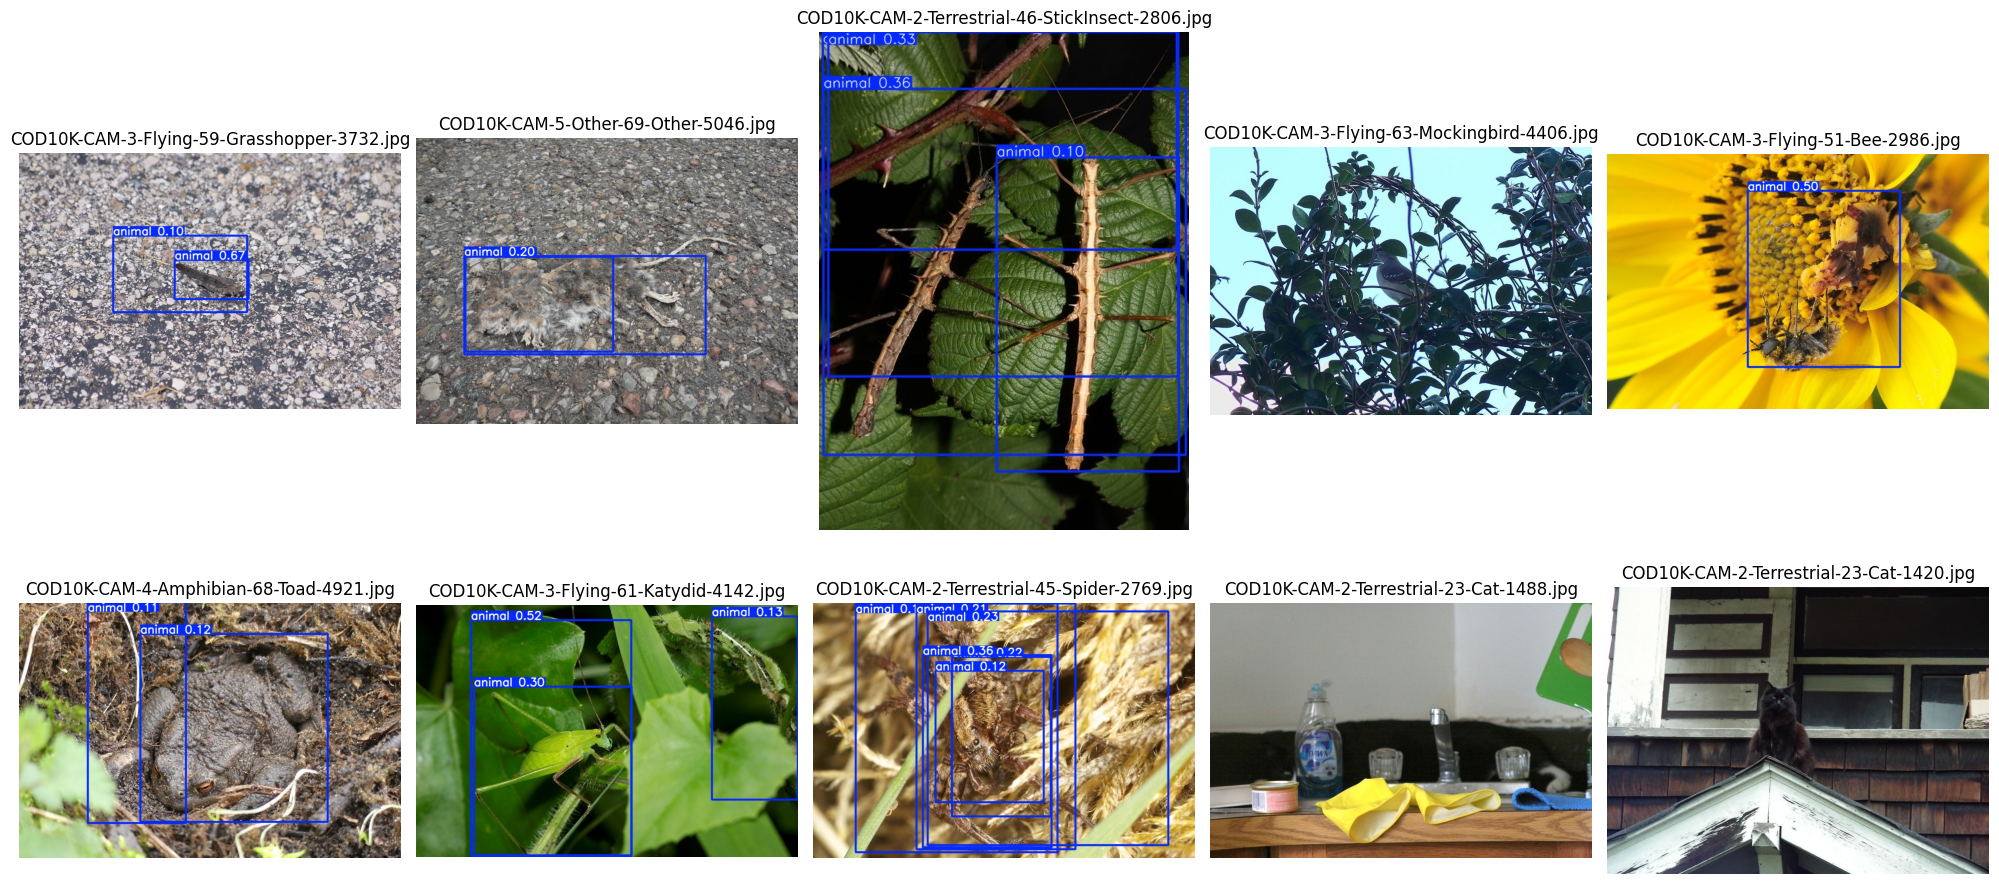

In [10]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Directory containing the images
image_dir = '/kaggle/working/runs/detect/predict7'

# Get a list of all the image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Display the first 10 images
plt.figure(figsize=(20, 10))
for i, image_file in enumerate(image_files[:10]):
    img_path = os.path.join(image_dir, image_file)
    img = Image.open(img_path)

    # Plot each image
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{image_file}")  # Display the image file name as the title

plt.tight_layout()
plt.show()
